# Tracking previous positions and addding mtb area measure
This notebook is for inspecting timelapse microscopy data, with associated sinhgle-cell labels and tracks, showing the infection of human macrophages with Mycobacterium Tuberculosis (Mtb), acquired on an Opera Phenix confocal microscope. 

In [1]:
import napari
import os, glob
from macrohet import dataio, tile, visualise, notify

In [3]:
from tqdm.auto import tqdm

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [2]:
%%time
expt_ID = 'PS0000'

base_dir = f'/mnt/SYNO/macrohet_syno/{expt_ID}/'
# base_dir = f'/mnt/DATA/macrohet/{expt_ID}/'

metadata_fn = glob.glob(os.path.join(base_dir, 'acquisition/Images/Index*xml'))[0]
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


0it [00:00, ?it/s]

Extracting metadata complete!
CPU times: user 11.2 s, sys: 872 ms, total: 12 s
Wall time: 12 s


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [4]:
metadata_path = glob.glob(os.path.join(base_dir, 'acquisition/Assaylayout/*.xml'))[0]
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
Row Column                                              
3   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      INH          0.04            EC50
    9          WT      BDQ          0.02            EC50
4   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      INH          0.04            EC50
    9          WT      BDQ          0.02            EC50
5   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      INH             2            EC99
    9          WT      BDQ           2.5            EC99
6   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      INH             2            EC99
    9          WT      BDQ           2.5            EC99

In [5]:
acq_ID = row, column = (3, 3)

#### Define subset if non-square tiling or more than one contiguous region of images in imaging well. 

In [ ]:
# subset_field_IDs = ['1','6','7','8','11','12','13','14','15']

#### Load images using Zarr (WIP)

In [6]:
import zarr

In [7]:
image_dir = os.path.join(base_dir, f'acquisition/zarr/{acq_ID}.zarr')
zarr_group = zarr.open(image_dir, mode='r')

### Now to lazily mosaic the images using Dask prior to viewing them.

1x (75,2,3) [TCZ] image stack takes approximately 1 minute to stitch together, so only load the one field of view I want.

In [9]:
%%time
# image_dir = os.path.join(base_dir, 'macrohet_images/Images_8bit')
image_dir = os.path.join(base_dir, 'acquisition/Images')
dask_images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             # subset_field_IDs=['16', '17',  '20', '21'], 
                             # n_tile_rows = 2, n_tile_cols = 2,
                             set_plane='max_proj',
                             # set_channel=1,
                             # set_time = 1,
#                             input_transforms = [input_transforms]
                            )#.compute().compute()
dask_images

CPU times: user 658 ms, sys: 3.96 ms, total: 662 ms
Wall time: 670 ms


dask.array<max-aggregate, shape=(75, 2, 6048, 6048), dtype=uint16, chunksize=(1, 2, 2160, 2160), chunktype=numpy.ndarray>

In [13]:
images = zarr_group.images
images.shape

(150, 2, 3, 6048, 6048)

In [14]:
viewer = napari.Viewer(title = f'{expt_ID, acq_ID}')

viewer.add_image(images, channel_axis = 1, 
                 # scale = napari_scale, 
                 contrast_limits=[[280, 1000],[0,3000]])

[<Image layer 'Image' at 0x7feb683d1820>,
 <Image layer 'Image [1]' at 0x7feb68380af0>]

In [23]:
%%time
z1 = images[:,:,0,...]

CPU times: user 18.4 s, sys: 59.3 s, total: 1min 17s
Wall time: 3min 46s


In [5]:
import btrack

In [27]:
with btrack.io.HDF5FileHandler(os.path.join(f'/mnt/SYNO/macrohet_syno/{expt_ID}/labels/macrohet_seg_model/{row, column}_first_pass.h5'), 
                                           'r', 
                                           obj_type='obj_type_1'
                                           ) as reader:
                # segmentation = reader.segmentation
                # tracks = reader.tracks
                objects = reader.objects

[INFO][2024/02/02 04:26:23 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 9)_first_pass.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 9)_first_pass.h5...
[INFO][2024/02/02 04:26:23 pm] Loading objects/obj_type_1 (30252, 5) (30252 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (30252, 5) (30252 filtered: None)
[INFO][2024/02/02 04:26:24 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 9)_first_pass.h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 9)_first_pass.h5


In [25]:
viewer = napari.Viewer(title = f'{expt_ID, acq_ID}')

viewer.add_image(z1, channel_axis = 1, 
                 # scale = napari_scale, 
                 contrast_limits=[[280, 1000],[0,3000]])
viewer.add_labels(segmentation)

<Labels layer 'segmentation' at 0x7fed26e6c0d0>

# Tracking


In [6]:
# define thresholds
segment_size_thresh = 5000
Mtb_load_thresh = 480

# define tracking scale factor
scale_factor = 1/5.04

# define features to use for tracking 
features = [
  "area",
  "major_axis_length",
  "minor_axis_length",
  "orientation",
  # "mean_intensity",
    ]

# define tracker config fn to use, using a prob_not_assign = 0.1
config_fn = '/home/dayn/analysis/models/btrack/particle_config_pnassign.json'
# define tracker config fn to use
# config_fn = '/home/dayn/analysis/btrack/models/particle_config.json'



def track_func(objects, masks, config_fn, search_radius = 20):

    # initialise a tracker session using a context manager
    with btrack.BayesianTracker() as tracker:
        # configure the tracker using a config file
        tracker.configure(config_fn)
        # set max search radius
        tracker.max_search_radius = search_radius
        # define tracking method
        tracker.tracking_updates = ["MOTION", "VISUAL"]
        # redefine features so that both channels are included in track measurements
        tracker.features = list(objects[0].properties.keys())
        # append the objects to be tracked
        tracker.append(objects)
        # set the tracking volume
        tracker.volume=((0, masks.shape[-2]*scale_factor), (0, masks.shape[-1]*scale_factor))
        # track them (in interactive mode)
        tracker.track(step_size=25)
        # generate hypotheses and run the global optimizer
        tracker.optimize()
        # store the tracks
        tracks = tracker.tracks

    return tracks



def localise(masks, intensity_image=None, properties=tuple(features), use_weighted_centroid = False):
    
    # localise objs in images
    objects = btrack.utils.segmentation_to_objects(segmentation=masks,
                                                   intensity_image=intensity_image, 
                                                   properties=properties,
                                                   scale=(scale_factor,scale_factor),
                                                   use_weighted_centroid=use_weighted_centroid, 
                                                   )
                                                   
    return objects



In [35]:
napari_tracks, _, _ = btrack.utils.tracks_to_napari(tracks, ndim=2)

In [40]:
viewer.add_tracks(napari_tracks, scale=(1/scale_factor, 1/scale_factor))

<Tracks layer 'napari_tracks [1]' at 0x7fed48fec6d0>

In [41]:
napari_tracks, _, _ = btrack.utils.tracks_to_napari([t for t in tracks if len(t)>75], ndim=2)

In [42]:
viewer.add_tracks(napari_tracks, scale=(1/scale_factor, 1/scale_factor))

<Tracks layer 'napari_tracks' at 0x7fed48ddf940>

In [43]:
napari_tracks, _, _ = btrack.utils.tracks_to_napari([t for t in tracks if len(t)>140], ndim=2)

In [44]:
viewer.add_tracks(napari_tracks, scale=(1/scale_factor, 1/scale_factor))

<Tracks layer 'napari_tracks [2]' at 0x7fed48c7ab80>

In [59]:
tracks[0]

,ID,t,x,y,z,parent,root,state,generation,dummy,Infected,major_axis_length,orientation,minor_axis_length,area,mean_intensity
0,161,0,538.658630,1056.783936,0.0,161,161,5,0,False,0.0,102.344345,1.006105,87.939522,6922.0,"(3,) array"
1,161,1,543.186584,1063.417725,0.0,161,161,5,0,False,0.0,148.417618,0.425117,103.712936,11870.0,"(3,) array"


In [7]:
mtb_channel = 1
gfp_channel = 0
manual_mtb_thresh_channel = 2

In [8]:
import pandas as pd
import numpy as np
from macrohet.tools import euc_dist
from tqdm.auto import tqdm

In [9]:
n = 0
labels = []
assay_layout['Technical repeat'] = 0

for (row, column), info in assay_layout.iterrows():
    strain = info['Strain']
    comp = info['Compound']
    conc = info['Concentration']
    ec_conc = info['ConcentrationEC']
    label = f'{strain},{comp},{ec_conc},{conc}'     
    if label not in labels:
        n =1
        assay_layout.loc[(row, column), 'Technical replicate'] = n
        assay_layout.loc[(row, column), 'Technical repeat'] = n


        labels.append(label)
    else:
        n = labels.count(label)+1
        assay_layout.loc[(row, column), 'Technical replicate'] = n
        assay_layout.loc[(row, column), 'Technical repeat'] = n

        labels.append(label)

# Compile track info without area

In [97]:
dfs = []
dfs_all = []
for acq_ID, info in tqdm(assay_layout.iterrows(), total = len(assay_layout), desc = 'iterating over positions'): 
    
    fn = os.path.join(f'/mnt/SYNO/macrohet_syno/{expt_ID}/labels/macrohet_seg_model/{acq_ID}_first_pass.h5')
    if os.path.exists(fn):
        
        with btrack.io.HDF5FileHandler(fn, 
                                           'r', 
                                           obj_type='obj_type_1'
                                           ) as reader:
                segmentation = reader.segmentation
                # tracks = reader.tracks
                objects = reader.objects

        tracks = track_func(objects, segmentation, config_fn)
    
        filtered_tracks = [t for t in tracks if len(t) >74]


        for track in tqdm(filtered_tracks, total = len(filtered_tracks), desc = 'iterating over tracks'):
            # Raw MTB values (interpolated)
            raw_mtb_values = pd.Series(track['mean_intensity'][:, mtb_channel]).interpolate(method='linear')
            
            # Raw GFP values (interpolated)
            raw_gfp = pd.Series(track['mean_intensity'][:, gfp_channel]).interpolate(method='linear')
            
            # Thresholded MTB values (interpolated)
            mtb_values = pd.Series(track['mean_intensity'][:, manual_mtb_thresh_channel]).interpolate(method='linear')
            
            # Smoothed MTB signal using a rolling window of 4 with median values,
            # then backfilling missing values at the start
            mtb_smooth = np.array(mtb_values.rolling(window=4).median().interpolate(method='backfill'))
            
            # Interpolate other variables using appropriate methods
            minor_axis_length = pd.Series(track['minor_axis_length']).interpolate(method='linear')
            major_axis_length = pd.Series(track['major_axis_length']).interpolate(method='linear')
            
            # Interpolate infection status using a combination of approaches
            infection_status = pd.Series(track['Infected'])
            
            # If the first value is missing, assign it the closest infection value
            if pd.isnull(infection_status.iloc[0]):
                infection_status.iloc[0] = infection_status.iloc[infection_status.first_valid_index()]
            
            # Fill subsequent missing values with the previous value
            infection_status = infection_status.fillna(method='ffill')
            
            # Interpolate area based on linear method
            area = pd.Series(track['area']).interpolate(method='linear')
            
            # Compile single track dictionary of info
            d = {
                'Time (hours)': track['t'],
                'x': track['x'],
                'y': track['y'],
                'x scaled': [track['x'][i] * 5.04 for i, x in enumerate(track['x'])],
                'y scaled': [track['y'][i] * 5.04 for i, y in enumerate(track['y'])],
                'Infection status': track['Infected'],
                'Initial infection status': track['Infected'][0],
                'Final infection status': track['Infected'][-1],
                'Area': track['area'],
                'Intracellular mean Mtb content': raw_mtb_values,
                'Intracellular thresholded Mtb content': mtb_values,
                'Intracellular thresholded Mtb content smooth': mtb_smooth,
                'Macroph. GFP expression': raw_gfp,
                'delta Mtb raw': [np.array(mtb_values)[-1] - np.array(mtb_values)[0] for i in range(len(track))],
                'delta Mtb max raw': [(max(mtb_values) - min(mtb_values)) * (1 if np.argmax(mtb_values) > np.argmin(mtb_values) else -1) for i in range(len(track))],
                'delta Mtb max smooth': [(max(mtb_smooth) - min(mtb_smooth)) * (1 if np.argmax(mtb_smooth) > np.argmin(mtb_smooth) else -1) for i in range(len(track))],
                'delta Mtb max fold-change': [max(mtb_smooth) / min(mtb_smooth[mtb_smooth > 0]) * (1 if np.argmax(mtb_smooth) > np.argmin(mtb_smooth) else -1) if np.any(mtb_smooth > 0) else 0 for i in range(len(track))],
                'delta Mtb max fold-change normalised mean area': [(max(mtb_smooth) / min(mtb_smooth[mtb_smooth > 0]) * (1 if np.argmax(mtb_smooth) > np.argmin(mtb_smooth) else -1)) / np.mean(area) if np.any(mtb_smooth > 0) else 0 for i in range(len(track))],
                'delta Mtb max fold-change normalised max area': [(max(mtb_smooth) / min(mtb_smooth[mtb_smooth > 0]) * (1 if np.argmax(mtb_smooth) > np.argmin(mtb_smooth) else -1)) / np.max(area) if np.any(mtb_smooth > 0) else 0 for i in range(len(track))],
                'delta Mtb/dt': np.polyfit(np.arange(len(mtb_smooth)), mtb_smooth, 1)[0],
                'Eccentricity': np.sqrt(1 - ((minor_axis_length ** 2) / (major_axis_length ** 2))),
                'MSD': [euc_dist(track['x'][i - 1], track['y'][i - 1], track['x'][i], track['y'][i]) if i != 0 else 0 for i in range(0, len(track))],
                'Strain': [info['Strain'] for i in range(len(track['t']))],
                'Compound': [info['Compound'] for i in range(len(track['t']))],
                'Concentration': [info['ConcentrationEC'] for i in range(len(track['t']))],
                'Technical replicate': [info['Technical replicate'] for i in range(len(track['t']))],
                'Cell ID': [track.ID for i in range(len(track['t']))],
                'Acquisition ID': [acq_ID for i in range(len(track['t']))],
                'Unique ID': [f'{track.ID}.{acq_ID[0]}.{acq_ID[1]}' for i in range(len(track['t']))]}
            
            
            ### append df to list of dfs
            dfs.append(pd.DataFrame(d))
            df = pd.DataFrame(d)
            df.to_pickle('temp_save.pkl')

        for track in tqdm(filtered_tracks, total = len(filtered_tracks), desc = 'iterating over tracks'):
            # Raw MTB values (interpolated)
            raw_mtb_values = pd.Series(track['mean_intensity'][:, mtb_channel]).interpolate(method='linear')
            
            # Raw GFP values (interpolated)
            raw_gfp = pd.Series(track['mean_intensity'][:, gfp_channel]).interpolate(method='linear')
            
            # Thresholded MTB values (interpolated)
            mtb_values = pd.Series(track['mean_intensity'][:, manual_mtb_thresh_channel]).interpolate(method='linear')
            
            # Smoothed MTB signal using a rolling window of 4 with median values,
            # then backfilling missing values at the start
            mtb_smooth = np.array(mtb_values.rolling(window=4).median().interpolate(method='backfill'))
            
            # Interpolate other variables using appropriate methods
            minor_axis_length = pd.Series(track['minor_axis_length']).interpolate(method='linear')
            major_axis_length = pd.Series(track['major_axis_length']).interpolate(method='linear')
            
            # Interpolate infection status using a combination of approaches
            infection_status = pd.Series(track['Infected'])
            
            # If the first value is missing, assign it the closest infection value
            if pd.isnull(infection_status.iloc[0]):
                infection_status.iloc[0] = infection_status.iloc[infection_status.first_valid_index()]
            
            # Fill subsequent missing values with the previous value
            infection_status = infection_status.fillna(method='ffill')
            
            # Interpolate area based on linear method
            area = pd.Series(track['area']).interpolate(method='linear')
            
            # Compile single track dictionary of info
            d = {
                'Time (hours)': track['t'],
                'x': track['x'],
                'y': track['y'],
                'x scaled': [track['x'][i] * 5.04 for i, x in enumerate(track['x'])],
                'y scaled': [track['y'][i] * 5.04 for i, y in enumerate(track['y'])],
                'Infection status': track['Infected'],
                'Initial infection status': track['Infected'][0],
                'Final infection status': track['Infected'][-1],
                'Area': track['area'],
                'Intracellular mean Mtb content': raw_mtb_values,
                'Intracellular thresholded Mtb content': mtb_values,
                'Intracellular thresholded Mtb content smooth': mtb_smooth,
                'Macroph. GFP expression': raw_gfp,
                'delta Mtb raw': [np.array(mtb_values)[-1] - np.array(mtb_values)[0] for i in range(len(track))],
                'delta Mtb max raw': [(max(mtb_values) - min(mtb_values)) * (1 if np.argmax(mtb_values) > np.argmin(mtb_values) else -1) for i in range(len(track))],
                'delta Mtb max smooth': [(max(mtb_smooth) - min(mtb_smooth)) * (1 if np.argmax(mtb_smooth) > np.argmin(mtb_smooth) else -1) for i in range(len(track))],
                'delta Mtb max fold-change': [max(mtb_smooth) / min(mtb_smooth[mtb_smooth > 0]) * (1 if np.argmax(mtb_smooth) > np.argmin(mtb_smooth) else -1) if np.any(mtb_smooth > 0) else 0 for i in range(len(track))],
                'delta Mtb max fold-change normalised mean area': [(max(mtb_smooth) / min(mtb_smooth[mtb_smooth > 0]) * (1 if np.argmax(mtb_smooth) > np.argmin(mtb_smooth) else -1)) / np.mean(area) if np.any(mtb_smooth > 0) else 0 for i in range(len(track))],
                'delta Mtb max fold-change normalised max area': [(max(mtb_smooth) / min(mtb_smooth[mtb_smooth > 0]) * (1 if np.argmax(mtb_smooth) > np.argmin(mtb_smooth) else -1)) / np.max(area) if np.any(mtb_smooth > 0) else 0 for i in range(len(track))],
                'delta Mtb/dt': np.polyfit(np.arange(len(mtb_smooth)), mtb_smooth, 1)[0],
                'Eccentricity': np.sqrt(1 - ((minor_axis_length ** 2) / (major_axis_length ** 2))),
                'MSD': [euc_dist(track['x'][i - 1], track['y'][i - 1], track['x'][i], track['y'][i]) if i != 0 else 0 for i in range(0, len(track))],
                'Strain': [info['Strain'] for i in range(len(track['t']))],
                'Compound': [info['Compound'] for i in range(len(track['t']))],
                'Concentration': [info['ConcentrationEC'] for i in range(len(track['t']))],
                'Technical replicate': [info['Technical replicate'] for i in range(len(track['t']))],
                'Cell ID': [track.ID for i in range(len(track['t']))],
                'Acquisition ID': [acq_ID for i in range(len(track['t']))],
                'Unique ID': [f'{track.ID}.{acq_ID[0]}.{acq_ID[1]}' for i in range(len(track['t']))]}
                
                
            ### append df to list of dfs
            dfs_all.append(pd.DataFrame(d))
            df_all = pd.DataFrame(d)
            df_all.to_pickle('temp_save_all_tracks.pkl')
### concat single track dfs into big df
df = pd.concat(dfs, ignore_index=True)


iterating over positions:   0%|          | 0/42 [00:00<?, ?it/s]

[INFO][2024/02/02 05:36:54 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 3)_first_pass.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 3)_first_pass.h5...
[INFO][2024/02/02 05:37:27 pm] Loading segmentation (150, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (150, 6048, 6048)
[INFO][2024/02/02 05:37:27 pm] Loading objects/obj_type_1 (43070, 5) (43070 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (43070, 5) (43070 filtered: None)
[INFO][2024/02/02 05:37:28 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 3)_first_pass.h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 3)_first_pass.h5
[INFO][2024/02/02 05:37:28 pm] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
INFO:btrack.libwrapper:Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2024/02/02 05

GLPK Integer Optimizer 5.0
21884 rows, 18511 columns, 26080 non-zeros
18511 integer variables, all of which are binary
Preprocessing...
10942 rows, 18511 columns, 26080 non-zeros
18511 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 10942
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
10942 rows, 18511 columns, 26080 non-zeros
*     0: obj =   6.410405089e+04 inf =   0.000e+00 (5134)
Perturbing LP to avoid stalling [2203]...
Removing LP perturbation [5156]...
*  5156: obj =   3.146267680e+04 inf =   0.000e+00 (0) 1
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  5156: mip =     not found yet >=              -inf        (1; 0)
+  5156: >>>>>   3.146267680e+04 >=   3.146267680e+04   0.0% (1; 0)
+  5156: mip =   3.146267680e+04 >=     tree is empty   0.0% (0; 1)
INTEGER O

[INFO][2024/02/02 05:37:46 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session


iterating over tracks:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_190534/55377132.py:33: FutureWarning: Series.interpolate with method=backfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mtb_smooth = np.array(mtb_values.rolling(window=4).median().interpolate(method='backfill'))
/tmp/ipykernel_190534/55377132.py:47: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  infection_status = infection_status.fillna(method='ffill')


iterating over tracks:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_190534/55377132.py:102: FutureWarning: Series.interpolate with method=backfill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mtb_smooth = np.array(mtb_values.rolling(window=4).median().interpolate(method='backfill'))
/tmp/ipykernel_190534/55377132.py:116: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  infection_status = infection_status.fillna(method='ffill')
[INFO][2024/02/02 05:37:56 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 4)_first_pass.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 4)_first_pass.h5...
[INFO][2024/02/02 05:38:35 pm] Loading segmentation (150, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (150, 6048, 6048)
[INFO][2024/02/02 05:38:36 pm] Loading objects/obj_type_1 (50141, 5) (50141 filtered: None)
INFO:btrack.io.hdf:Lo

GLPK Integer Optimizer 5.0
28504 rows, 24393 columns, 34534 non-zeros
24393 integer variables, all of which are binary
Preprocessing...
14252 rows, 24393 columns, 34534 non-zeros
24393 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14252
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14252 rows, 24393 columns, 34534 non-zeros
*     0: obj =   8.367006095e+04 inf =   0.000e+00 (6978)
Perturbing LP to avoid stalling [2415]...
Removing LP perturbation [7046]...
*  7046: obj =   4.136481206e+04 inf =   0.000e+00 (0) 2
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  7046: mip =     not found yet >=              -inf        (1; 0)
+  7046: >>>>>   4.136481206e+04 >=   4.136481206e+04   0.0% (1; 0)
+  7046: mip =   4.136481206e+04 >=     tree is empty   0.0% (0; 1)
INTEGER O

[INFO][2024/02/02 05:39:01 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session


iterating over tracks:   0%|          | 0/149 [00:00<?, ?it/s]

iterating over tracks:   0%|          | 0/149 [00:00<?, ?it/s]

[INFO][2024/02/02 05:39:11 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 5)_first_pass.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 5)_first_pass.h5...
[INFO][2024/02/02 05:39:41 pm] Loading segmentation (150, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (150, 6048, 6048)
[INFO][2024/02/02 05:39:42 pm] Loading objects/obj_type_1 (43616, 5) (43616 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (43616, 5) (43616 filtered: None)
[INFO][2024/02/02 05:39:42 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 5)_first_pass.h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 5)_first_pass.h5
[INFO][2024/02/02 05:39:42 pm] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
INFO:btrack.libwrapper:Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2024/02/02 05

GLPK Integer Optimizer 5.0
24304 rows, 20449 columns, 28746 non-zeros
20449 integer variables, all of which are binary
Preprocessing...
12152 rows, 20449 columns, 28746 non-zeros
20449 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 12152
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
12152 rows, 20449 columns, 28746 non-zeros
*     0: obj =   7.129986240e+04 inf =   0.000e+00 (5611)
Perturbing LP to avoid stalling [2291]...
Removing LP perturbation [5692]...
*  5692: obj =   3.566235527e+04 inf =   0.000e+00 (0) 1
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  5692: mip =     not found yet >=              -inf        (1; 0)
+  5692: >>>>>   3.566235527e+04 >=   3.566235527e+04   0.0% (1; 0)
+  5692: mip =   3.566235527e+04 >=     tree is empty   0.0% (0; 1)
INTEGER O

[INFO][2024/02/02 05:40:00 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session


iterating over tracks:   0%|          | 0/135 [00:00<?, ?it/s]

iterating over tracks:   0%|          | 0/135 [00:00<?, ?it/s]

[INFO][2024/02/02 05:40:09 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 6)_first_pass.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 6)_first_pass.h5...
[INFO][2024/02/02 05:40:47 pm] Loading segmentation (150, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (150, 6048, 6048)
[INFO][2024/02/02 05:40:47 pm] Loading objects/obj_type_1 (45006, 5) (45006 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (45006, 5) (45006 filtered: None)
[INFO][2024/02/02 05:40:48 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 6)_first_pass.h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 6)_first_pass.h5
[INFO][2024/02/02 05:40:48 pm] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
INFO:btrack.libwrapper:Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2024/02/02 05

GLPK Integer Optimizer 5.0
22324 rows, 18831 columns, 26500 non-zeros
18831 integer variables, all of which are binary
Preprocessing...
11162 rows, 18831 columns, 26500 non-zeros
18831 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 11162
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
11162 rows, 18831 columns, 26500 non-zeros
*     0: obj =   6.448705001e+04 inf =   0.000e+00 (5115)
Perturbing LP to avoid stalling [2176]...
Removing LP perturbation [5149]...
*  5149: obj =   3.200849811e+04 inf =   0.000e+00 (0) 1
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  5149: mip =     not found yet >=              -inf        (1; 0)
+  5149: >>>>>   3.200849811e+04 >=   3.200849811e+04   0.0% (1; 0)
+  5149: mip =   3.200849811e+04 >=     tree is empty   0.0% (0; 1)
INTEGER O

[INFO][2024/02/02 05:41:06 pm] Completed optimization with 4364 tracks
INFO:btrack.core:Completed optimization with 4364 tracks
[INFO][2024/02/02 05:41:06 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session


iterating over tracks:   0%|          | 0/150 [00:00<?, ?it/s]

iterating over tracks:   0%|          | 0/150 [00:00<?, ?it/s]

[INFO][2024/02/02 05:41:17 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 7)_first_pass.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 7)_first_pass.h5...
[INFO][2024/02/02 05:41:51 pm] Loading segmentation (150, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (150, 6048, 6048)
[INFO][2024/02/02 05:41:51 pm] Loading objects/obj_type_1 (23214, 5) (23214 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (23214, 5) (23214 filtered: None)
[INFO][2024/02/02 05:41:52 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 7)_first_pass.h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 7)_first_pass.h5
[INFO][2024/02/02 05:41:52 pm] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
INFO:btrack.libwrapper:Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2024/02/02 05

GLPK Integer Optimizer 5.0
16104 rows, 13219 columns, 18386 non-zeros
13219 integer variables, all of which are binary
Preprocessing...
8052 rows, 13219 columns, 18386 non-zeros
13219 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 8052
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
8052 rows, 13219 columns, 18386 non-zeros
*     0: obj =   4.756743384e+04 inf =   0.000e+00 (3829)
Perturbing LP to avoid stalling [1941]...
Removing LP perturbation [3906]...
*  3906: obj =   2.126643918e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3906: mip =     not found yet >=              -inf        (1; 0)
+  3906: >>>>>   2.126643918e+04 >=   2.126643918e+04   0.0% (1; 0)
+  3906: mip =   2.126643918e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMA

[INFO][2024/02/02 05:41:57 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session


iterating over tracks:   0%|          | 0/72 [00:00<?, ?it/s]

iterating over tracks:   0%|          | 0/72 [00:00<?, ?it/s]

[INFO][2024/02/02 05:42:03 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 8)_first_pass.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 8)_first_pass.h5...
[INFO][2024/02/02 05:42:44 pm] Loading segmentation (150, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (150, 6048, 6048)
[INFO][2024/02/02 05:42:45 pm] Loading objects/obj_type_1 (27158, 5) (27158 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (27158, 5) (27158 filtered: None)
[INFO][2024/02/02 05:42:45 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 8)_first_pass.h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 8)_first_pass.h5
[INFO][2024/02/02 05:42:45 pm] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
INFO:btrack.libwrapper:Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2024/02/02 05

GLPK Integer Optimizer 5.0
16108 rows, 13283 columns, 18512 non-zeros
13283 integer variables, all of which are binary
Preprocessing...
8054 rows, 13283 columns, 18512 non-zeros
13283 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 8054
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
8054 rows, 13283 columns, 18512 non-zeros
*     0: obj =   4.714119825e+04 inf =   0.000e+00 (3714)
Perturbing LP to avoid stalling [1821]...
Removing LP perturbation [3781]...
*  3781: obj =   2.221681051e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3781: mip =     not found yet >=              -inf        (1; 0)
+  3781: >>>>>   2.221681051e+04 >=   2.221681051e+04   0.0% (1; 0)
+  3781: mip =   2.221681051e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMA

[INFO][2024/02/02 05:42:52 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session


iterating over tracks:   0%|          | 0/86 [00:00<?, ?it/s]

iterating over tracks:   0%|          | 0/86 [00:00<?, ?it/s]

[INFO][2024/02/02 05:42:59 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 9)_first_pass.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 9)_first_pass.h5...
[INFO][2024/02/02 05:43:32 pm] Loading segmentation (150, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (150, 6048, 6048)
[INFO][2024/02/02 05:43:33 pm] Loading objects/obj_type_1 (30252, 5) (30252 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (30252, 5) (30252 filtered: None)
[INFO][2024/02/02 05:43:34 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 9)_first_pass.h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 9)_first_pass.h5
[INFO][2024/02/02 05:43:34 pm] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
INFO:btrack.libwrapper:Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2024/02/02 05

GLPK Integer Optimizer 5.0
18040 rows, 15000 columns, 20980 non-zeros
15000 integer variables, all of which are binary
Preprocessing...
9020 rows, 15000 columns, 20980 non-zeros
15000 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 9020
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
9020 rows, 15000 columns, 20980 non-zeros
*     0: obj =   5.254093250e+04 inf =   0.000e+00 (4189)
Perturbing LP to avoid stalling [1877]...
Removing LP perturbation [4249]...
*  4249: obj =   2.545315709e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  4249: mip =     not found yet >=              -inf        (1; 0)
+  4249: >>>>>   2.545315709e+04 >=   2.545315709e+04   0.0% (1; 0)
+  4249: mip =   2.545315709e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMA

[INFO][2024/02/02 05:43:43 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session


iterating over tracks:   0%|          | 0/84 [00:00<?, ?it/s]

iterating over tracks:   0%|          | 0/84 [00:00<?, ?it/s]

[INFO][2024/02/02 05:43:49 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 10)_first_pass.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 10)_first_pass.h5...
[INFO][2024/02/02 05:44:30 pm] Loading segmentation (150, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (150, 6048, 6048)
[INFO][2024/02/02 05:44:30 pm] Loading objects/obj_type_1 (21732, 5) (21732 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (21732, 5) (21732 filtered: None)
[INFO][2024/02/02 05:44:30 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 10)_first_pass.h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 10)_first_pass.h5
[INFO][2024/02/02 05:44:30 pm] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
INFO:btrack.libwrapper:Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2024/02/0

GLPK Integer Optimizer 5.0
14100 rows, 11581 columns, 16112 non-zeros
11581 integer variables, all of which are binary
Preprocessing...
7050 rows, 11581 columns, 16112 non-zeros
11581 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 7050
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
7050 rows, 11581 columns, 16112 non-zeros
*     0: obj =   4.121827107e+04 inf =   0.000e+00 (3291)
Perturbing LP to avoid stalling [1660]...
Removing LP perturbation [3336]...
*  3336: obj =   1.879496680e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3336: mip =     not found yet >=              -inf        (1; 0)
+  3336: >>>>>   1.879496680e+04 >=   1.879496680e+04   0.0% (1; 0)
+  3336: mip =   1.879496680e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMA

INFO:btrack.core:Ending BayesianTracker session


iterating over tracks:   0%|          | 0/70 [00:00<?, ?it/s]

iterating over tracks:   0%|          | 0/70 [00:00<?, ?it/s]

[INFO][2024/02/02 05:44:42 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 11)_first_pass.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 11)_first_pass.h5...
[INFO][2024/02/02 05:45:04 pm] Loading segmentation (150, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (150, 6048, 6048)
[INFO][2024/02/02 05:45:04 pm] Loading objects/obj_type_1 (19058, 5) (19058 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (19058, 5) (19058 filtered: None)
[INFO][2024/02/02 05:45:04 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 11)_first_pass.h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 11)_first_pass.h5
[INFO][2024/02/02 05:45:04 pm] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
INFO:btrack.libwrapper:Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2024/02/0

GLPK Integer Optimizer 5.0
10248 rows, 8427 columns, 11730 non-zeros
8427 integer variables, all of which are binary
Preprocessing...
5124 rows, 8427 columns, 11730 non-zeros
8427 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 5124
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
5124 rows, 8427 columns, 11730 non-zeros
*     0: obj =   2.972595705e+04 inf =   0.000e+00 (2329)
Perturbing LP to avoid stalling [1272]...
Removing LP perturbation [2366]...
*  2366: obj =   1.389949685e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  2366: mip =     not found yet >=              -inf        (1; 0)
+  2366: >>>>>   1.389949685e+04 >=   1.389949685e+04   0.0% (1; 0)
+  2366: mip =   1.389949685e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOL

[INFO][2024/02/02 05:45:09 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session


iterating over tracks:   0%|          | 0/73 [00:00<?, ?it/s]

iterating over tracks:   0%|          | 0/73 [00:00<?, ?it/s]

[INFO][2024/02/02 05:45:16 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 12)_first_pass.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 12)_first_pass.h5...
[INFO][2024/02/02 05:45:54 pm] Loading segmentation (150, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (150, 6048, 6048)
[INFO][2024/02/02 05:45:54 pm] Loading objects/obj_type_1 (8665, 5) (8665 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (8665, 5) (8665 filtered: None)
[INFO][2024/02/02 05:45:54 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 12)_first_pass.h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(3, 12)_first_pass.h5
[INFO][2024/02/02 05:45:54 pm] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
INFO:btrack.libwrapper:Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2024/02/02 05

GLPK Integer Optimizer 5.0
3176 rows, 2541 columns, 3494 non-zeros
2541 integer variables, all of which are binary
Preprocessing...
1588 rows, 2541 columns, 3494 non-zeros
2541 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 1588
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
1588 rows, 2541 columns, 3494 non-zeros
*     0: obj =   8.513208795e+03 inf =   0.000e+00 (614)
*   617: obj =   4.438414258e+03 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+   617: mip =     not found yet >=              -inf        (1; 0)
+   617: >>>>>   4.438414258e+03 >=   4.438414258e+03   0.0% (1; 0)
+   617: mip =   4.438414258e+03 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOLUTION FOUND


iterating over tracks:   0%|          | 0/33 [00:00<?, ?it/s]

iterating over tracks:   0%|          | 0/33 [00:00<?, ?it/s]

[INFO][2024/02/02 05:45:58 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(4, 3)_first_pass.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(4, 3)_first_pass.h5...
[INFO][2024/02/02 05:46:27 pm] Loading segmentation (150, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (150, 6048, 6048)
[INFO][2024/02/02 05:46:27 pm] Loading objects/obj_type_1 (50457, 5) (50457 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (50457, 5) (50457 filtered: None)
[INFO][2024/02/02 05:46:28 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(4, 3)_first_pass.h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(4, 3)_first_pass.h5
[INFO][2024/02/02 05:46:28 pm] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
INFO:btrack.libwrapper:Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2024/02/02 05

GLPK Integer Optimizer 5.0
26928 rows, 22998 columns, 32532 non-zeros
22998 integer variables, all of which are binary
Preprocessing...
13464 rows, 22998 columns, 32532 non-zeros
22998 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13464
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13464 rows, 22998 columns, 32532 non-zeros
*     0: obj =   7.827566450e+04 inf =   0.000e+00 (6336)
Perturbing LP to avoid stalling [2347]...
Removing LP perturbation [6377]...
*  6377: obj =   3.975585252e+04 inf =   0.000e+00 (0) 2
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  6377: mip =     not found yet >=              -inf        (1; 0)
+  6377: >>>>>   3.975585252e+04 >=   3.975585252e+04   0.0% (1; 0)
+  6377: mip =   3.975585252e+04 >=     tree is empty   0.0% (0; 1)
INTEGER O

[INFO][2024/02/02 05:46:51 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session


iterating over tracks:   0%|          | 0/147 [00:00<?, ?it/s]

iterating over tracks:   0%|          | 0/147 [00:00<?, ?it/s]

[INFO][2024/02/02 05:47:01 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(4, 4)_first_pass.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(4, 4)_first_pass.h5...
[INFO][2024/02/02 05:47:38 pm] Loading segmentation (150, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (150, 6048, 6048)
[INFO][2024/02/02 05:47:38 pm] Loading objects/obj_type_1 (53180, 5) (53180 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (53180, 5) (53180 filtered: None)
[INFO][2024/02/02 05:47:39 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(4, 4)_first_pass.h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(4, 4)_first_pass.h5
[INFO][2024/02/02 05:47:39 pm] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
INFO:btrack.libwrapper:Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2024/02/02 05

GLPK Integer Optimizer 5.0
28408 rows, 24378 columns, 34552 non-zeros
24378 integer variables, all of which are binary
Preprocessing...
14204 rows, 24378 columns, 34552 non-zeros
24378 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14204
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14204 rows, 24378 columns, 34552 non-zeros
*     0: obj =   8.252957250e+04 inf =   0.000e+00 (6777)
Perturbing LP to avoid stalling [2485]...
Removing LP perturbation [6789]...
*  6789: obj =   4.187113481e+04 inf =   0.000e+00 (0) 2
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  6789: mip =     not found yet >=              -inf        (1; 0)
+  6789: >>>>>   4.187113481e+04 >=   4.187113481e+04   0.0% (1; 0)
+  6789: mip =   4.187113481e+04 >=     tree is empty   0.0% (0; 1)
INTEGER O

[INFO][2024/02/02 05:48:04 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session


iterating over tracks:   0%|          | 0/131 [00:00<?, ?it/s]

iterating over tracks:   0%|          | 0/131 [00:00<?, ?it/s]

[INFO][2024/02/02 05:48:13 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(4, 5)_first_pass.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(4, 5)_first_pass.h5...
[INFO][2024/02/02 05:48:41 pm] Loading segmentation (150, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (150, 6048, 6048)
[INFO][2024/02/02 05:48:41 pm] Loading objects/obj_type_1 (50087, 5) (50087 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (50087, 5) (50087 filtered: None)
[INFO][2024/02/02 05:48:43 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(4, 5)_first_pass.h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(4, 5)_first_pass.h5
[INFO][2024/02/02 05:48:43 pm] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
INFO:btrack.libwrapper:Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2024/02/02 05

GLPK Integer Optimizer 5.0
26308 rows, 22474 columns, 31794 non-zeros
22474 integer variables, all of which are binary
Preprocessing...
13154 rows, 22474 columns, 31794 non-zeros
22474 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13154
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
13154 rows, 22474 columns, 31794 non-zeros
*     0: obj =   7.664215711e+04 inf =   0.000e+00 (6328)
Perturbing LP to avoid stalling [2404]...
Removing LP perturbation [6405]...
*  6405: obj =   3.813663394e+04 inf =   0.000e+00 (0) 2
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  6405: mip =     not found yet >=              -inf        (1; 0)
+  6405: >>>>>   3.813663394e+04 >=   3.813663394e+04   0.0% (1; 0)
+  6405: mip =   3.813663394e+04 >=     tree is empty   0.0% (0; 1)
INTEGER O

[INFO][2024/02/02 05:49:05 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session


iterating over tracks:   0%|          | 0/151 [00:00<?, ?it/s]

iterating over tracks:   0%|          | 0/151 [00:00<?, ?it/s]

[INFO][2024/02/02 05:49:16 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(4, 6)_first_pass.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(4, 6)_first_pass.h5...
[INFO][2024/02/02 05:49:52 pm] Loading segmentation (150, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (150, 6048, 6048)
[INFO][2024/02/02 05:49:52 pm] Loading objects/obj_type_1 (51799, 5) (51799 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (51799, 5) (51799 filtered: None)
[INFO][2024/02/02 05:49:53 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(4, 6)_first_pass.h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(4, 6)_first_pass.h5
[INFO][2024/02/02 05:49:53 pm] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
INFO:btrack.libwrapper:Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2024/02/02 05

GLPK Integer Optimizer 5.0
29844 rows, 25503 columns, 36084 non-zeros
25503 integer variables, all of which are binary
Preprocessing...
14922 rows, 25503 columns, 36084 non-zeros
25503 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 14922
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
14922 rows, 25503 columns, 36084 non-zeros
*     0: obj =   8.639677843e+04 inf =   0.000e+00 (7094)
Perturbing LP to avoid stalling [2467]...
Removing LP perturbation [7111]...
*  7111: obj =   4.438029072e+04 inf =   0.000e+00 (0) 2
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  7111: mip =     not found yet >=              -inf        (1; 0)
+  7111: >>>>>   4.438029072e+04 >=   4.438029072e+04   0.0% (1; 0)
+  7111: mip =   4.438029072e+04 >=     tree is empty   0.0% (0; 1)
INTEGER O

[INFO][2024/02/02 05:50:19 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session


iterating over tracks:   0%|          | 0/125 [00:00<?, ?it/s]

iterating over tracks:   0%|          | 0/125 [00:00<?, ?it/s]

[INFO][2024/02/02 05:50:28 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(4, 7)_first_pass.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(4, 7)_first_pass.h5...
[INFO][2024/02/02 05:50:56 pm] Loading segmentation (150, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (150, 6048, 6048)
[INFO][2024/02/02 05:50:56 pm] Loading objects/obj_type_1 (43714, 5) (43714 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (43714, 5) (43714 filtered: None)
[INFO][2024/02/02 05:50:56 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(4, 7)_first_pass.h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(4, 7)_first_pass.h5
[INFO][2024/02/02 05:50:56 pm] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
INFO:btrack.libwrapper:Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2024/02/02 05

GLPK Integer Optimizer 5.0
30128 rows, 25690 columns, 36316 non-zeros
25690 integer variables, all of which are binary
Preprocessing...
15064 rows, 25690 columns, 36316 non-zeros
25690 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 15064
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
15064 rows, 25690 columns, 36316 non-zeros
*     0: obj =   8.810842431e+04 inf =   0.000e+00 (7499)
Perturbing LP to avoid stalling [2469]...
Removing LP perturbation [7531]...
*  7531: obj =   4.406699290e+04 inf =   0.000e+00 (0) 2
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  7531: mip =     not found yet >=              -inf        (1; 0)
+  7531: >>>>>   4.406699290e+04 >=   4.406699290e+04   0.0% (1; 0)
+  7531: mip =   4.406699290e+04 >=     tree is empty   0.0% (0; 1)
INTEGER O

[INFO][2024/02/02 05:51:16 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session


iterating over tracks:   0%|          | 0/84 [00:00<?, ?it/s]

iterating over tracks:   0%|          | 0/84 [00:00<?, ?it/s]

[INFO][2024/02/02 05:51:22 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(4, 8)_first_pass.h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(4, 8)_first_pass.h5...
[INFO][2024/02/02 05:51:59 pm] Loading segmentation (150, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (150, 6048, 6048)
[INFO][2024/02/02 05:51:59 pm] Loading objects/obj_type_1 (42285, 5) (42285 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (42285, 5) (42285 filtered: None)
[INFO][2024/02/02 05:52:01 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(4, 8)_first_pass.h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/macrohet_seg_model/(4, 8)_first_pass.h5
[INFO][2024/02/02 05:52:01 pm] Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
INFO:btrack.libwrapper:Loaded btrack: /home/dayn/analysis/btrack/btrack/libs/libtracker.so
[INFO][2024/02/02 05

GLPK Integer Optimizer 5.0
25188 rows, 21473 columns, 30352 non-zeros
21473 integer variables, all of which are binary
Preprocessing...
12594 rows, 21473 columns, 30352 non-zeros
21473 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 12594
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
12594 rows, 21473 columns, 30352 non-zeros
*     0: obj =   7.383294495e+04 inf =   0.000e+00 (6237)
Perturbing LP to avoid stalling [2305]...
Removing LP perturbation [6285]...
*  6285: obj =   3.606575304e+04 inf =   0.000e+00 (0) 1
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  6285: mip =     not found yet >=              -inf        (1; 0)
+  6285: >>>>>   3.606575304e+04 >=   3.606575304e+04   0.0% (1; 0)
+  6285: mip =   3.606575304e+04 >=     tree is empty   0.0% (0; 1)
INTEGER O

[INFO][2024/02/02 05:52:18 pm] Ending BayesianTracker session
INFO:btrack.core:Ending BayesianTracker session


iterating over tracks:   0%|          | 0/114 [00:00<?, ?it/s]

iterating over tracks:   0%|          | 0/114 [00:00<?, ?it/s]

# I FUCKING FORGOT TO MEASURE MTB AS A THRESHOLDED AREA

In [12]:
Mtb_load_thresh

480

In [13]:
import btrack
import zarr
from macrohet import tools

In [19]:
image_dir = '/mnt/DATA/macrohet/PS0000/acquisition/Images'
dask_images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             # subset_field_IDs=['16', '17',  '20', '21'], 
                             # n_tile_rows = 2, n_tile_cols = 2,
                             set_plane='max_proj',
                             set_channel=1,
                             # set_time = 1,
#                             input_transforms = [input_transforms]
                            )#.compute().compute()

In [24]:
PS_sc_df_fn = '/mnt/SYNO/macrohet_syno/PS0000/results/preliminary_sc_measures/sc_dfs/sc_df_GT_70_area_false_outliers_removed.pkl'
df = pd.read_pickle(PS_sc_df_fn)

In [29]:
subset_df['Cell ID'].unique()

array([  1, 107, 108, 109, 115, 117, 118, 134, 138, 142, 144, 147,  15,
       150, 156, 161, 170, 174, 178, 186, 187,  19, 194, 196, 197, 201,
       210, 211, 214, 217, 218, 224, 226, 227, 233, 239, 247, 250, 252,
       254, 256, 263, 264, 268, 272, 278, 289, 291, 295, 300, 302, 309,
       319, 325, 327, 329, 330, 331, 334, 335, 336, 337, 339, 341, 345,
       352, 355,  36, 360, 361, 363, 366, 367,  37, 373, 374, 380, 393,
       398, 401,  41, 414, 421, 427, 430, 437, 438,  44, 444, 445, 447,
       450, 452, 456, 458, 459, 460, 463, 465, 466, 470, 474, 475, 477,
       481, 483, 484, 486, 487, 490, 492, 495, 501, 503, 507, 508,  51,
       510, 513, 515, 517, 518, 521, 525, 526, 527, 528, 530, 531, 536,
       537, 539, 542, 544, 552, 558,  56, 564, 565, 577, 579, 581, 584,
       586, 598, 601, 602, 607, 608, 610, 617, 624, 665, 670,  69, 702,
        75,  77, 802, 808, 810, 823, 840, 869, 892, 893,  90,  93,  95,
        99], dtype=int32)

In [76]:
dfs = []

for acq_ID, info in tqdm(assay_layout.iterrows(), total = len(assay_layout), desc = 'iterating over positions'): 
    row, column = acq_ID
    
    subset_df = df[df['Acquisition ID'] == acq_ID]
    # now check if it has already been measured 
    fn = os.path.join(f'/mnt/SYNO/macrohet_syno/{expt_ID}/labels/macrohet_seg_model/{acq_ID}.h5')

    with btrack.io.HDF5FileHandler(fn, 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
            segmentation = reader.segmentation
            tracks = reader.tracks
            # objects = reader.objects
    masks = segmentation
    
    # # process images using zarr
    # print('loading images')
    # image_dir = os.path.join(base_dir, f'acquisition/zarr/{acq_ID}.zarr')
    # zarr_store = zarr.open(image_dir, mode='r')
    # images = zarr_store.images[:,mtb_channel,...] # just the mtb channelf or now'
    # print('loaded rfp images')
    # # create a max projection
    # images = np.max(images, axis = 1)

    image_dir = '/mnt/DATA/macrohet/PS0000/acquisition/Images'
    dask_images = tile.compile_mosaic(image_dir, 
                                 metadata, 
                                 row, column, 
                                 # subset_field_IDs=['16', '17',  '20', '21'], 
                                 # n_tile_rows = 2, n_tile_cols = 2,
                                 set_plane='max_proj',
                                 # set_channel=1,
                                 # set_time = 1,
    #                             input_transforms = [input_transforms]
                                )#.compute().compute()
    
    images = dask_images[:,1,...].compute().compute()
    print('stacked and loaded images')
    
    for track in tqdm(tracks, total = len(tracks), desc = 'iterating over tracks'):

        if track.ID not in subset_df['Cell ID'].unique():
            print('skipping non canonical track id', track.ID, acq_ID)
            continue
        unique_ID = f'{track.ID}.{row}.{column}'

        mtb_areas = tools.measure_mtb_area(track, masks, images)

        try:
            df.loc[df['Unique ID'] == unique_ID, 'Mtb area new (um2)'] = mtb_areas        
            df.to_pickle('different_area_measure_approach.pkl')
            print("Values saved to pickle")
        except Exception as e:
            print(f"An error occurred: {str(e)}")
            # Save the list of integers to a text file
            with open(f'mtb_areas_{unique_ID}.txt', 'w') as file:
                # Extract the values from the 'B' column where Unique ID matches
                file.write('\n'.join(map(str, mtb_areas)))
            print("Values saved to 'output.txt'")

        

iterating over positions:   0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2024/02/07 10:59:42 am] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 4).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 4).h5...
[INFO][2024/02/07 11:00:03 am] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/02/07 11:00:03 am] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/02/07 11:00:03 am] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/02/07 11:00:04 am] Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
[INFO][2024/02/07 11:00:05 am] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 4).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 4).h5


stacked and loaded images


iterating over tracks:   0%|          | 0/2698 [00:00<?, ?it/s]

skipping non canonical track id 433 (3, 4)
skipping non canonical track id 423 (3, 4)
skipping non canonical track id 424 (3, 4)
skipping non canonical track id 425 (3, 4)


Calculating mtb area for every frame in track: 426:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 427:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 428 (3, 4)
skipping non canonical track id 429 (3, 4)
skipping non canonical track id 430 (3, 4)
skipping non canonical track id 431 (3, 4)
skipping non canonical track id 432 (3, 4)
skipping non canonical track id 422 (3, 4)
skipping non canonical track id 434 (3, 4)


Calculating mtb area for every frame in track: 435:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 436 (3, 4)
skipping non canonical track id 437 (3, 4)
skipping non canonical track id 438 (3, 4)
skipping non canonical track id 439 (3, 4)
skipping non canonical track id 440 (3, 4)
skipping non canonical track id 441 (3, 4)
skipping non canonical track id 442 (3, 4)
skipping non canonical track id 412 (3, 4)
skipping non canonical track id 403 (3, 4)
skipping non canonical track id 404 (3, 4)
skipping non canonical track id 405 (3, 4)
skipping non canonical track id 406 (3, 4)
skipping non canonical track id 407 (3, 4)
skipping non canonical track id 408 (3, 4)
skipping non canonical track id 409 (3, 4)
skipping non canonical track id 410 (3, 4)
skipping non canonical track id 411 (3, 4)
skipping non canonical track id 443 (3, 4)
skipping non canonical track id 413 (3, 4)
skipping non canonical track id 414 (3, 4)
skipping non canonical track id 415 (3, 4)
skipping non canonical track id 416 (3, 4)
skipping non canonical track id

Calculating mtb area for every frame in track: 468:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 469 (3, 4)
skipping non canonical track id 470 (3, 4)
skipping non canonical track id 471 (3, 4)


Calculating mtb area for every frame in track: 472:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 463 (3, 4)
skipping non canonical track id 474 (3, 4)
skipping non canonical track id 475 (3, 4)
skipping non canonical track id 476 (3, 4)
skipping non canonical track id 477 (3, 4)
skipping non canonical track id 478 (3, 4)
skipping non canonical track id 479 (3, 4)
skipping non canonical track id 480 (3, 4)
skipping non canonical track id 481 (3, 4)
skipping non canonical track id 482 (3, 4)


Calculating mtb area for every frame in track: 453:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 444 (3, 4)
skipping non canonical track id 445 (3, 4)


Calculating mtb area for every frame in track: 446:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 447 (3, 4)
skipping non canonical track id 448 (3, 4)


Calculating mtb area for every frame in track: 449:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 450 (3, 4)


Calculating mtb area for every frame in track: 451:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 452 (3, 4)
skipping non canonical track id 402 (3, 4)
skipping non canonical track id 454 (3, 4)
skipping non canonical track id 455 (3, 4)
skipping non canonical track id 456 (3, 4)
skipping non canonical track id 457 (3, 4)


Calculating mtb area for every frame in track: 458:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 459 (3, 4)
skipping non canonical track id 460 (3, 4)
skipping non canonical track id 461 (3, 4)
skipping non canonical track id 462 (3, 4)
skipping non canonical track id 352 (3, 4)


Calculating mtb area for every frame in track: 343:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 344:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 345 (3, 4)


Calculating mtb area for every frame in track: 346:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 347 (3, 4)
skipping non canonical track id 348 (3, 4)


Calculating mtb area for every frame in track: 349:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 350 (3, 4)
skipping non canonical track id 351 (3, 4)
skipping non canonical track id 342 (3, 4)
skipping non canonical track id 353 (3, 4)
skipping non canonical track id 354 (3, 4)
skipping non canonical track id 355 (3, 4)


Calculating mtb area for every frame in track: 356:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 357 (3, 4)


Calculating mtb area for every frame in track: 358:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 359 (3, 4)
skipping non canonical track id 360 (3, 4)
skipping non canonical track id 361 (3, 4)
skipping non canonical track id 332 (3, 4)
skipping non canonical track id 323 (3, 4)


Calculating mtb area for every frame in track: 324:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 325 (3, 4)
skipping non canonical track id 326 (3, 4)
skipping non canonical track id 327 (3, 4)
skipping non canonical track id 328 (3, 4)


Calculating mtb area for every frame in track: 329:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 330:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 331 (3, 4)
skipping non canonical track id 362 (3, 4)


Calculating mtb area for every frame in track: 333:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 334 (3, 4)
skipping non canonical track id 335 (3, 4)
skipping non canonical track id 336 (3, 4)


Calculating mtb area for every frame in track: 337:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 338 (3, 4)
skipping non canonical track id 339 (3, 4)


Calculating mtb area for every frame in track: 340:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 341 (3, 4)


Calculating mtb area for every frame in track: 392:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 383 (3, 4)
skipping non canonical track id 384 (3, 4)


Calculating mtb area for every frame in track: 385:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 386 (3, 4)
skipping non canonical track id 387 (3, 4)
skipping non canonical track id 388 (3, 4)


Calculating mtb area for every frame in track: 389:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 390 (3, 4)


Calculating mtb area for every frame in track: 391:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 382 (3, 4)
skipping non canonical track id 393 (3, 4)
skipping non canonical track id 394 (3, 4)
skipping non canonical track id 395 (3, 4)
skipping non canonical track id 396 (3, 4)
skipping non canonical track id 397 (3, 4)
skipping non canonical track id 398 (3, 4)
skipping non canonical track id 399 (3, 4)
skipping non canonical track id 400 (3, 4)


Calculating mtb area for every frame in track: 401:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 372 (3, 4)


Calculating mtb area for every frame in track: 363:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 364 (3, 4)


Calculating mtb area for every frame in track: 365:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 366:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 367 (3, 4)


Calculating mtb area for every frame in track: 368:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 369 (3, 4)
skipping non canonical track id 370 (3, 4)
skipping non canonical track id 371 (3, 4)
skipping non canonical track id 483 (3, 4)


Calculating mtb area for every frame in track: 373:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 374 (3, 4)


Calculating mtb area for every frame in track: 375:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 376 (3, 4)
skipping non canonical track id 377 (3, 4)
skipping non canonical track id 378 (3, 4)
skipping non canonical track id 379 (3, 4)
skipping non canonical track id 380 (3, 4)
skipping non canonical track id 381 (3, 4)
skipping non canonical track id 594 (3, 4)
skipping non canonical track id 584 (3, 4)
skipping non canonical track id 585 (3, 4)
skipping non canonical track id 586 (3, 4)


Calculating mtb area for every frame in track: 587:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 588 (3, 4)
skipping non canonical track id 589 (3, 4)
skipping non canonical track id 590 (3, 4)
skipping non canonical track id 591 (3, 4)
skipping non canonical track id 592 (3, 4)
skipping non canonical track id 593 (3, 4)


Calculating mtb area for every frame in track: 583:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 595:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 596:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 597:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 598 (3, 4)


Calculating mtb area for every frame in track: 599:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 600 (3, 4)


Calculating mtb area for every frame in track: 601:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 602 (3, 4)
skipping non canonical track id 603 (3, 4)


Calculating mtb area for every frame in track: 573:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 564 (3, 4)
skipping non canonical track id 565 (3, 4)
skipping non canonical track id 566 (3, 4)


Calculating mtb area for every frame in track: 567:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 568 (3, 4)
skipping non canonical track id 569 (3, 4)
skipping non canonical track id 570 (3, 4)


Calculating mtb area for every frame in track: 571:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 572 (3, 4)
skipping non canonical track id 604 (3, 4)


Calculating mtb area for every frame in track: 574:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 575:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 576 (3, 4)
skipping non canonical track id 577 (3, 4)
skipping non canonical track id 578 (3, 4)
skipping non canonical track id 579 (3, 4)


Calculating mtb area for every frame in track: 580:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 581:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 582 (3, 4)


Calculating mtb area for every frame in track: 634:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 625 (3, 4)
skipping non canonical track id 626 (3, 4)


Calculating mtb area for every frame in track: 627:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 628 (3, 4)
skipping non canonical track id 629 (3, 4)
skipping non canonical track id 630 (3, 4)
skipping non canonical track id 631 (3, 4)
skipping non canonical track id 632 (3, 4)
skipping non canonical track id 633 (3, 4)
skipping non canonical track id 624 (3, 4)
skipping non canonical track id 635 (3, 4)
skipping non canonical track id 636 (3, 4)
skipping non canonical track id 637 (3, 4)
skipping non canonical track id 638 (3, 4)
skipping non canonical track id 639 (3, 4)
skipping non canonical track id 640 (3, 4)
skipping non canonical track id 641 (3, 4)


Calculating mtb area for every frame in track: 642:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 1 (3, 4)
skipping non canonical track id 614 (3, 4)


Calculating mtb area for every frame in track: 605:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 606 (3, 4)
skipping non canonical track id 607 (3, 4)
skipping non canonical track id 608 (3, 4)


Calculating mtb area for every frame in track: 609:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 610 (3, 4)
skipping non canonical track id 611 (3, 4)
skipping non canonical track id 612 (3, 4)
skipping non canonical track id 613 (3, 4)


Calculating mtb area for every frame in track: 563:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 615 (3, 4)
skipping non canonical track id 616 (3, 4)
skipping non canonical track id 617 (3, 4)
skipping non canonical track id 618 (3, 4)
skipping non canonical track id 619 (3, 4)
skipping non canonical track id 620 (3, 4)


Calculating mtb area for every frame in track: 621:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 622 (3, 4)
skipping non canonical track id 623 (3, 4)
skipping non canonical track id 513 (3, 4)
skipping non canonical track id 504 (3, 4)
skipping non canonical track id 505 (3, 4)


Calculating mtb area for every frame in track: 506:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 507 (3, 4)


Calculating mtb area for every frame in track: 508:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 509 (3, 4)


Calculating mtb area for every frame in track: 510:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 511 (3, 4)


Calculating mtb area for every frame in track: 512:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 503 (3, 4)
skipping non canonical track id 514 (3, 4)


Calculating mtb area for every frame in track: 515:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 516:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 517 (3, 4)


Calculating mtb area for every frame in track: 518:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 519 (3, 4)
skipping non canonical track id 520 (3, 4)


Calculating mtb area for every frame in track: 521:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 522 (3, 4)
skipping non canonical track id 493 (3, 4)
skipping non canonical track id 484 (3, 4)


Calculating mtb area for every frame in track: 485:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 486 (3, 4)
skipping non canonical track id 487 (3, 4)
skipping non canonical track id 488 (3, 4)
skipping non canonical track id 489 (3, 4)
skipping non canonical track id 490 (3, 4)
skipping non canonical track id 491 (3, 4)
skipping non canonical track id 492 (3, 4)
skipping non canonical track id 523 (3, 4)
skipping non canonical track id 494 (3, 4)
skipping non canonical track id 495 (3, 4)
skipping non canonical track id 496 (3, 4)
skipping non canonical track id 497 (3, 4)


Calculating mtb area for every frame in track: 498:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 499 (3, 4)


Calculating mtb area for every frame in track: 500:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 501 (3, 4)
skipping non canonical track id 502 (3, 4)


Calculating mtb area for every frame in track: 553:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 544:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 545:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 546 (3, 4)


Calculating mtb area for every frame in track: 547:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 548 (3, 4)
skipping non canonical track id 549 (3, 4)
skipping non canonical track id 550 (3, 4)
skipping non canonical track id 551 (3, 4)


Calculating mtb area for every frame in track: 552:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 543:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 554 (3, 4)
skipping non canonical track id 555 (3, 4)
skipping non canonical track id 556 (3, 4)


Calculating mtb area for every frame in track: 557:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 558 (3, 4)
skipping non canonical track id 559 (3, 4)


Calculating mtb area for every frame in track: 560:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 561:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 562 (3, 4)
skipping non canonical track id 533 (3, 4)
skipping non canonical track id 524 (3, 4)


Calculating mtb area for every frame in track: 525:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 526 (3, 4)
skipping non canonical track id 527 (3, 4)
skipping non canonical track id 528 (3, 4)
skipping non canonical track id 529 (3, 4)
skipping non canonical track id 530 (3, 4)
skipping non canonical track id 531 (3, 4)
skipping non canonical track id 532 (3, 4)


Calculating mtb area for every frame in track: 2:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 534 (3, 4)
skipping non canonical track id 535 (3, 4)
skipping non canonical track id 536 (3, 4)


Calculating mtb area for every frame in track: 537:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 538 (3, 4)
skipping non canonical track id 539 (3, 4)
skipping non canonical track id 540 (3, 4)
skipping non canonical track id 541 (3, 4)
skipping non canonical track id 542 (3, 4)
skipping non canonical track id 112 (3, 4)


Calculating mtb area for every frame in track: 103:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 104:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 105 (3, 4)


Calculating mtb area for every frame in track: 106:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 107:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 108 (3, 4)


Calculating mtb area for every frame in track: 109:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 110 (3, 4)
skipping non canonical track id 111 (3, 4)
skipping non canonical track id 102 (3, 4)


Calculating mtb area for every frame in track: 113:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 114:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 115 (3, 4)
skipping non canonical track id 116 (3, 4)
skipping non canonical track id 117 (3, 4)
skipping non canonical track id 118 (3, 4)


Calculating mtb area for every frame in track: 119:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 120 (3, 4)
skipping non canonical track id 121 (3, 4)
skipping non canonical track id 92 (3, 4)
skipping non canonical track id 83 (3, 4)


Calculating mtb area for every frame in track: 84:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 85 (3, 4)


Calculating mtb area for every frame in track: 86:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 87 (3, 4)
skipping non canonical track id 88 (3, 4)


Calculating mtb area for every frame in track: 89:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 90 (3, 4)
skipping non canonical track id 91 (3, 4)
skipping non canonical track id 122 (3, 4)
skipping non canonical track id 93 (3, 4)
skipping non canonical track id 94 (3, 4)
skipping non canonical track id 95 (3, 4)
skipping non canonical track id 96 (3, 4)
skipping non canonical track id 97 (3, 4)
skipping non canonical track id 98 (3, 4)
skipping non canonical track id 99 (3, 4)


Calculating mtb area for every frame in track: 100:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 101 (3, 4)


Calculating mtb area for every frame in track: 152:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 143 (3, 4)


Calculating mtb area for every frame in track: 144:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 145:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 146 (3, 4)


Calculating mtb area for every frame in track: 147:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 148:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 149:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 150 (3, 4)


Calculating mtb area for every frame in track: 151:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 142 (3, 4)
skipping non canonical track id 153 (3, 4)


Calculating mtb area for every frame in track: 154:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 155 (3, 4)


Calculating mtb area for every frame in track: 156:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 157 (3, 4)
skipping non canonical track id 158 (3, 4)


Calculating mtb area for every frame in track: 159:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 160 (3, 4)
skipping non canonical track id 161 (3, 4)
skipping non canonical track id 132 (3, 4)


Calculating mtb area for every frame in track: 123:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 124 (3, 4)
skipping non canonical track id 125 (3, 4)
skipping non canonical track id 126 (3, 4)


Calculating mtb area for every frame in track: 127:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 128 (3, 4)
skipping non canonical track id 129 (3, 4)
skipping non canonical track id 130 (3, 4)
skipping non canonical track id 131 (3, 4)


Calculating mtb area for every frame in track: 82:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 133:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 134 (3, 4)


Calculating mtb area for every frame in track: 135:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 136 (3, 4)


Calculating mtb area for every frame in track: 137:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 138 (3, 4)
skipping non canonical track id 139 (3, 4)
skipping non canonical track id 140 (3, 4)
skipping non canonical track id 141 (3, 4)
skipping non canonical track id 32 (3, 4)
skipping non canonical track id 23 (3, 4)


Calculating mtb area for every frame in track: 24:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 25 (3, 4)
skipping non canonical track id 26 (3, 4)
skipping non canonical track id 27 (3, 4)
skipping non canonical track id 28 (3, 4)
skipping non canonical track id 29 (3, 4)


Calculating mtb area for every frame in track: 30:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 31:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 22 (3, 4)


Calculating mtb area for every frame in track: 33:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 34 (3, 4)
skipping non canonical track id 35 (3, 4)


Calculating mtb area for every frame in track: 36:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 37 (3, 4)
skipping non canonical track id 38 (3, 4)
skipping non canonical track id 39 (3, 4)
skipping non canonical track id 40 (3, 4)


Calculating mtb area for every frame in track: 41:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 12 (3, 4)
skipping non canonical track id 3 (3, 4)
skipping non canonical track id 4 (3, 4)


Calculating mtb area for every frame in track: 5:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 6 (3, 4)


Calculating mtb area for every frame in track: 7:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 8 (3, 4)
skipping non canonical track id 9 (3, 4)
skipping non canonical track id 10 (3, 4)


Calculating mtb area for every frame in track: 11:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 42:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 13 (3, 4)
skipping non canonical track id 14 (3, 4)
skipping non canonical track id 15 (3, 4)
skipping non canonical track id 16 (3, 4)
skipping non canonical track id 17 (3, 4)
skipping non canonical track id 18 (3, 4)
skipping non canonical track id 19 (3, 4)
skipping non canonical track id 20 (3, 4)
skipping non canonical track id 21 (3, 4)


Calculating mtb area for every frame in track: 72:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 63 (3, 4)


Calculating mtb area for every frame in track: 64:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 65 (3, 4)
skipping non canonical track id 66 (3, 4)
skipping non canonical track id 67 (3, 4)
skipping non canonical track id 68 (3, 4)
skipping non canonical track id 69 (3, 4)
skipping non canonical track id 70 (3, 4)


Calculating mtb area for every frame in track: 71:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 62 (3, 4)


Calculating mtb area for every frame in track: 73:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 74 (3, 4)


Calculating mtb area for every frame in track: 75:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 76 (3, 4)


Calculating mtb area for every frame in track: 77:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 78 (3, 4)
skipping non canonical track id 79 (3, 4)
skipping non canonical track id 80 (3, 4)
skipping non canonical track id 81 (3, 4)
skipping non canonical track id 52 (3, 4)


Calculating mtb area for every frame in track: 43:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 44 (3, 4)
skipping non canonical track id 45 (3, 4)


Calculating mtb area for every frame in track: 46:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 47:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 48 (3, 4)
skipping non canonical track id 49 (3, 4)


Calculating mtb area for every frame in track: 50:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 51 (3, 4)
skipping non canonical track id 321 (3, 4)
skipping non canonical track id 53 (3, 4)
skipping non canonical track id 54 (3, 4)
skipping non canonical track id 55 (3, 4)


Calculating mtb area for every frame in track: 56:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 57 (3, 4)
skipping non canonical track id 58 (3, 4)
skipping non canonical track id 59 (3, 4)
skipping non canonical track id 60 (3, 4)
skipping non canonical track id 61 (3, 4)


Calculating mtb area for every frame in track: 272:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 263 (3, 4)


Calculating mtb area for every frame in track: 264:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 265 (3, 4)
skipping non canonical track id 266 (3, 4)
skipping non canonical track id 267 (3, 4)
skipping non canonical track id 268 (3, 4)
skipping non canonical track id 269 (3, 4)
skipping non canonical track id 270 (3, 4)
skipping non canonical track id 271 (3, 4)
skipping non canonical track id 262 (3, 4)
skipping non canonical track id 273 (3, 4)
skipping non canonical track id 274 (3, 4)
skipping non canonical track id 275 (3, 4)
skipping non canonical track id 276 (3, 4)


Calculating mtb area for every frame in track: 277:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 278 (3, 4)
skipping non canonical track id 279 (3, 4)
skipping non canonical track id 280 (3, 4)
skipping non canonical track id 281 (3, 4)
skipping non canonical track id 252 (3, 4)
skipping non canonical track id 243 (3, 4)
skipping non canonical track id 244 (3, 4)
skipping non canonical track id 245 (3, 4)
skipping non canonical track id 246 (3, 4)


Calculating mtb area for every frame in track: 247:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 248 (3, 4)
skipping non canonical track id 249 (3, 4)
skipping non canonical track id 250 (3, 4)
skipping non canonical track id 251 (3, 4)
skipping non canonical track id 282 (3, 4)
skipping non canonical track id 253 (3, 4)
skipping non canonical track id 254 (3, 4)
skipping non canonical track id 255 (3, 4)
skipping non canonical track id 256 (3, 4)
skipping non canonical track id 257 (3, 4)
skipping non canonical track id 258 (3, 4)


Calculating mtb area for every frame in track: 259:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 260 (3, 4)
skipping non canonical track id 261 (3, 4)


Calculating mtb area for every frame in track: 312:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 303 (3, 4)
skipping non canonical track id 304 (3, 4)
skipping non canonical track id 305 (3, 4)


Calculating mtb area for every frame in track: 306:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 307 (3, 4)
skipping non canonical track id 308 (3, 4)


Calculating mtb area for every frame in track: 309:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 310 (3, 4)
skipping non canonical track id 311 (3, 4)
skipping non canonical track id 302 (3, 4)
skipping non canonical track id 313 (3, 4)
skipping non canonical track id 314 (3, 4)
skipping non canonical track id 315 (3, 4)
skipping non canonical track id 316 (3, 4)
skipping non canonical track id 317 (3, 4)
skipping non canonical track id 318 (3, 4)
skipping non canonical track id 319 (3, 4)
skipping non canonical track id 320 (3, 4)
skipping non canonical track id 322 (3, 4)
skipping non canonical track id 292 (3, 4)
skipping non canonical track id 283 (3, 4)


Calculating mtb area for every frame in track: 284:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 285 (3, 4)
skipping non canonical track id 286 (3, 4)


Calculating mtb area for every frame in track: 287:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 288 (3, 4)


Calculating mtb area for every frame in track: 289:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 290 (3, 4)
skipping non canonical track id 291 (3, 4)
skipping non canonical track id 163 (3, 4)
skipping non canonical track id 293 (3, 4)
skipping non canonical track id 294 (3, 4)
skipping non canonical track id 295 (3, 4)
skipping non canonical track id 296 (3, 4)
skipping non canonical track id 297 (3, 4)
skipping non canonical track id 298 (3, 4)
skipping non canonical track id 299 (3, 4)
skipping non canonical track id 300 (3, 4)


Calculating mtb area for every frame in track: 301:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 192 (3, 4)
skipping non canonical track id 183 (3, 4)
skipping non canonical track id 184 (3, 4)
skipping non canonical track id 185 (3, 4)
skipping non canonical track id 186 (3, 4)
skipping non canonical track id 187 (3, 4)
skipping non canonical track id 188 (3, 4)
skipping non canonical track id 189 (3, 4)
skipping non canonical track id 190 (3, 4)
skipping non canonical track id 191 (3, 4)
skipping non canonical track id 182 (3, 4)


Calculating mtb area for every frame in track: 193:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 194 (3, 4)
skipping non canonical track id 195 (3, 4)
skipping non canonical track id 196 (3, 4)


Calculating mtb area for every frame in track: 197:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 198:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 199:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 200 (3, 4)


Calculating mtb area for every frame in track: 201:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 172 (3, 4)


Calculating mtb area for every frame in track: 162:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 164 (3, 4)
skipping non canonical track id 165 (3, 4)
skipping non canonical track id 166 (3, 4)


Calculating mtb area for every frame in track: 167:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 168 (3, 4)
skipping non canonical track id 169 (3, 4)
skipping non canonical track id 170 (3, 4)
skipping non canonical track id 171 (3, 4)


Calculating mtb area for every frame in track: 241:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 173:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 174 (3, 4)


Calculating mtb area for every frame in track: 175:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 176 (3, 4)
skipping non canonical track id 177 (3, 4)
skipping non canonical track id 178 (3, 4)


Calculating mtb area for every frame in track: 179:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 180 (3, 4)


Calculating mtb area for every frame in track: 181:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 232 (3, 4)
skipping non canonical track id 223 (3, 4)
skipping non canonical track id 224 (3, 4)


Calculating mtb area for every frame in track: 225:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 226 (3, 4)


Calculating mtb area for every frame in track: 227:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 228 (3, 4)
skipping non canonical track id 229 (3, 4)


Calculating mtb area for every frame in track: 230:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 231 (3, 4)
skipping non canonical track id 203 (3, 4)
skipping non canonical track id 233 (3, 4)
skipping non canonical track id 234 (3, 4)


Calculating mtb area for every frame in track: 235:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 236 (3, 4)
skipping non canonical track id 237 (3, 4)
skipping non canonical track id 238 (3, 4)
skipping non canonical track id 239 (3, 4)
skipping non canonical track id 240 (3, 4)
skipping non canonical track id 242 (3, 4)
skipping non canonical track id 221 (3, 4)
skipping non canonical track id 222 (3, 4)
skipping non canonical track id 202 (3, 4)
skipping non canonical track id 204 (3, 4)
skipping non canonical track id 205 (3, 4)
skipping non canonical track id 206 (3, 4)


Calculating mtb area for every frame in track: 207:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 208 (3, 4)
skipping non canonical track id 209 (3, 4)


Calculating mtb area for every frame in track: 210:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 211 (3, 4)
skipping non canonical track id 213 (3, 4)
skipping non canonical track id 212 (3, 4)
skipping non canonical track id 220 (3, 4)
skipping non canonical track id 219 (3, 4)
skipping non canonical track id 218 (3, 4)
skipping non canonical track id 217 (3, 4)
skipping non canonical track id 216 (3, 4)
skipping non canonical track id 215 (3, 4)
skipping non canonical track id 214 (3, 4)
skipping non canonical track id 697 (3, 4)
skipping non canonical track id 696 (3, 4)
skipping non canonical track id 695 (3, 4)
skipping non canonical track id 694 (3, 4)
skipping non canonical track id 693 (3, 4)
skipping non canonical track id 692 (3, 4)
skipping non canonical track id 691 (3, 4)


Calculating mtb area for every frame in track: 690:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 689 (3, 4)


Calculating mtb area for every frame in track: 688:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 687 (3, 4)
skipping non canonical track id 686 (3, 4)
skipping non canonical track id 684 (3, 4)
skipping non canonical track id 683 (3, 4)
skipping non canonical track id 682 (3, 4)
skipping non canonical track id 681 (3, 4)


Calculating mtb area for every frame in track: 680:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 706:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 685 (3, 4)
skipping non canonical track id 713 (3, 4)
skipping non canonical track id 712 (3, 4)
skipping non canonical track id 711 (3, 4)


Calculating mtb area for every frame in track: 710:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 709 (3, 4)
skipping non canonical track id 708 (3, 4)
skipping non canonical track id 707 (3, 4)


Calculating mtb area for every frame in track: 698:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 705 (3, 4)
skipping non canonical track id 704 (3, 4)
skipping non canonical track id 703 (3, 4)
skipping non canonical track id 702 (3, 4)
skipping non canonical track id 701 (3, 4)
skipping non canonical track id 700 (3, 4)
skipping non canonical track id 699 (3, 4)
skipping non canonical track id 653 (3, 4)
skipping non canonical track id 661 (3, 4)


Calculating mtb area for every frame in track: 660:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 659 (3, 4)
skipping non canonical track id 658 (3, 4)


Calculating mtb area for every frame in track: 657:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 656 (3, 4)
skipping non canonical track id 655 (3, 4)
skipping non canonical track id 654 (3, 4)
skipping non canonical track id 678 (3, 4)
skipping non canonical track id 652 (3, 4)
skipping non canonical track id 651 (3, 4)
skipping non canonical track id 649 (3, 4)
skipping non canonical track id 648 (3, 4)
skipping non canonical track id 647 (3, 4)
skipping non canonical track id 646 (3, 4)
skipping non canonical track id 645 (3, 4)
skipping non canonical track id 679 (3, 4)
skipping non canonical track id 663 (3, 4)
skipping non canonical track id 662 (3, 4)
skipping non canonical track id 677 (3, 4)
skipping non canonical track id 676 (3, 4)


Calculating mtb area for every frame in track: 675:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 674 (3, 4)
skipping non canonical track id 643 (3, 4)
skipping non canonical track id 673 (3, 4)


Calculating mtb area for every frame in track: 672:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 670 (3, 4)
skipping non canonical track id 669 (3, 4)
skipping non canonical track id 668 (3, 4)


Calculating mtb area for every frame in track: 667:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 666 (3, 4)
skipping non canonical track id 665 (3, 4)


Calculating mtb area for every frame in track: 664:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 671 (3, 4)
skipping non canonical track id 783 (3, 4)
skipping non canonical track id 782 (3, 4)
skipping non canonical track id 781 (3, 4)
skipping non canonical track id 780 (3, 4)
skipping non canonical track id 779 (3, 4)
skipping non canonical track id 778 (3, 4)
skipping non canonical track id 774 (3, 4)
skipping non canonical track id 772 (3, 4)
skipping non canonical track id 771 (3, 4)


Calculating mtb area for every frame in track: 770:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 766 (3, 4)
skipping non canonical track id 764 (3, 4)
skipping non canonical track id 763 (3, 4)
skipping non canonical track id 785 (3, 4)
skipping non canonical track id 786 (3, 4)
skipping non canonical track id 787 (3, 4)
skipping non canonical track id 788 (3, 4)
skipping non canonical track id 790 (3, 4)
skipping non canonical track id 792 (3, 4)
skipping non canonical track id 795 (3, 4)
skipping non canonical track id 797 (3, 4)
skipping non canonical track id 801 (3, 4)
skipping non canonical track id 803 (3, 4)
skipping non canonical track id 805 (3, 4)
skipping non canonical track id 806 (3, 4)
skipping non canonical track id 808 (3, 4)
skipping non canonical track id 809 (3, 4)
skipping non canonical track id 761 (3, 4)
skipping non canonical track id 762 (3, 4)
skipping non canonical track id 715 (3, 4)
skipping non canonical track id 718 (3, 4)


Calculating mtb area for every frame in track: 719:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 720 (3, 4)
skipping non canonical track id 722 (3, 4)
skipping non canonical track id 724 (3, 4)
skipping non canonical track id 727 (3, 4)
skipping non canonical track id 729 (3, 4)


Calculating mtb area for every frame in track: 732:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 733 (3, 4)
skipping non canonical track id 735 (3, 4)
skipping non canonical track id 736 (3, 4)


Calculating mtb area for every frame in track: 737:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 739 (3, 4)
skipping non canonical track id 738 (3, 4)
skipping non canonical track id 758 (3, 4)
skipping non canonical track id 756 (3, 4)
skipping non canonical track id 753 (3, 4)
skipping non canonical track id 750 (3, 4)
skipping non canonical track id 749 (3, 4)
skipping non canonical track id 748 (3, 4)
skipping non canonical track id 747 (3, 4)
skipping non canonical track id 745 (3, 4)
skipping non canonical track id 744 (3, 4)
skipping non canonical track id 742 (3, 4)
skipping non canonical track id 741 (3, 4)
skipping non canonical track id 849 (3, 4)
skipping non canonical track id 850 (3, 4)
skipping non canonical track id 851 (3, 4)
skipping non canonical track id 855 (3, 4)
skipping non canonical track id 857 (3, 4)
skipping non canonical track id 858 (3, 4)
skipping non canonical track id 860 (3, 4)
skipping non canonical track id 862 (3, 4)
skipping non canonical track id 863 (3, 4)
skipping non canonical track id

Calculating mtb area for every frame in track: 819:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 822 (3, 4)
skipping non canonical track id 823 (3, 4)
skipping non canonical track id 826 (3, 4)
skipping non canonical track id 830 (3, 4)


Calculating mtb area for every frame in track: 831:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 836 (3, 4)
skipping non canonical track id 841 (3, 4)
skipping non canonical track id 847 (3, 4)
skipping non canonical track id 829 (3, 4)
skipping non canonical track id 938 (3, 4)
skipping non canonical track id 934 (3, 4)
skipping non canonical track id 933 (3, 4)
skipping non canonical track id 931 (3, 4)
skipping non canonical track id 930 (3, 4)


Calculating mtb area for every frame in track: 926:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 925 (3, 4)
skipping non canonical track id 924 (3, 4)
skipping non canonical track id 923 (3, 4)
skipping non canonical track id 920 (3, 4)
skipping non canonical track id 922 (3, 4)
skipping non canonical track id 939 (3, 4)
skipping non canonical track id 942 (3, 4)
skipping non canonical track id 944 (3, 4)
skipping non canonical track id 945 (3, 4)
skipping non canonical track id 946 (3, 4)
skipping non canonical track id 947 (3, 4)
skipping non canonical track id 948 (3, 4)
skipping non canonical track id 949 (3, 4)
skipping non canonical track id 950 (3, 4)
skipping non canonical track id 953 (3, 4)


Calculating mtb area for every frame in track: 954:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 877 (3, 4)
skipping non canonical track id 916 (3, 4)
skipping non canonical track id 873 (3, 4)
skipping non canonical track id 879 (3, 4)
skipping non canonical track id 881 (3, 4)
skipping non canonical track id 885 (3, 4)
skipping non canonical track id 886 (3, 4)
skipping non canonical track id 887 (3, 4)
skipping non canonical track id 890 (3, 4)
skipping non canonical track id 892 (3, 4)
skipping non canonical track id 893 (3, 4)


Calculating mtb area for every frame in track: 896:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 897 (3, 4)
skipping non canonical track id 902 (3, 4)
skipping non canonical track id 899 (3, 4)
skipping non canonical track id 918 (3, 4)
skipping non canonical track id 915 (3, 4)


Calculating mtb area for every frame in track: 914:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 913 (3, 4)
skipping non canonical track id 912 (3, 4)
skipping non canonical track id 908 (3, 4)
skipping non canonical track id 907 (3, 4)
skipping non canonical track id 906 (3, 4)
skipping non canonical track id 905 (3, 4)
skipping non canonical track id 991 (3, 4)
skipping non canonical track id 993 (3, 4)
skipping non canonical track id 995 (3, 4)
skipping non canonical track id 996 (3, 4)
skipping non canonical track id 1000 (3, 4)
skipping non canonical track id 1002 (3, 4)
skipping non canonical track id 1009 (3, 4)
skipping non canonical track id 1010 (3, 4)
skipping non canonical track id 1011 (3, 4)
skipping non canonical track id 1014 (3, 4)
skipping non canonical track id 1015 (3, 4)
skipping non canonical track id 1016 (3, 4)
skipping non canonical track id 972 (3, 4)
skipping non canonical track id 989 (3, 4)
skipping non canonical track id 990 (3, 4)
skipping non canonical track id 958 (3, 4)
skipping non canonical 

[INFO][2024/02/07 11:18:25 am] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 5).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2024/02/07 11:18:53 am] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/02/07 11:18:53 am] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/02/07 11:18:53 am] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/02/07 11:18:53 am] Loading objects/obj_type_1 (41424, 5) (41424 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (41424, 5) (41424 filtered: None)
[INFO][2024/02/07 11:18:55 am] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 5).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 5).h5


stacked and loaded images


iterating over tracks:   0%|          | 0/2420 [00:00<?, ?it/s]

skipping non canonical track id 423 (3, 5)


Calculating mtb area for every frame in track: 414:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 415 (3, 5)
skipping non canonical track id 416 (3, 5)
skipping non canonical track id 417 (3, 5)
skipping non canonical track id 418 (3, 5)
skipping non canonical track id 419 (3, 5)
skipping non canonical track id 420 (3, 5)


Calculating mtb area for every frame in track: 421:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 422 (3, 5)
skipping non canonical track id 413 (3, 5)
skipping non canonical track id 424 (3, 5)
skipping non canonical track id 425 (3, 5)
skipping non canonical track id 426 (3, 5)


Calculating mtb area for every frame in track: 427:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 428 (3, 5)
skipping non canonical track id 429 (3, 5)


Calculating mtb area for every frame in track: 430:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 431 (3, 5)
skipping non canonical track id 432 (3, 5)
skipping non canonical track id 403 (3, 5)
skipping non canonical track id 394 (3, 5)
skipping non canonical track id 395 (3, 5)
skipping non canonical track id 396 (3, 5)
skipping non canonical track id 397 (3, 5)


Calculating mtb area for every frame in track: 398:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 399 (3, 5)
skipping non canonical track id 400 (3, 5)


Calculating mtb area for every frame in track: 401:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 402 (3, 5)
skipping non canonical track id 433 (3, 5)
skipping non canonical track id 404 (3, 5)
skipping non canonical track id 405 (3, 5)
skipping non canonical track id 406 (3, 5)
skipping non canonical track id 407 (3, 5)
skipping non canonical track id 408 (3, 5)
skipping non canonical track id 409 (3, 5)
skipping non canonical track id 410 (3, 5)
skipping non canonical track id 411 (3, 5)
skipping non canonical track id 412 (3, 5)
skipping non canonical track id 462 (3, 5)
skipping non canonical track id 453 (3, 5)
skipping non canonical track id 454 (3, 5)
skipping non canonical track id 455 (3, 5)


Calculating mtb area for every frame in track: 456:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 457 (3, 5)


Calculating mtb area for every frame in track: 458:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 459:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 460:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 461 (3, 5)


Calculating mtb area for every frame in track: 452:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 463:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 464 (3, 5)


Calculating mtb area for every frame in track: 465:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 466:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 467 (3, 5)
skipping non canonical track id 468 (3, 5)
skipping non canonical track id 469 (3, 5)


Calculating mtb area for every frame in track: 470:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 471 (3, 5)
skipping non canonical track id 443 (3, 5)
skipping non canonical track id 434 (3, 5)
skipping non canonical track id 435 (3, 5)
skipping non canonical track id 436 (3, 5)


Calculating mtb area for every frame in track: 437:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 438:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 439 (3, 5)
skipping non canonical track id 440 (3, 5)
skipping non canonical track id 441 (3, 5)
skipping non canonical track id 442 (3, 5)


Calculating mtb area for every frame in track: 393:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 444:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 445:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 446 (3, 5)


Calculating mtb area for every frame in track: 447:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 448 (3, 5)
skipping non canonical track id 449 (3, 5)


Calculating mtb area for every frame in track: 450:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 451 (3, 5)
skipping non canonical track id 344 (3, 5)


Calculating mtb area for every frame in track: 335:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 336:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 337:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 338 (3, 5)


Calculating mtb area for every frame in track: 339:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 340 (3, 5)


Calculating mtb area for every frame in track: 341:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 342 (3, 5)
skipping non canonical track id 343 (3, 5)


Calculating mtb area for every frame in track: 334:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 345:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 346 (3, 5)
skipping non canonical track id 347 (3, 5)
skipping non canonical track id 348 (3, 5)
skipping non canonical track id 349 (3, 5)
skipping non canonical track id 350 (3, 5)
skipping non canonical track id 351 (3, 5)


Calculating mtb area for every frame in track: 352:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 353 (3, 5)


Calculating mtb area for every frame in track: 325:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 316 (3, 5)
skipping non canonical track id 317 (3, 5)
skipping non canonical track id 318 (3, 5)


Calculating mtb area for every frame in track: 319:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 320 (3, 5)
skipping non canonical track id 321 (3, 5)
skipping non canonical track id 322 (3, 5)
skipping non canonical track id 323 (3, 5)
skipping non canonical track id 324 (3, 5)
skipping non canonical track id 354 (3, 5)
skipping non canonical track id 326 (3, 5)


Calculating mtb area for every frame in track: 327:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 328 (3, 5)


Calculating mtb area for every frame in track: 329:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 330:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 331:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 332 (3, 5)
skipping non canonical track id 333 (3, 5)
skipping non canonical track id 383 (3, 5)


Calculating mtb area for every frame in track: 374:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 375 (3, 5)
skipping non canonical track id 376 (3, 5)
skipping non canonical track id 377 (3, 5)
skipping non canonical track id 378 (3, 5)
skipping non canonical track id 379 (3, 5)


Calculating mtb area for every frame in track: 380:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 381 (3, 5)
skipping non canonical track id 382 (3, 5)


Calculating mtb area for every frame in track: 373:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 384 (3, 5)
skipping non canonical track id 385 (3, 5)
skipping non canonical track id 386 (3, 5)
skipping non canonical track id 387 (3, 5)
skipping non canonical track id 388 (3, 5)
skipping non canonical track id 389 (3, 5)
skipping non canonical track id 390 (3, 5)
skipping non canonical track id 391 (3, 5)
skipping non canonical track id 392 (3, 5)
skipping non canonical track id 364 (3, 5)


Calculating mtb area for every frame in track: 355:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 356 (3, 5)
skipping non canonical track id 357 (3, 5)
skipping non canonical track id 358 (3, 5)
skipping non canonical track id 359 (3, 5)


Calculating mtb area for every frame in track: 360:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 361:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 362 (3, 5)


Calculating mtb area for every frame in track: 363:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 472 (3, 5)
skipping non canonical track id 365 (3, 5)


Calculating mtb area for every frame in track: 366:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 367:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 368 (3, 5)
skipping non canonical track id 369 (3, 5)
skipping non canonical track id 370 (3, 5)
skipping non canonical track id 371 (3, 5)
skipping non canonical track id 372 (3, 5)
skipping non canonical track id 580 (3, 5)
skipping non canonical track id 571 (3, 5)
skipping non canonical track id 572 (3, 5)
skipping non canonical track id 573 (3, 5)
skipping non canonical track id 574 (3, 5)
skipping non canonical track id 575 (3, 5)
skipping non canonical track id 576 (3, 5)


Calculating mtb area for every frame in track: 577:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 578 (3, 5)


Calculating mtb area for every frame in track: 579:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 570 (3, 5)


Calculating mtb area for every frame in track: 581:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 582 (3, 5)
skipping non canonical track id 583 (3, 5)


Calculating mtb area for every frame in track: 584:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 585 (3, 5)


Calculating mtb area for every frame in track: 586:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 587 (3, 5)
skipping non canonical track id 588 (3, 5)
skipping non canonical track id 589 (3, 5)
skipping non canonical track id 560 (3, 5)
skipping non canonical track id 551 (3, 5)


Calculating mtb area for every frame in track: 552:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 553 (3, 5)
skipping non canonical track id 554 (3, 5)
skipping non canonical track id 555 (3, 5)
skipping non canonical track id 556 (3, 5)
skipping non canonical track id 557 (3, 5)


Calculating mtb area for every frame in track: 558:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 559 (3, 5)
skipping non canonical track id 590 (3, 5)
skipping non canonical track id 561 (3, 5)
skipping non canonical track id 562 (3, 5)
skipping non canonical track id 563 (3, 5)


Calculating mtb area for every frame in track: 564:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 565:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 566 (3, 5)
skipping non canonical track id 567 (3, 5)
skipping non canonical track id 568 (3, 5)
skipping non canonical track id 569 (3, 5)
skipping non canonical track id 619 (3, 5)


Calculating mtb area for every frame in track: 610:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 611 (3, 5)
skipping non canonical track id 612 (3, 5)
skipping non canonical track id 613 (3, 5)
skipping non canonical track id 614 (3, 5)
skipping non canonical track id 615 (3, 5)
skipping non canonical track id 616 (3, 5)


Calculating mtb area for every frame in track: 617:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 618 (3, 5)
skipping non canonical track id 609 (3, 5)
skipping non canonical track id 620 (3, 5)
skipping non canonical track id 621 (3, 5)
skipping non canonical track id 622 (3, 5)
skipping non canonical track id 623 (3, 5)


Calculating mtb area for every frame in track: 624:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 625 (3, 5)
skipping non canonical track id 626 (3, 5)
skipping non canonical track id 627 (3, 5)


Calculating mtb area for every frame in track: 1:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 600 (3, 5)
skipping non canonical track id 591 (3, 5)
skipping non canonical track id 592 (3, 5)
skipping non canonical track id 593 (3, 5)
skipping non canonical track id 594 (3, 5)
skipping non canonical track id 595 (3, 5)
skipping non canonical track id 596 (3, 5)
skipping non canonical track id 597 (3, 5)


Calculating mtb area for every frame in track: 598:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 599 (3, 5)
skipping non canonical track id 550 (3, 5)


Calculating mtb area for every frame in track: 601:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 602:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 603 (3, 5)
skipping non canonical track id 604 (3, 5)
skipping non canonical track id 605 (3, 5)
skipping non canonical track id 606 (3, 5)


Calculating mtb area for every frame in track: 607:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 608:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 501:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 492:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 493 (3, 5)
skipping non canonical track id 494 (3, 5)


Calculating mtb area for every frame in track: 495:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 496 (3, 5)
skipping non canonical track id 497 (3, 5)
skipping non canonical track id 498 (3, 5)
skipping non canonical track id 499 (3, 5)
skipping non canonical track id 500 (3, 5)
skipping non canonical track id 491 (3, 5)
skipping non canonical track id 502 (3, 5)


Calculating mtb area for every frame in track: 503:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 504 (3, 5)
skipping non canonical track id 505 (3, 5)
skipping non canonical track id 506 (3, 5)


Calculating mtb area for every frame in track: 507:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 508:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 509 (3, 5)


Calculating mtb area for every frame in track: 510:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 482 (3, 5)
skipping non canonical track id 473 (3, 5)


Calculating mtb area for every frame in track: 474:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 475:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 476 (3, 5)


Calculating mtb area for every frame in track: 477:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 478 (3, 5)
skipping non canonical track id 479 (3, 5)
skipping non canonical track id 480 (3, 5)


Calculating mtb area for every frame in track: 481:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 511 (3, 5)


Calculating mtb area for every frame in track: 483:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 484:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 485 (3, 5)


Calculating mtb area for every frame in track: 486:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 487:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 488 (3, 5)
skipping non canonical track id 489 (3, 5)


Calculating mtb area for every frame in track: 490:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 540 (3, 5)


Calculating mtb area for every frame in track: 531:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 532 (3, 5)
skipping non canonical track id 533 (3, 5)
skipping non canonical track id 534 (3, 5)
skipping non canonical track id 535 (3, 5)


Calculating mtb area for every frame in track: 536:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 537:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 538 (3, 5)


Calculating mtb area for every frame in track: 539:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 530:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 541 (3, 5)


Calculating mtb area for every frame in track: 542:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 543 (3, 5)


Calculating mtb area for every frame in track: 544:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 545 (3, 5)
skipping non canonical track id 546 (3, 5)
skipping non canonical track id 547 (3, 5)
skipping non canonical track id 548 (3, 5)
skipping non canonical track id 549 (3, 5)


Calculating mtb area for every frame in track: 521:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 512 (3, 5)


Calculating mtb area for every frame in track: 513:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 514 (3, 5)


Calculating mtb area for every frame in track: 515:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 516 (3, 5)


Calculating mtb area for every frame in track: 517:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 518:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 519 (3, 5)
skipping non canonical track id 520 (3, 5)
skipping non canonical track id 2 (3, 5)
skipping non canonical track id 522 (3, 5)
skipping non canonical track id 523 (3, 5)
skipping non canonical track id 524 (3, 5)


Calculating mtb area for every frame in track: 525:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 526:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 527:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 528:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 529 (3, 5)


Calculating mtb area for every frame in track: 109:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 100 (3, 5)
skipping non canonical track id 101 (3, 5)
skipping non canonical track id 102 (3, 5)
skipping non canonical track id 103 (3, 5)
skipping non canonical track id 104 (3, 5)
skipping non canonical track id 105 (3, 5)
skipping non canonical track id 106 (3, 5)


Calculating mtb area for every frame in track: 107:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 108:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 99:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 110 (3, 5)
skipping non canonical track id 111 (3, 5)
skipping non canonical track id 112 (3, 5)
skipping non canonical track id 113 (3, 5)
skipping non canonical track id 114 (3, 5)


Calculating mtb area for every frame in track: 115:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 116 (3, 5)


Calculating mtb area for every frame in track: 117:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 118:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 89 (3, 5)
skipping non canonical track id 80 (3, 5)
skipping non canonical track id 81 (3, 5)
skipping non canonical track id 82 (3, 5)
skipping non canonical track id 83 (3, 5)
skipping non canonical track id 84 (3, 5)
skipping non canonical track id 85 (3, 5)
skipping non canonical track id 86 (3, 5)
skipping non canonical track id 87 (3, 5)
skipping non canonical track id 88 (3, 5)
skipping non canonical track id 119 (3, 5)


Calculating mtb area for every frame in track: 90:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 91 (3, 5)
skipping non canonical track id 92 (3, 5)


Calculating mtb area for every frame in track: 93:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 94 (3, 5)


Calculating mtb area for every frame in track: 95:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 96 (3, 5)
skipping non canonical track id 97 (3, 5)
skipping non canonical track id 98 (3, 5)
skipping non canonical track id 148 (3, 5)
skipping non canonical track id 139 (3, 5)
skipping non canonical track id 140 (3, 5)
skipping non canonical track id 141 (3, 5)


Calculating mtb area for every frame in track: 142:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 143 (3, 5)


Calculating mtb area for every frame in track: 144:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 145 (3, 5)
skipping non canonical track id 146 (3, 5)


Calculating mtb area for every frame in track: 147:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 138:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 149 (3, 5)


Calculating mtb area for every frame in track: 150:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 151 (3, 5)
skipping non canonical track id 152 (3, 5)
skipping non canonical track id 153 (3, 5)
skipping non canonical track id 154 (3, 5)
skipping non canonical track id 155 (3, 5)


Calculating mtb area for every frame in track: 156:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 157 (3, 5)
skipping non canonical track id 129 (3, 5)
skipping non canonical track id 120 (3, 5)
skipping non canonical track id 121 (3, 5)
skipping non canonical track id 122 (3, 5)
skipping non canonical track id 123 (3, 5)
skipping non canonical track id 124 (3, 5)
skipping non canonical track id 125 (3, 5)
skipping non canonical track id 126 (3, 5)
skipping non canonical track id 127 (3, 5)
skipping non canonical track id 128 (3, 5)
skipping non canonical track id 79 (3, 5)
skipping non canonical track id 130 (3, 5)
skipping non canonical track id 131 (3, 5)
skipping non canonical track id 132 (3, 5)
skipping non canonical track id 133 (3, 5)


Calculating mtb area for every frame in track: 134:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 135 (3, 5)
skipping non canonical track id 136 (3, 5)
skipping non canonical track id 137 (3, 5)
skipping non canonical track id 30 (3, 5)
skipping non canonical track id 21 (3, 5)
skipping non canonical track id 22 (3, 5)
skipping non canonical track id 23 (3, 5)
skipping non canonical track id 24 (3, 5)
skipping non canonical track id 25 (3, 5)
skipping non canonical track id 26 (3, 5)
skipping non canonical track id 27 (3, 5)
skipping non canonical track id 28 (3, 5)
skipping non canonical track id 29 (3, 5)
skipping non canonical track id 20 (3, 5)
skipping non canonical track id 31 (3, 5)
skipping non canonical track id 32 (3, 5)
skipping non canonical track id 33 (3, 5)
skipping non canonical track id 34 (3, 5)
skipping non canonical track id 35 (3, 5)


Calculating mtb area for every frame in track: 36:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 37:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 38 (3, 5)
skipping non canonical track id 39 (3, 5)
skipping non canonical track id 11 (3, 5)
skipping non canonical track id 315 (3, 5)
skipping non canonical track id 3 (3, 5)
skipping non canonical track id 4 (3, 5)
skipping non canonical track id 5 (3, 5)
skipping non canonical track id 6 (3, 5)
skipping non canonical track id 7 (3, 5)
skipping non canonical track id 8 (3, 5)
skipping non canonical track id 9 (3, 5)
skipping non canonical track id 10 (3, 5)
skipping non canonical track id 40 (3, 5)
skipping non canonical track id 12 (3, 5)
skipping non canonical track id 13 (3, 5)
skipping non canonical track id 14 (3, 5)


Calculating mtb area for every frame in track: 15:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 16 (3, 5)
skipping non canonical track id 17 (3, 5)
skipping non canonical track id 18 (3, 5)


Calculating mtb area for every frame in track: 19:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 69:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 60 (3, 5)
skipping non canonical track id 61 (3, 5)
skipping non canonical track id 62 (3, 5)
skipping non canonical track id 63 (3, 5)
skipping non canonical track id 64 (3, 5)
skipping non canonical track id 65 (3, 5)
skipping non canonical track id 66 (3, 5)
skipping non canonical track id 67 (3, 5)
skipping non canonical track id 68 (3, 5)
skipping non canonical track id 59 (3, 5)
skipping non canonical track id 70 (3, 5)
skipping non canonical track id 71 (3, 5)
skipping non canonical track id 72 (3, 5)
skipping non canonical track id 73 (3, 5)
skipping non canonical track id 74 (3, 5)


Calculating mtb area for every frame in track: 75:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 76 (3, 5)


Calculating mtb area for every frame in track: 77:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 78 (3, 5)
skipping non canonical track id 50 (3, 5)


Calculating mtb area for every frame in track: 41:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 42 (3, 5)
skipping non canonical track id 43 (3, 5)


Calculating mtb area for every frame in track: 44:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 45 (3, 5)
skipping non canonical track id 46 (3, 5)
skipping non canonical track id 47 (3, 5)
skipping non canonical track id 48 (3, 5)
skipping non canonical track id 49 (3, 5)
skipping non canonical track id 314 (3, 5)


Calculating mtb area for every frame in track: 51:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 52 (3, 5)
skipping non canonical track id 53 (3, 5)
skipping non canonical track id 54 (3, 5)
skipping non canonical track id 55 (3, 5)


Calculating mtb area for every frame in track: 56:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 57 (3, 5)
skipping non canonical track id 58 (3, 5)
skipping non canonical track id 265 (3, 5)


Calculating mtb area for every frame in track: 256:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 257 (3, 5)
skipping non canonical track id 258 (3, 5)
skipping non canonical track id 259 (3, 5)
skipping non canonical track id 260 (3, 5)
skipping non canonical track id 261 (3, 5)
skipping non canonical track id 262 (3, 5)


Calculating mtb area for every frame in track: 263:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 264:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 255 (3, 5)
skipping non canonical track id 266 (3, 5)
skipping non canonical track id 267 (3, 5)


Calculating mtb area for every frame in track: 268:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 269 (3, 5)
skipping non canonical track id 270 (3, 5)
skipping non canonical track id 271 (3, 5)


Calculating mtb area for every frame in track: 272:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 273 (3, 5)
skipping non canonical track id 274 (3, 5)
skipping non canonical track id 246 (3, 5)
skipping non canonical track id 237 (3, 5)
skipping non canonical track id 238 (3, 5)


Calculating mtb area for every frame in track: 239:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 240 (3, 5)
skipping non canonical track id 241 (3, 5)
skipping non canonical track id 242 (3, 5)
skipping non canonical track id 243 (3, 5)
skipping non canonical track id 244 (3, 5)
skipping non canonical track id 245 (3, 5)
skipping non canonical track id 275 (3, 5)


Calculating mtb area for every frame in track: 247:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 248 (3, 5)
skipping non canonical track id 249 (3, 5)


Calculating mtb area for every frame in track: 250:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 251 (3, 5)


Calculating mtb area for every frame in track: 252:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 253 (3, 5)


Calculating mtb area for every frame in track: 254:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 304 (3, 5)


Calculating mtb area for every frame in track: 295:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 296 (3, 5)
skipping non canonical track id 297 (3, 5)
skipping non canonical track id 298 (3, 5)
skipping non canonical track id 299 (3, 5)


Calculating mtb area for every frame in track: 300:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 301 (3, 5)


Calculating mtb area for every frame in track: 302:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 303 (3, 5)
skipping non canonical track id 294 (3, 5)
skipping non canonical track id 305 (3, 5)
skipping non canonical track id 306 (3, 5)
skipping non canonical track id 307 (3, 5)
skipping non canonical track id 308 (3, 5)


Calculating mtb area for every frame in track: 309:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 310 (3, 5)
skipping non canonical track id 311 (3, 5)
skipping non canonical track id 312 (3, 5)
skipping non canonical track id 313 (3, 5)
skipping non canonical track id 285 (3, 5)
skipping non canonical track id 276 (3, 5)
skipping non canonical track id 277 (3, 5)


Calculating mtb area for every frame in track: 278:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 279 (3, 5)
skipping non canonical track id 280 (3, 5)
skipping non canonical track id 281 (3, 5)
skipping non canonical track id 282 (3, 5)
skipping non canonical track id 283 (3, 5)
skipping non canonical track id 284 (3, 5)
skipping non canonical track id 159 (3, 5)
skipping non canonical track id 286 (3, 5)
skipping non canonical track id 287 (3, 5)
skipping non canonical track id 288 (3, 5)


Calculating mtb area for every frame in track: 289:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 290 (3, 5)


Calculating mtb area for every frame in track: 291:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 292 (3, 5)
skipping non canonical track id 293 (3, 5)


Calculating mtb area for every frame in track: 187:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 178:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 179 (3, 5)
skipping non canonical track id 180 (3, 5)
skipping non canonical track id 181 (3, 5)
skipping non canonical track id 182 (3, 5)
skipping non canonical track id 183 (3, 5)
skipping non canonical track id 184 (3, 5)
skipping non canonical track id 185 (3, 5)


Calculating mtb area for every frame in track: 186:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 177 (3, 5)
skipping non canonical track id 188 (3, 5)
skipping non canonical track id 189 (3, 5)
skipping non canonical track id 190 (3, 5)
skipping non canonical track id 191 (3, 5)
skipping non canonical track id 192 (3, 5)
skipping non canonical track id 193 (3, 5)


Calculating mtb area for every frame in track: 194:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 195 (3, 5)


Calculating mtb area for every frame in track: 196:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 167 (3, 5)
skipping non canonical track id 236 (3, 5)
skipping non canonical track id 158 (3, 5)
skipping non canonical track id 160 (3, 5)


Calculating mtb area for every frame in track: 161:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 162 (3, 5)
skipping non canonical track id 163 (3, 5)
skipping non canonical track id 164 (3, 5)
skipping non canonical track id 165 (3, 5)
skipping non canonical track id 166 (3, 5)
skipping non canonical track id 235 (3, 5)
skipping non canonical track id 168 (3, 5)
skipping non canonical track id 169 (3, 5)


Calculating mtb area for every frame in track: 170:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 171 (3, 5)
skipping non canonical track id 172 (3, 5)
skipping non canonical track id 173 (3, 5)


Calculating mtb area for every frame in track: 174:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 175 (3, 5)
skipping non canonical track id 176 (3, 5)


Calculating mtb area for every frame in track: 226:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 217:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 218:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 219 (3, 5)
skipping non canonical track id 220 (3, 5)
skipping non canonical track id 221 (3, 5)
skipping non canonical track id 222 (3, 5)
skipping non canonical track id 223 (3, 5)


Calculating mtb area for every frame in track: 224:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 225 (3, 5)
skipping non canonical track id 198 (3, 5)


Calculating mtb area for every frame in track: 227:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 228 (3, 5)
skipping non canonical track id 229 (3, 5)
skipping non canonical track id 230 (3, 5)
skipping non canonical track id 231 (3, 5)
skipping non canonical track id 232 (3, 5)


Calculating mtb area for every frame in track: 233:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 234 (3, 5)


Calculating mtb area for every frame in track: 197:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 215 (3, 5)
skipping non canonical track id 216 (3, 5)
skipping non canonical track id 199 (3, 5)
skipping non canonical track id 200 (3, 5)


Calculating mtb area for every frame in track: 201:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 202 (3, 5)
skipping non canonical track id 203 (3, 5)
skipping non canonical track id 204 (3, 5)
skipping non canonical track id 205 (3, 5)
skipping non canonical track id 206 (3, 5)
skipping non canonical track id 208 (3, 5)
skipping non canonical track id 209 (3, 5)


Calculating mtb area for every frame in track: 210:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 211:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 212 (3, 5)
skipping non canonical track id 213 (3, 5)


Calculating mtb area for every frame in track: 214:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 207 (3, 5)
skipping non canonical track id 683 (3, 5)
skipping non canonical track id 684 (3, 5)
skipping non canonical track id 685 (3, 5)
skipping non canonical track id 686 (3, 5)
skipping non canonical track id 687 (3, 5)
skipping non canonical track id 688 (3, 5)
skipping non canonical track id 689 (3, 5)
skipping non canonical track id 690 (3, 5)
skipping non canonical track id 691 (3, 5)
skipping non canonical track id 692 (3, 5)
skipping non canonical track id 682 (3, 5)
skipping non canonical track id 681 (3, 5)
skipping non canonical track id 680 (3, 5)
skipping non canonical track id 679 (3, 5)
skipping non canonical track id 678 (3, 5)
skipping non canonical track id 676 (3, 5)
skipping non canonical track id 675 (3, 5)
skipping non canonical track id 674 (3, 5)
skipping non canonical track id 673 (3, 5)
skipping non canonical track id 672 (3, 5)
skipping non canonical track id 671 (3, 5)


Calculating mtb area for every frame in track: 702:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 713 (3, 5)
skipping non canonical track id 712 (3, 5)
skipping non canonical track id 711 (3, 5)
skipping non canonical track id 710 (3, 5)
skipping non canonical track id 709 (3, 5)
skipping non canonical track id 708 (3, 5)
skipping non canonical track id 707 (3, 5)
skipping non canonical track id 706 (3, 5)
skipping non canonical track id 705 (3, 5)
skipping non canonical track id 703 (3, 5)
skipping non canonical track id 693 (3, 5)
skipping non canonical track id 701 (3, 5)
skipping non canonical track id 700 (3, 5)
skipping non canonical track id 699 (3, 5)
skipping non canonical track id 698 (3, 5)
skipping non canonical track id 697 (3, 5)
skipping non canonical track id 696 (3, 5)
skipping non canonical track id 695 (3, 5)
skipping non canonical track id 694 (3, 5)
skipping non canonical track id 647 (3, 5)
skipping non canonical track id 637 (3, 5)
skipping non canonical track id 648 (3, 5)
skipping non canonical track id

Calculating mtb area for every frame in track: 670:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 668 (3, 5)
skipping non canonical track id 667 (3, 5)
skipping non canonical track id 666 (3, 5)


Calculating mtb area for every frame in track: 665:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 664 (3, 5)
skipping non canonical track id 663 (3, 5)
skipping non canonical track id 662 (3, 5)
skipping non canonical track id 661 (3, 5)
skipping non canonical track id 659 (3, 5)
skipping non canonical track id 660 (3, 5)
skipping non canonical track id 651 (3, 5)
skipping non canonical track id 652 (3, 5)
skipping non canonical track id 653 (3, 5)
skipping non canonical track id 654 (3, 5)
skipping non canonical track id 655 (3, 5)
skipping non canonical track id 656 (3, 5)
skipping non canonical track id 657 (3, 5)
skipping non canonical track id 658 (3, 5)
skipping non canonical track id 792 (3, 5)
skipping non canonical track id 791 (3, 5)
skipping non canonical track id 790 (3, 5)
skipping non canonical track id 789 (3, 5)
skipping non canonical track id 788 (3, 5)
skipping non canonical track id 787 (3, 5)
skipping non canonical track id 786 (3, 5)
skipping non canonical track id 784 (3, 5)
skipping non canonical track id

Calculating mtb area for every frame in track: 810:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 827 (3, 5)


Calculating mtb area for every frame in track: 823:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 822 (3, 5)
skipping non canonical track id 821 (3, 5)
skipping non canonical track id 820 (3, 5)
skipping non canonical track id 819 (3, 5)
skipping non canonical track id 815 (3, 5)
skipping non canonical track id 813 (3, 5)
skipping non canonical track id 793 (3, 5)


Calculating mtb area for every frame in track: 808:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 806 (3, 5)
skipping non canonical track id 804 (3, 5)


Calculating mtb area for every frame in track: 802:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 800 (3, 5)
skipping non canonical track id 799 (3, 5)
skipping non canonical track id 797 (3, 5)
skipping non canonical track id 727 (3, 5)
skipping non canonical track id 744 (3, 5)
skipping non canonical track id 743 (3, 5)
skipping non canonical track id 739 (3, 5)
skipping non canonical track id 738 (3, 5)
skipping non canonical track id 733 (3, 5)
skipping non canonical track id 732 (3, 5)
skipping non canonical track id 730 (3, 5)
skipping non canonical track id 728 (3, 5)
skipping non canonical track id 767 (3, 5)
skipping non canonical track id 724 (3, 5)
skipping non canonical track id 723 (3, 5)
skipping non canonical track id 722 (3, 5)
skipping non canonical track id 721 (3, 5)
skipping non canonical track id 718 (3, 5)
skipping non canonical track id 717 (3, 5)
skipping non canonical track id 768 (3, 5)
skipping non canonical track id 747 (3, 5)
skipping non canonical track id 746 (3, 5)
skipping non canonical track id

Calculating mtb area for every frame in track: 869:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 873 (3, 5)
skipping non canonical track id 876 (3, 5)
skipping non canonical track id 877 (3, 5)
skipping non canonical track id 878 (3, 5)
skipping non canonical track id 881 (3, 5)
skipping non canonical track id 883 (3, 5)
skipping non canonical track id 887 (3, 5)
skipping non canonical track id 888 (3, 5)
skipping non canonical track id 889 (3, 5)


Calculating mtb area for every frame in track: 892:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 893:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 894 (3, 5)
skipping non canonical track id 895 (3, 5)
skipping non canonical track id 896 (3, 5)
skipping non canonical track id 886 (3, 5)
skipping non canonical track id 867 (3, 5)
skipping non canonical track id 868 (3, 5)
skipping non canonical track id 830 (3, 5)
skipping non canonical track id 836 (3, 5)
skipping non canonical track id 838 (3, 5)


Calculating mtb area for every frame in track: 840:   0%|          | 0/72 [00:00<?, ?it/s]

[INFO][2024/02/07 11:36:19 am] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 6).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 6).h5...


Values saved to pickle
skipping non canonical track id 846 (3, 5)
skipping non canonical track id 848 (3, 5)
skipping non canonical track id 851 (3, 5)
skipping non canonical track id 852 (3, 5)
skipping non canonical track id 829 (3, 5)
skipping non canonical track id 853 (3, 5)
skipping non canonical track id 854 (3, 5)
skipping non canonical track id 855 (3, 5)
skipping non canonical track id 863 (3, 5)
skipping non canonical track id 864 (3, 5)
skipping non canonical track id 865 (3, 5)
skipping non canonical track id 935 (3, 5)
skipping non canonical track id 938 (3, 5)
skipping non canonical track id 939 (3, 5)
skipping non canonical track id 940 (3, 5)
skipping non canonical track id 942 (3, 5)
skipping non canonical track id 943 (3, 5)
skipping non canonical track id 944 (3, 5)
skipping non canonical track id 948 (3, 5)
skipping non canonical track id 949 (3, 5)
skipping non canonical track id 951 (3, 5)
skipping non canonical track id 953 (3, 5)
skipping non canonical track id

[INFO][2024/02/07 11:36:28 am] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/02/07 11:36:28 am] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/02/07 11:36:28 am] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/02/07 11:36:28 am] Loading objects/obj_type_1 (46507, 5) (46507 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (46507, 5) (46507 filtered: None)
[INFO][2024/02/07 11:36:29 am] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 6).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 6).h5


stacked and loaded images


iterating over tracks:   0%|          | 0/2771 [00:00<?, ?it/s]

skipping non canonical track id 440 (3, 6)
skipping non canonical track id 430 (3, 6)


Calculating mtb area for every frame in track: 431:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 432:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 433 (3, 6)
skipping non canonical track id 434 (3, 6)
skipping non canonical track id 435 (3, 6)
skipping non canonical track id 436 (3, 6)
skipping non canonical track id 437 (3, 6)
skipping non canonical track id 438 (3, 6)
skipping non canonical track id 439 (3, 6)
skipping non canonical track id 429 (3, 6)
skipping non canonical track id 441 (3, 6)
skipping non canonical track id 442 (3, 6)
skipping non canonical track id 443 (3, 6)


Calculating mtb area for every frame in track: 444:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 445 (3, 6)


Calculating mtb area for every frame in track: 446:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 447 (3, 6)
skipping non canonical track id 448 (3, 6)
skipping non canonical track id 449 (3, 6)
skipping non canonical track id 419 (3, 6)
skipping non canonical track id 410 (3, 6)
skipping non canonical track id 411 (3, 6)
skipping non canonical track id 412 (3, 6)
skipping non canonical track id 413 (3, 6)
skipping non canonical track id 414 (3, 6)
skipping non canonical track id 415 (3, 6)
skipping non canonical track id 416 (3, 6)
skipping non canonical track id 417 (3, 6)


Calculating mtb area for every frame in track: 418:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 450:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 420 (3, 6)
skipping non canonical track id 421 (3, 6)
skipping non canonical track id 422 (3, 6)
skipping non canonical track id 423 (3, 6)
skipping non canonical track id 424 (3, 6)
skipping non canonical track id 425 (3, 6)


Calculating mtb area for every frame in track: 426:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 427:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 428:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 481 (3, 6)
skipping non canonical track id 471 (3, 6)
skipping non canonical track id 472 (3, 6)
skipping non canonical track id 473 (3, 6)
skipping non canonical track id 474 (3, 6)
skipping non canonical track id 475 (3, 6)
skipping non canonical track id 476 (3, 6)
skipping non canonical track id 477 (3, 6)
skipping non canonical track id 478 (3, 6)
skipping non canonical track id 479 (3, 6)
skipping non canonical track id 480 (3, 6)


Calculating mtb area for every frame in track: 470:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 482:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 483 (3, 6)
skipping non canonical track id 484 (3, 6)
skipping non canonical track id 485 (3, 6)


Calculating mtb area for every frame in track: 486:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 487 (3, 6)


Calculating mtb area for every frame in track: 488:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 489 (3, 6)
skipping non canonical track id 490 (3, 6)
skipping non canonical track id 460 (3, 6)
skipping non canonical track id 451 (3, 6)
skipping non canonical track id 452 (3, 6)


Calculating mtb area for every frame in track: 453:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 454 (3, 6)
skipping non canonical track id 455 (3, 6)
skipping non canonical track id 456 (3, 6)
skipping non canonical track id 457 (3, 6)


Calculating mtb area for every frame in track: 458:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 459 (3, 6)
skipping non canonical track id 409 (3, 6)


Calculating mtb area for every frame in track: 461:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 462 (3, 6)
skipping non canonical track id 463 (3, 6)


Calculating mtb area for every frame in track: 464:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 465 (3, 6)
skipping non canonical track id 466 (3, 6)


Calculating mtb area for every frame in track: 467:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 468:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 469 (3, 6)


Calculating mtb area for every frame in track: 358:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 348:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 349 (3, 6)


Calculating mtb area for every frame in track: 350:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 351:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 352 (3, 6)


Calculating mtb area for every frame in track: 353:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 354:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 355 (3, 6)


Calculating mtb area for every frame in track: 356:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 357 (3, 6)
skipping non canonical track id 347 (3, 6)
skipping non canonical track id 359 (3, 6)
skipping non canonical track id 360 (3, 6)


Calculating mtb area for every frame in track: 361:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 362 (3, 6)
skipping non canonical track id 363 (3, 6)


Calculating mtb area for every frame in track: 364:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 365 (3, 6)
skipping non canonical track id 366 (3, 6)


Calculating mtb area for every frame in track: 367:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 337:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 328:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 329 (3, 6)
skipping non canonical track id 330 (3, 6)
skipping non canonical track id 331 (3, 6)
skipping non canonical track id 332 (3, 6)
skipping non canonical track id 333 (3, 6)
skipping non canonical track id 334 (3, 6)
skipping non canonical track id 335 (3, 6)
skipping non canonical track id 336 (3, 6)
skipping non canonical track id 368 (3, 6)


Calculating mtb area for every frame in track: 338:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 339 (3, 6)
skipping non canonical track id 340 (3, 6)
skipping non canonical track id 341 (3, 6)
skipping non canonical track id 342 (3, 6)
skipping non canonical track id 343 (3, 6)
skipping non canonical track id 344 (3, 6)
skipping non canonical track id 345 (3, 6)


Calculating mtb area for every frame in track: 346:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 399 (3, 6)
skipping non canonical track id 389 (3, 6)
skipping non canonical track id 390 (3, 6)
skipping non canonical track id 391 (3, 6)


Calculating mtb area for every frame in track: 392:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 393 (3, 6)
skipping non canonical track id 394 (3, 6)
skipping non canonical track id 395 (3, 6)


Calculating mtb area for every frame in track: 396:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 397 (3, 6)
skipping non canonical track id 398 (3, 6)


Calculating mtb area for every frame in track: 388:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 400 (3, 6)


Calculating mtb area for every frame in track: 401:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 402 (3, 6)


Calculating mtb area for every frame in track: 403:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 404 (3, 6)


Calculating mtb area for every frame in track: 405:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 406 (3, 6)
skipping non canonical track id 407 (3, 6)
skipping non canonical track id 408 (3, 6)
skipping non canonical track id 378 (3, 6)
skipping non canonical track id 369 (3, 6)
skipping non canonical track id 370 (3, 6)
skipping non canonical track id 371 (3, 6)


Calculating mtb area for every frame in track: 372:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 373 (3, 6)
skipping non canonical track id 374 (3, 6)
skipping non canonical track id 375 (3, 6)
skipping non canonical track id 376 (3, 6)
skipping non canonical track id 377 (3, 6)
skipping non canonical track id 491 (3, 6)


Calculating mtb area for every frame in track: 379:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 380 (3, 6)
skipping non canonical track id 381 (3, 6)
skipping non canonical track id 382 (3, 6)


Calculating mtb area for every frame in track: 383:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 384 (3, 6)
skipping non canonical track id 385 (3, 6)


Calculating mtb area for every frame in track: 386:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 387:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 603 (3, 6)


Calculating mtb area for every frame in track: 593:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 594 (3, 6)
skipping non canonical track id 595 (3, 6)


Calculating mtb area for every frame in track: 596:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 597 (3, 6)
skipping non canonical track id 598 (3, 6)
skipping non canonical track id 599 (3, 6)


Calculating mtb area for every frame in track: 600:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 601:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 602 (3, 6)
skipping non canonical track id 592 (3, 6)
skipping non canonical track id 604 (3, 6)


Calculating mtb area for every frame in track: 605:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 606 (3, 6)
skipping non canonical track id 607 (3, 6)
skipping non canonical track id 608 (3, 6)
skipping non canonical track id 609 (3, 6)


Calculating mtb area for every frame in track: 610:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 611 (3, 6)
skipping non canonical track id 612 (3, 6)
skipping non canonical track id 582 (3, 6)
skipping non canonical track id 573 (3, 6)
skipping non canonical track id 574 (3, 6)
skipping non canonical track id 575 (3, 6)


Calculating mtb area for every frame in track: 576:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 577:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 578:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 579 (3, 6)
skipping non canonical track id 580 (3, 6)
skipping non canonical track id 581 (3, 6)
skipping non canonical track id 613 (3, 6)


Calculating mtb area for every frame in track: 583:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 584 (3, 6)
skipping non canonical track id 585 (3, 6)


Calculating mtb area for every frame in track: 586:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 587 (3, 6)
skipping non canonical track id 588 (3, 6)
skipping non canonical track id 589 (3, 6)
skipping non canonical track id 590 (3, 6)
skipping non canonical track id 591 (3, 6)
skipping non canonical track id 644 (3, 6)


Calculating mtb area for every frame in track: 634:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 635 (3, 6)
skipping non canonical track id 636 (3, 6)
skipping non canonical track id 637 (3, 6)
skipping non canonical track id 638 (3, 6)
skipping non canonical track id 639 (3, 6)
skipping non canonical track id 640 (3, 6)


Calculating mtb area for every frame in track: 641:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 642 (3, 6)


Calculating mtb area for every frame in track: 643:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 633 (3, 6)
skipping non canonical track id 645 (3, 6)
skipping non canonical track id 646 (3, 6)
skipping non canonical track id 647 (3, 6)
skipping non canonical track id 648 (3, 6)
skipping non canonical track id 649 (3, 6)
skipping non canonical track id 650 (3, 6)
skipping non canonical track id 651 (3, 6)
skipping non canonical track id 652 (3, 6)
skipping non canonical track id 1 (3, 6)
skipping non canonical track id 623 (3, 6)


Calculating mtb area for every frame in track: 614:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 615 (3, 6)
skipping non canonical track id 616 (3, 6)
skipping non canonical track id 617 (3, 6)
skipping non canonical track id 618 (3, 6)
skipping non canonical track id 619 (3, 6)
skipping non canonical track id 620 (3, 6)
skipping non canonical track id 621 (3, 6)
skipping non canonical track id 622 (3, 6)
skipping non canonical track id 572 (3, 6)
skipping non canonical track id 624 (3, 6)
skipping non canonical track id 625 (3, 6)
skipping non canonical track id 626 (3, 6)
skipping non canonical track id 627 (3, 6)


Calculating mtb area for every frame in track: 628:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 629 (3, 6)


Calculating mtb area for every frame in track: 630:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 631:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 632:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 522 (3, 6)
skipping non canonical track id 512 (3, 6)
skipping non canonical track id 513 (3, 6)
skipping non canonical track id 514 (3, 6)
skipping non canonical track id 515 (3, 6)


Calculating mtb area for every frame in track: 516:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 517:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 518 (3, 6)
skipping non canonical track id 519 (3, 6)
skipping non canonical track id 520 (3, 6)
skipping non canonical track id 521 (3, 6)
skipping non canonical track id 511 (3, 6)


Calculating mtb area for every frame in track: 523:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 524 (3, 6)


Calculating mtb area for every frame in track: 525:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 526 (3, 6)
skipping non canonical track id 527 (3, 6)
skipping non canonical track id 528 (3, 6)
skipping non canonical track id 529 (3, 6)
skipping non canonical track id 530 (3, 6)
skipping non canonical track id 531 (3, 6)
skipping non canonical track id 501 (3, 6)
skipping non canonical track id 492 (3, 6)
skipping non canonical track id 493 (3, 6)


Calculating mtb area for every frame in track: 494:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 495 (3, 6)
skipping non canonical track id 496 (3, 6)
skipping non canonical track id 497 (3, 6)
skipping non canonical track id 498 (3, 6)


Calculating mtb area for every frame in track: 499:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 500 (3, 6)
skipping non canonical track id 532 (3, 6)
skipping non canonical track id 502 (3, 6)
skipping non canonical track id 503 (3, 6)
skipping non canonical track id 504 (3, 6)


Calculating mtb area for every frame in track: 505:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 506:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 507 (3, 6)


Calculating mtb area for every frame in track: 508:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 509:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 510 (3, 6)
skipping non canonical track id 562 (3, 6)
skipping non canonical track id 553 (3, 6)
skipping non canonical track id 554 (3, 6)
skipping non canonical track id 555 (3, 6)
skipping non canonical track id 556 (3, 6)


Calculating mtb area for every frame in track: 557:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 558 (3, 6)
skipping non canonical track id 559 (3, 6)
skipping non canonical track id 560 (3, 6)
skipping non canonical track id 561 (3, 6)
skipping non canonical track id 552 (3, 6)
skipping non canonical track id 563 (3, 6)
skipping non canonical track id 564 (3, 6)
skipping non canonical track id 565 (3, 6)
skipping non canonical track id 566 (3, 6)
skipping non canonical track id 567 (3, 6)
skipping non canonical track id 568 (3, 6)
skipping non canonical track id 569 (3, 6)
skipping non canonical track id 570 (3, 6)
skipping non canonical track id 571 (3, 6)
skipping non canonical track id 542 (3, 6)
skipping non canonical track id 533 (3, 6)
skipping non canonical track id 534 (3, 6)
skipping non canonical track id 535 (3, 6)
skipping non canonical track id 536 (3, 6)
skipping non canonical track id 537 (3, 6)
skipping non canonical track id 538 (3, 6)
skipping non canonical track id 539 (3, 6)
skipping non canonical track id

Calculating mtb area for every frame in track: 544:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 545 (3, 6)
skipping non canonical track id 546 (3, 6)
skipping non canonical track id 547 (3, 6)


Calculating mtb area for every frame in track: 548:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 549 (3, 6)


Calculating mtb area for every frame in track: 550:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 551 (3, 6)
skipping non canonical track id 114 (3, 6)
skipping non canonical track id 104 (3, 6)
skipping non canonical track id 105 (3, 6)
skipping non canonical track id 106 (3, 6)
skipping non canonical track id 107 (3, 6)
skipping non canonical track id 108 (3, 6)
skipping non canonical track id 109 (3, 6)
skipping non canonical track id 110 (3, 6)
skipping non canonical track id 111 (3, 6)
skipping non canonical track id 112 (3, 6)
skipping non canonical track id 113 (3, 6)
skipping non canonical track id 103 (3, 6)
skipping non canonical track id 115 (3, 6)
skipping non canonical track id 116 (3, 6)
skipping non canonical track id 117 (3, 6)
skipping non canonical track id 118 (3, 6)


Calculating mtb area for every frame in track: 119:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 120 (3, 6)
skipping non canonical track id 121 (3, 6)
skipping non canonical track id 122 (3, 6)


Calculating mtb area for every frame in track: 123:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 93 (3, 6)
skipping non canonical track id 84 (3, 6)
skipping non canonical track id 85 (3, 6)
skipping non canonical track id 86 (3, 6)
skipping non canonical track id 87 (3, 6)
skipping non canonical track id 88 (3, 6)
skipping non canonical track id 89 (3, 6)
skipping non canonical track id 90 (3, 6)
skipping non canonical track id 91 (3, 6)
skipping non canonical track id 92 (3, 6)
skipping non canonical track id 124 (3, 6)


Calculating mtb area for every frame in track: 94:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 95 (3, 6)
skipping non canonical track id 96 (3, 6)
skipping non canonical track id 97 (3, 6)
skipping non canonical track id 98 (3, 6)
skipping non canonical track id 99 (3, 6)
skipping non canonical track id 100 (3, 6)
skipping non canonical track id 101 (3, 6)
skipping non canonical track id 102 (3, 6)
skipping non canonical track id 155 (3, 6)
skipping non canonical track id 145 (3, 6)
skipping non canonical track id 146 (3, 6)
skipping non canonical track id 147 (3, 6)
skipping non canonical track id 148 (3, 6)
skipping non canonical track id 149 (3, 6)
skipping non canonical track id 150 (3, 6)
skipping non canonical track id 151 (3, 6)
skipping non canonical track id 152 (3, 6)
skipping non canonical track id 153 (3, 6)
skipping non canonical track id 154 (3, 6)
skipping non canonical track id 144 (3, 6)
skipping non canonical track id 156 (3, 6)
skipping non canonical track id 157 (3, 6)
skipping non canonical track id 158 

Calculating mtb area for every frame in track: 318:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 319 (3, 6)
skipping non canonical track id 320 (3, 6)
skipping non canonical track id 321 (3, 6)
skipping non canonical track id 322 (3, 6)
skipping non canonical track id 323 (3, 6)
skipping non canonical track id 324 (3, 6)
skipping non canonical track id 325 (3, 6)
skipping non canonical track id 327 (3, 6)
skipping non canonical track id 297 (3, 6)
skipping non canonical track id 288 (3, 6)
skipping non canonical track id 289 (3, 6)
skipping non canonical track id 290 (3, 6)
skipping non canonical track id 291 (3, 6)
skipping non canonical track id 292 (3, 6)
skipping non canonical track id 293 (3, 6)
skipping non canonical track id 294 (3, 6)
skipping non canonical track id 295 (3, 6)
skipping non canonical track id 296 (3, 6)
skipping non canonical track id 166 (3, 6)
skipping non canonical track id 298 (3, 6)
skipping non canonical track id 299 (3, 6)
skipping non canonical track id 300 (3, 6)
skipping non canonical track id

Calculating mtb area for every frame in track: 732:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 733 (3, 6)


Calculating mtb area for every frame in track: 734:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 735 (3, 6)
skipping non canonical track id 736 (3, 6)
skipping non canonical track id 737 (3, 6)
skipping non canonical track id 738 (3, 6)
skipping non canonical track id 739 (3, 6)


Calculating mtb area for every frame in track: 740:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 741 (3, 6)


Calculating mtb area for every frame in track: 742:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 728:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 727 (3, 6)
skipping non canonical track id 726 (3, 6)
skipping non canonical track id 725 (3, 6)
skipping non canonical track id 724 (3, 6)
skipping non canonical track id 723 (3, 6)
skipping non canonical track id 722 (3, 6)
skipping non canonical track id 721 (3, 6)
skipping non canonical track id 720 (3, 6)
skipping non canonical track id 719 (3, 6)
skipping non canonical track id 718 (3, 6)
skipping non canonical track id 717 (3, 6)
skipping non canonical track id 716 (3, 6)
skipping non canonical track id 715 (3, 6)
skipping non canonical track id 714 (3, 6)
skipping non canonical track id 757 (3, 6)
skipping non canonical track id 688 (3, 6)
skipping non canonical track id 770 (3, 6)
skipping non canonical track id 769 (3, 6)
skipping non canonical track id 768 (3, 6)
skipping non canonical track id 767 (3, 6)
skipping non canonical track id 766 (3, 6)
skipping non canonical track id 765 (3, 6)
skipping non canonical track id

Calculating mtb area for every frame in track: 755:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 754 (3, 6)
skipping non canonical track id 753 (3, 6)
skipping non canonical track id 752 (3, 6)
skipping non canonical track id 751 (3, 6)
skipping non canonical track id 750 (3, 6)
skipping non canonical track id 749 (3, 6)
skipping non canonical track id 748 (3, 6)
skipping non canonical track id 747 (3, 6)
skipping non canonical track id 746 (3, 6)


Calculating mtb area for every frame in track: 745:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 744 (3, 6)
skipping non canonical track id 666 (3, 6)
skipping non canonical track id 681 (3, 6)
skipping non canonical track id 680 (3, 6)


Calculating mtb area for every frame in track: 679:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 678 (3, 6)
skipping non canonical track id 676 (3, 6)
skipping non canonical track id 675 (3, 6)
skipping non canonical track id 674 (3, 6)
skipping non canonical track id 673 (3, 6)


Calculating mtb area for every frame in track: 672:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 671 (3, 6)
skipping non canonical track id 670 (3, 6)
skipping non canonical track id 669 (3, 6)
skipping non canonical track id 668 (3, 6)
skipping non canonical track id 667 (3, 6)
skipping non canonical track id 712 (3, 6)
skipping non canonical track id 665 (3, 6)
skipping non canonical track id 664 (3, 6)
skipping non canonical track id 663 (3, 6)
skipping non canonical track id 662 (3, 6)
skipping non canonical track id 661 (3, 6)
skipping non canonical track id 660 (3, 6)
skipping non canonical track id 659 (3, 6)
skipping non canonical track id 658 (3, 6)
skipping non canonical track id 657 (3, 6)
skipping non canonical track id 656 (3, 6)
skipping non canonical track id 655 (3, 6)
skipping non canonical track id 654 (3, 6)
skipping non canonical track id 713 (3, 6)
skipping non canonical track id 683 (3, 6)
skipping non canonical track id 682 (3, 6)
skipping non canonical track id 711 (3, 6)
skipping non canonical track id

Calculating mtb area for every frame in track: 911:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 909:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 908 (3, 6)
skipping non canonical track id 906 (3, 6)
skipping non canonical track id 905 (3, 6)
skipping non canonical track id 904 (3, 6)
skipping non canonical track id 900 (3, 6)
skipping non canonical track id 898 (3, 6)
skipping non canonical track id 878 (3, 6)


Calculating mtb area for every frame in track: 895:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 894 (3, 6)
skipping non canonical track id 893 (3, 6)
skipping non canonical track id 890 (3, 6)
skipping non canonical track id 887 (3, 6)
skipping non canonical track id 885 (3, 6)
skipping non canonical track id 884 (3, 6)
skipping non canonical track id 882 (3, 6)


Calculating mtb area for every frame in track: 880:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 794 (3, 6)
skipping non canonical track id 813 (3, 6)
skipping non canonical track id 812 (3, 6)
skipping non canonical track id 811 (3, 6)
skipping non canonical track id 809 (3, 6)
skipping non canonical track id 808 (3, 6)
skipping non canonical track id 804 (3, 6)
skipping non canonical track id 802 (3, 6)
skipping non canonical track id 801 (3, 6)
skipping non canonical track id 800 (3, 6)


Calculating mtb area for every frame in track: 795:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 847 (3, 6)
skipping non canonical track id 793 (3, 6)
skipping non canonical track id 792 (3, 6)
skipping non canonical track id 789 (3, 6)
skipping non canonical track id 783 (3, 6)
skipping non canonical track id 780 (3, 6)
skipping non canonical track id 779 (3, 6)
skipping non canonical track id 777 (3, 6)
skipping non canonical track id 774 (3, 6)
skipping non canonical track id 772 (3, 6)
skipping non canonical track id 815 (3, 6)
skipping non canonical track id 848 (3, 6)
skipping non canonical track id 845 (3, 6)
skipping non canonical track id 844 (3, 6)
skipping non canonical track id 842 (3, 6)
skipping non canonical track id 841 (3, 6)


Calculating mtb area for every frame in track: 840:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 839 (3, 6)
skipping non canonical track id 838 (3, 6)
skipping non canonical track id 837 (3, 6)
skipping non canonical track id 832 (3, 6)
skipping non canonical track id 828 (3, 6)
skipping non canonical track id 827 (3, 6)
skipping non canonical track id 826 (3, 6)
skipping non canonical track id 825 (3, 6)
skipping non canonical track id 814 (3, 6)
skipping non canonical track id 818 (3, 6)
skipping non canonical track id 817 (3, 6)
skipping non canonical track id 833 (3, 6)


Calculating mtb area for every frame in track: 976:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 975 (3, 6)
skipping non canonical track id 974 (3, 6)
skipping non canonical track id 973 (3, 6)
skipping non canonical track id 970 (3, 6)
skipping non canonical track id 969 (3, 6)
skipping non canonical track id 968 (3, 6)


Calculating mtb area for every frame in track: 967:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 964:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 963:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 962 (3, 6)
skipping non canonical track id 961 (3, 6)
skipping non canonical track id 978 (3, 6)
skipping non canonical track id 979 (3, 6)
skipping non canonical track id 981 (3, 6)
skipping non canonical track id 985 (3, 6)
skipping non canonical track id 988 (3, 6)
skipping non canonical track id 990 (3, 6)
skipping non canonical track id 991 (3, 6)
skipping non canonical track id 993 (3, 6)
skipping non canonical track id 998 (3, 6)
skipping non canonical track id 1000 (3, 6)
skipping non canonical track id 1001 (3, 6)
skipping non canonical track id 1005 (3, 6)
skipping non canonical track id 957 (3, 6)
skipping non canonical track id 958 (3, 6)
skipping non canonical track id 960 (3, 6)
skipping non canonical track id 915 (3, 6)
skipping non canonical track id 916 (3, 6)
skipping non canonical track id 917 (3, 6)
skipping non canonical track id 918 (3, 6)
skipping non canonical track id 923 (3, 6)
skipping non canonical track

Calculating mtb area for every frame in track: 1062:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 1061 (3, 6)
skipping non canonical track id 1054 (3, 6)
skipping non canonical track id 1053 (3, 6)


Calculating mtb area for every frame in track: 1052:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 1049:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 1042 (3, 6)
skipping non canonical track id 1048 (3, 6)
skipping non canonical track id 1070 (3, 6)
skipping non canonical track id 1073 (3, 6)


Calculating mtb area for every frame in track: 1074:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 1075 (3, 6)
skipping non canonical track id 1076 (3, 6)
skipping non canonical track id 1078 (3, 6)
skipping non canonical track id 1079 (3, 6)


Calculating mtb area for every frame in track: 1081:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 1082 (3, 6)
skipping non canonical track id 1085 (3, 6)
skipping non canonical track id 1087 (3, 6)
skipping non canonical track id 1088 (3, 6)
skipping non canonical track id 1089 (3, 6)
skipping non canonical track id 1046 (3, 6)
skipping non canonical track id 1007 (3, 6)
skipping non canonical track id 1011 (3, 6)
skipping non canonical track id 1012 (3, 6)
skipping non canonical track id 1015 (3, 6)
skipping non canonical track id 1016 (3, 6)
skipping non canonical track id 1017 (3, 6)
skipping non canonical track id 1018 (3, 6)
skipping non canonical track id 1019 (3, 6)
skipping non canonical track id 1021 (3, 6)
skipping non canonical track id 1022 (3, 6)
skipping non canonical track id 1024 (3, 6)
skipping non canonical track id 1025 (3, 6)
skipping non canonical track id 1026 (3, 6)
skipping non canonical track id 1029 (3, 6)
skipping non canonical track id 1047 (3, 6)
skipping non canonical track id 1045 (3, 6)
skipping 

[INFO][2024/02/07 11:51:06 am] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 7).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 7).h5...


skipping non canonical track id 3755 (3, 6)
skipping non canonical track id 3757 (3, 6)
skipping non canonical track id 3758 (3, 6)
skipping non canonical track id 3759 (3, 6)
skipping non canonical track id 3762 (3, 6)
skipping non canonical track id 3763 (3, 6)
skipping non canonical track id 3764 (3, 6)
skipping non canonical track id 3765 (3, 6)
skipping non canonical track id 3726 (3, 6)
skipping non canonical track id 3746 (3, 6)
skipping non canonical track id 3719 (3, 6)
skipping non canonical track id 3721 (3, 6)
skipping non canonical track id 3724 (3, 6)
skipping non canonical track id 3729 (3, 6)
skipping non canonical track id 3731 (3, 6)
skipping non canonical track id 3732 (3, 6)
skipping non canonical track id 3736 (3, 6)
skipping non canonical track id 3743 (3, 6)
skipping non canonical track id 3742 (3, 6)
skipping non canonical track id 3741 (3, 6)
skipping non canonical track id 3740 (3, 6)
skipping non canonical track id 3738 (3, 6)
skipping non canonical track id 

[INFO][2024/02/07 11:51:22 am] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/02/07 11:51:22 am] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/02/07 11:51:22 am] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/02/07 11:51:22 am] Loading objects/obj_type_1 (42503, 5) (42503 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (42503, 5) (42503 filtered: None)
[INFO][2024/02/07 11:51:23 am] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 7).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 7).h5


stacked and loaded images


iterating over tracks:   0%|          | 0/2791 [00:00<?, ?it/s]

skipping non canonical track id 428 (3, 7)
skipping non canonical track id 419 (3, 7)
skipping non canonical track id 420 (3, 7)
skipping non canonical track id 421 (3, 7)
skipping non canonical track id 422 (3, 7)


Calculating mtb area for every frame in track: 423:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 424 (3, 7)
skipping non canonical track id 425 (3, 7)
skipping non canonical track id 426 (3, 7)


Calculating mtb area for every frame in track: 427:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 418 (3, 7)
skipping non canonical track id 429 (3, 7)
skipping non canonical track id 430 (3, 7)
skipping non canonical track id 431 (3, 7)
skipping non canonical track id 432 (3, 7)
skipping non canonical track id 433 (3, 7)
skipping non canonical track id 434 (3, 7)
skipping non canonical track id 435 (3, 7)


Calculating mtb area for every frame in track: 436:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 437 (3, 7)
skipping non canonical track id 408 (3, 7)
skipping non canonical track id 399 (3, 7)
skipping non canonical track id 400 (3, 7)
skipping non canonical track id 401 (3, 7)


Calculating mtb area for every frame in track: 402:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 403:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 404 (3, 7)
skipping non canonical track id 405 (3, 7)
skipping non canonical track id 406 (3, 7)
skipping non canonical track id 407 (3, 7)
skipping non canonical track id 438 (3, 7)
skipping non canonical track id 409 (3, 7)
skipping non canonical track id 410 (3, 7)
skipping non canonical track id 411 (3, 7)


Calculating mtb area for every frame in track: 412:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 413 (3, 7)
skipping non canonical track id 414 (3, 7)
skipping non canonical track id 415 (3, 7)
skipping non canonical track id 416 (3, 7)


Calculating mtb area for every frame in track: 417:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 468 (3, 7)
skipping non canonical track id 459 (3, 7)


Calculating mtb area for every frame in track: 460:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 461 (3, 7)
skipping non canonical track id 462 (3, 7)
skipping non canonical track id 463 (3, 7)


Calculating mtb area for every frame in track: 464:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 465 (3, 7)
skipping non canonical track id 466 (3, 7)
skipping non canonical track id 467 (3, 7)


Calculating mtb area for every frame in track: 458:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 469 (3, 7)


Calculating mtb area for every frame in track: 470:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 471 (3, 7)
skipping non canonical track id 472 (3, 7)
skipping non canonical track id 473 (3, 7)
skipping non canonical track id 474 (3, 7)
skipping non canonical track id 475 (3, 7)


Calculating mtb area for every frame in track: 476:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 477 (3, 7)


Calculating mtb area for every frame in track: 448:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 439 (3, 7)
skipping non canonical track id 440 (3, 7)
skipping non canonical track id 441 (3, 7)
skipping non canonical track id 442 (3, 7)


Calculating mtb area for every frame in track: 443:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 444 (3, 7)
skipping non canonical track id 445 (3, 7)
skipping non canonical track id 446 (3, 7)
skipping non canonical track id 447 (3, 7)
skipping non canonical track id 398 (3, 7)
skipping non canonical track id 449 (3, 7)
skipping non canonical track id 450 (3, 7)
skipping non canonical track id 451 (3, 7)
skipping non canonical track id 452 (3, 7)


Calculating mtb area for every frame in track: 453:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 454 (3, 7)
skipping non canonical track id 455 (3, 7)
skipping non canonical track id 456 (3, 7)
skipping non canonical track id 457 (3, 7)
skipping non canonical track id 349 (3, 7)


Calculating mtb area for every frame in track: 340:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 341 (3, 7)


Calculating mtb area for every frame in track: 342:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 343 (3, 7)


Calculating mtb area for every frame in track: 344:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 345 (3, 7)


Calculating mtb area for every frame in track: 346:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 347:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 348 (3, 7)
skipping non canonical track id 339 (3, 7)
skipping non canonical track id 350 (3, 7)


Calculating mtb area for every frame in track: 351:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 352:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 353 (3, 7)
skipping non canonical track id 354 (3, 7)
skipping non canonical track id 355 (3, 7)


Calculating mtb area for every frame in track: 356:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 357 (3, 7)
skipping non canonical track id 358 (3, 7)
skipping non canonical track id 329 (3, 7)


Calculating mtb area for every frame in track: 320:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 321 (3, 7)


Calculating mtb area for every frame in track: 322:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 323:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 324 (3, 7)
skipping non canonical track id 325 (3, 7)
skipping non canonical track id 326 (3, 7)
skipping non canonical track id 327 (3, 7)
skipping non canonical track id 328 (3, 7)
skipping non canonical track id 359 (3, 7)
skipping non canonical track id 330 (3, 7)
skipping non canonical track id 331 (3, 7)
skipping non canonical track id 332 (3, 7)
skipping non canonical track id 333 (3, 7)


Calculating mtb area for every frame in track: 334:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 335:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 336 (3, 7)


Calculating mtb area for every frame in track: 337:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 338 (3, 7)
skipping non canonical track id 388 (3, 7)
skipping non canonical track id 379 (3, 7)
skipping non canonical track id 380 (3, 7)
skipping non canonical track id 381 (3, 7)
skipping non canonical track id 382 (3, 7)


Calculating mtb area for every frame in track: 383:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 384 (3, 7)
skipping non canonical track id 385 (3, 7)
skipping non canonical track id 386 (3, 7)
skipping non canonical track id 387 (3, 7)


Calculating mtb area for every frame in track: 378:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 389:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 390 (3, 7)
skipping non canonical track id 391 (3, 7)
skipping non canonical track id 392 (3, 7)
skipping non canonical track id 393 (3, 7)
skipping non canonical track id 394 (3, 7)
skipping non canonical track id 395 (3, 7)
skipping non canonical track id 396 (3, 7)
skipping non canonical track id 397 (3, 7)
skipping non canonical track id 369 (3, 7)


Calculating mtb area for every frame in track: 360:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 361 (3, 7)
skipping non canonical track id 362 (3, 7)
skipping non canonical track id 363 (3, 7)
skipping non canonical track id 364 (3, 7)
skipping non canonical track id 365 (3, 7)


Calculating mtb area for every frame in track: 366:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 367 (3, 7)


Calculating mtb area for every frame in track: 368:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 478 (3, 7)
skipping non canonical track id 370 (3, 7)
skipping non canonical track id 371 (3, 7)
skipping non canonical track id 372 (3, 7)
skipping non canonical track id 373 (3, 7)
skipping non canonical track id 374 (3, 7)
skipping non canonical track id 375 (3, 7)
skipping non canonical track id 376 (3, 7)
skipping non canonical track id 377 (3, 7)
skipping non canonical track id 587 (3, 7)


Calculating mtb area for every frame in track: 578:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 579:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 580 (3, 7)
skipping non canonical track id 581 (3, 7)
skipping non canonical track id 582 (3, 7)


Calculating mtb area for every frame in track: 583:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 584 (3, 7)
skipping non canonical track id 585 (3, 7)
skipping non canonical track id 586 (3, 7)


Calculating mtb area for every frame in track: 577:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 588 (3, 7)


Calculating mtb area for every frame in track: 589:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 590 (3, 7)
skipping non canonical track id 591 (3, 7)
skipping non canonical track id 592 (3, 7)
skipping non canonical track id 593 (3, 7)


Calculating mtb area for every frame in track: 594:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 595 (3, 7)
skipping non canonical track id 596 (3, 7)


Calculating mtb area for every frame in track: 567:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 558:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 559 (3, 7)
skipping non canonical track id 560 (3, 7)


Calculating mtb area for every frame in track: 561:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 562 (3, 7)
skipping non canonical track id 563 (3, 7)
skipping non canonical track id 564 (3, 7)
skipping non canonical track id 565 (3, 7)
skipping non canonical track id 566 (3, 7)
skipping non canonical track id 597 (3, 7)
skipping non canonical track id 568 (3, 7)


Calculating mtb area for every frame in track: 569:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 570:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 571 (3, 7)
skipping non canonical track id 572 (3, 7)


Calculating mtb area for every frame in track: 573:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 574 (3, 7)
skipping non canonical track id 575 (3, 7)


Calculating mtb area for every frame in track: 576:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 627 (3, 7)
skipping non canonical track id 618 (3, 7)
skipping non canonical track id 619 (3, 7)
skipping non canonical track id 620 (3, 7)


Calculating mtb area for every frame in track: 621:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 622:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 623 (3, 7)
skipping non canonical track id 624 (3, 7)
skipping non canonical track id 625 (3, 7)
skipping non canonical track id 626 (3, 7)


Calculating mtb area for every frame in track: 617:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 628:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 629 (3, 7)
skipping non canonical track id 630 (3, 7)
skipping non canonical track id 631 (3, 7)
skipping non canonical track id 632 (3, 7)
skipping non canonical track id 633 (3, 7)
skipping non canonical track id 634 (3, 7)
skipping non canonical track id 635 (3, 7)
skipping non canonical track id 1 (3, 7)


Calculating mtb area for every frame in track: 607:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 598 (3, 7)
skipping non canonical track id 599 (3, 7)
skipping non canonical track id 600 (3, 7)
skipping non canonical track id 601 (3, 7)
skipping non canonical track id 602 (3, 7)
skipping non canonical track id 603 (3, 7)
skipping non canonical track id 604 (3, 7)


Calculating mtb area for every frame in track: 605:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 606 (3, 7)
skipping non canonical track id 557 (3, 7)


Calculating mtb area for every frame in track: 608:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 609 (3, 7)
skipping non canonical track id 610 (3, 7)
skipping non canonical track id 611 (3, 7)


Calculating mtb area for every frame in track: 612:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 613 (3, 7)
skipping non canonical track id 614 (3, 7)
skipping non canonical track id 615 (3, 7)
skipping non canonical track id 616 (3, 7)
skipping non canonical track id 508 (3, 7)


Calculating mtb area for every frame in track: 499:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 500:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 501 (3, 7)
skipping non canonical track id 502 (3, 7)
skipping non canonical track id 503 (3, 7)
skipping non canonical track id 504 (3, 7)
skipping non canonical track id 505 (3, 7)


Calculating mtb area for every frame in track: 506:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 507 (3, 7)
skipping non canonical track id 498 (3, 7)


Calculating mtb area for every frame in track: 509:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 510 (3, 7)
skipping non canonical track id 511 (3, 7)
skipping non canonical track id 512 (3, 7)
skipping non canonical track id 513 (3, 7)
skipping non canonical track id 514 (3, 7)
skipping non canonical track id 515 (3, 7)
skipping non canonical track id 516 (3, 7)
skipping non canonical track id 517 (3, 7)
skipping non canonical track id 488 (3, 7)
skipping non canonical track id 479 (3, 7)
skipping non canonical track id 480 (3, 7)
skipping non canonical track id 481 (3, 7)
skipping non canonical track id 482 (3, 7)
skipping non canonical track id 483 (3, 7)
skipping non canonical track id 484 (3, 7)
skipping non canonical track id 485 (3, 7)
skipping non canonical track id 486 (3, 7)


Calculating mtb area for every frame in track: 487:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 518 (3, 7)
skipping non canonical track id 489 (3, 7)
skipping non canonical track id 490 (3, 7)
skipping non canonical track id 491 (3, 7)
skipping non canonical track id 492 (3, 7)
skipping non canonical track id 493 (3, 7)


Calculating mtb area for every frame in track: 494:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 495 (3, 7)
skipping non canonical track id 496 (3, 7)
skipping non canonical track id 497 (3, 7)


Calculating mtb area for every frame in track: 547:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 538 (3, 7)
skipping non canonical track id 539 (3, 7)
skipping non canonical track id 540 (3, 7)
skipping non canonical track id 541 (3, 7)
skipping non canonical track id 542 (3, 7)
skipping non canonical track id 543 (3, 7)
skipping non canonical track id 544 (3, 7)
skipping non canonical track id 545 (3, 7)
skipping non canonical track id 546 (3, 7)
skipping non canonical track id 537 (3, 7)


Calculating mtb area for every frame in track: 548:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 549 (3, 7)
skipping non canonical track id 550 (3, 7)


Calculating mtb area for every frame in track: 551:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 552 (3, 7)
skipping non canonical track id 553 (3, 7)
skipping non canonical track id 554 (3, 7)
skipping non canonical track id 555 (3, 7)
skipping non canonical track id 556 (3, 7)
skipping non canonical track id 528 (3, 7)
skipping non canonical track id 519 (3, 7)
skipping non canonical track id 520 (3, 7)
skipping non canonical track id 521 (3, 7)
skipping non canonical track id 522 (3, 7)


Calculating mtb area for every frame in track: 523:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 524:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 525:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 526:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 527 (3, 7)


Calculating mtb area for every frame in track: 2:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 529:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 530 (3, 7)


Calculating mtb area for every frame in track: 531:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 532 (3, 7)
skipping non canonical track id 533 (3, 7)
skipping non canonical track id 534 (3, 7)
skipping non canonical track id 535 (3, 7)
skipping non canonical track id 536 (3, 7)
skipping non canonical track id 111 (3, 7)
skipping non canonical track id 102 (3, 7)


Calculating mtb area for every frame in track: 103:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 104 (3, 7)
skipping non canonical track id 105 (3, 7)
skipping non canonical track id 106 (3, 7)
skipping non canonical track id 107 (3, 7)


Calculating mtb area for every frame in track: 108:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 109 (3, 7)


Calculating mtb area for every frame in track: 110:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 101 (3, 7)


Calculating mtb area for every frame in track: 112:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 113 (3, 7)
skipping non canonical track id 114 (3, 7)
skipping non canonical track id 115 (3, 7)


Calculating mtb area for every frame in track: 116:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 117:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 118 (3, 7)
skipping non canonical track id 119 (3, 7)
skipping non canonical track id 120 (3, 7)
skipping non canonical track id 91 (3, 7)
skipping non canonical track id 82 (3, 7)


Calculating mtb area for every frame in track: 83:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 84 (3, 7)
skipping non canonical track id 85 (3, 7)
skipping non canonical track id 86 (3, 7)
skipping non canonical track id 87 (3, 7)


Calculating mtb area for every frame in track: 88:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 89 (3, 7)


Calculating mtb area for every frame in track: 90:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 121 (3, 7)
skipping non canonical track id 92 (3, 7)
skipping non canonical track id 93 (3, 7)
skipping non canonical track id 94 (3, 7)


Calculating mtb area for every frame in track: 95:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 96 (3, 7)
skipping non canonical track id 97 (3, 7)


Calculating mtb area for every frame in track: 98:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 99 (3, 7)


Calculating mtb area for every frame in track: 100:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 151 (3, 7)
skipping non canonical track id 142 (3, 7)
skipping non canonical track id 143 (3, 7)
skipping non canonical track id 144 (3, 7)
skipping non canonical track id 145 (3, 7)


Calculating mtb area for every frame in track: 146:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 147:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 148 (3, 7)
skipping non canonical track id 149 (3, 7)
skipping non canonical track id 150 (3, 7)
skipping non canonical track id 141 (3, 7)
skipping non canonical track id 152 (3, 7)
skipping non canonical track id 153 (3, 7)
skipping non canonical track id 154 (3, 7)


Calculating mtb area for every frame in track: 155:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 156 (3, 7)


Calculating mtb area for every frame in track: 157:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 158:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 159 (3, 7)


Calculating mtb area for every frame in track: 160:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 131 (3, 7)
skipping non canonical track id 122 (3, 7)


Calculating mtb area for every frame in track: 123:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 124 (3, 7)
skipping non canonical track id 125 (3, 7)
skipping non canonical track id 126 (3, 7)


Calculating mtb area for every frame in track: 127:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 128 (3, 7)
skipping non canonical track id 129 (3, 7)
skipping non canonical track id 130 (3, 7)
skipping non canonical track id 81 (3, 7)
skipping non canonical track id 132 (3, 7)
skipping non canonical track id 133 (3, 7)
skipping non canonical track id 134 (3, 7)
skipping non canonical track id 135 (3, 7)


Calculating mtb area for every frame in track: 136:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 137:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 138:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 139 (3, 7)
skipping non canonical track id 140 (3, 7)
skipping non canonical track id 32 (3, 7)
skipping non canonical track id 23 (3, 7)
skipping non canonical track id 24 (3, 7)
skipping non canonical track id 25 (3, 7)


Calculating mtb area for every frame in track: 26:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 27:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 28 (3, 7)


Calculating mtb area for every frame in track: 29:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 30 (3, 7)
skipping non canonical track id 31 (3, 7)
skipping non canonical track id 22 (3, 7)


Calculating mtb area for every frame in track: 33:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 34 (3, 7)
skipping non canonical track id 35 (3, 7)


Calculating mtb area for every frame in track: 36:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 37 (3, 7)
skipping non canonical track id 38 (3, 7)
skipping non canonical track id 39 (3, 7)
skipping non canonical track id 40 (3, 7)


Calculating mtb area for every frame in track: 41:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 12 (3, 7)
skipping non canonical track id 3 (3, 7)
skipping non canonical track id 4 (3, 7)
skipping non canonical track id 5 (3, 7)
skipping non canonical track id 6 (3, 7)
skipping non canonical track id 7 (3, 7)


Calculating mtb area for every frame in track: 8:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 9 (3, 7)
skipping non canonical track id 10 (3, 7)


Calculating mtb area for every frame in track: 11:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 42 (3, 7)


Calculating mtb area for every frame in track: 13:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 14 (3, 7)
skipping non canonical track id 15 (3, 7)
skipping non canonical track id 16 (3, 7)
skipping non canonical track id 17 (3, 7)
skipping non canonical track id 18 (3, 7)
skipping non canonical track id 19 (3, 7)
skipping non canonical track id 20 (3, 7)
skipping non canonical track id 21 (3, 7)
skipping non canonical track id 71 (3, 7)
skipping non canonical track id 62 (3, 7)
skipping non canonical track id 63 (3, 7)


Calculating mtb area for every frame in track: 64:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 65 (3, 7)
skipping non canonical track id 66 (3, 7)
skipping non canonical track id 67 (3, 7)


Calculating mtb area for every frame in track: 68:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 69 (3, 7)
skipping non canonical track id 70 (3, 7)
skipping non canonical track id 61 (3, 7)
skipping non canonical track id 72 (3, 7)
skipping non canonical track id 73 (3, 7)
skipping non canonical track id 74 (3, 7)
skipping non canonical track id 75 (3, 7)
skipping non canonical track id 76 (3, 7)
skipping non canonical track id 77 (3, 7)
skipping non canonical track id 78 (3, 7)
skipping non canonical track id 79 (3, 7)


Calculating mtb area for every frame in track: 80:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 52 (3, 7)
skipping non canonical track id 43 (3, 7)


Calculating mtb area for every frame in track: 44:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 45:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 46:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 47:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 48:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 49 (3, 7)
skipping non canonical track id 50 (3, 7)


Calculating mtb area for every frame in track: 51:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 318:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 53 (3, 7)
skipping non canonical track id 54 (3, 7)
skipping non canonical track id 55 (3, 7)
skipping non canonical track id 56 (3, 7)
skipping non canonical track id 57 (3, 7)
skipping non canonical track id 58 (3, 7)
skipping non canonical track id 59 (3, 7)
skipping non canonical track id 60 (3, 7)
skipping non canonical track id 270 (3, 7)
skipping non canonical track id 261 (3, 7)
skipping non canonical track id 262 (3, 7)


Calculating mtb area for every frame in track: 263:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 264 (3, 7)
skipping non canonical track id 265 (3, 7)
skipping non canonical track id 266 (3, 7)


Calculating mtb area for every frame in track: 267:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 268 (3, 7)
skipping non canonical track id 269 (3, 7)


Calculating mtb area for every frame in track: 260:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 271:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 272:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 273 (3, 7)
skipping non canonical track id 274 (3, 7)
skipping non canonical track id 275 (3, 7)
skipping non canonical track id 276 (3, 7)
skipping non canonical track id 277 (3, 7)
skipping non canonical track id 278 (3, 7)
skipping non canonical track id 279 (3, 7)
skipping non canonical track id 250 (3, 7)
skipping non canonical track id 241 (3, 7)
skipping non canonical track id 242 (3, 7)
skipping non canonical track id 243 (3, 7)
skipping non canonical track id 244 (3, 7)
skipping non canonical track id 245 (3, 7)
skipping non canonical track id 246 (3, 7)


Calculating mtb area for every frame in track: 247:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 248:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 249:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 280 (3, 7)
skipping non canonical track id 251 (3, 7)


Calculating mtb area for every frame in track: 252:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 253 (3, 7)
skipping non canonical track id 254 (3, 7)
skipping non canonical track id 255 (3, 7)
skipping non canonical track id 256 (3, 7)


Calculating mtb area for every frame in track: 257:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 258:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 259 (3, 7)
skipping non canonical track id 309 (3, 7)
skipping non canonical track id 300 (3, 7)
skipping non canonical track id 301 (3, 7)


Calculating mtb area for every frame in track: 302:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 303 (3, 7)
skipping non canonical track id 304 (3, 7)
skipping non canonical track id 305 (3, 7)
skipping non canonical track id 306 (3, 7)


Calculating mtb area for every frame in track: 307:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 308 (3, 7)


Calculating mtb area for every frame in track: 299:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 310 (3, 7)
skipping non canonical track id 311 (3, 7)
skipping non canonical track id 312 (3, 7)


Calculating mtb area for every frame in track: 313:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 314 (3, 7)
skipping non canonical track id 315 (3, 7)
skipping non canonical track id 316 (3, 7)
skipping non canonical track id 317 (3, 7)
skipping non canonical track id 319 (3, 7)
skipping non canonical track id 290 (3, 7)


Calculating mtb area for every frame in track: 281:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 282:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 283 (3, 7)
skipping non canonical track id 284 (3, 7)
skipping non canonical track id 285 (3, 7)
skipping non canonical track id 286 (3, 7)


Calculating mtb area for every frame in track: 287:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 288 (3, 7)
skipping non canonical track id 289 (3, 7)
skipping non canonical track id 162 (3, 7)


Calculating mtb area for every frame in track: 291:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 292 (3, 7)
skipping non canonical track id 293 (3, 7)


Calculating mtb area for every frame in track: 294:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 295:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 296 (3, 7)
skipping non canonical track id 297 (3, 7)
skipping non canonical track id 298 (3, 7)
skipping non canonical track id 191 (3, 7)
skipping non canonical track id 182 (3, 7)
skipping non canonical track id 183 (3, 7)
skipping non canonical track id 184 (3, 7)
skipping non canonical track id 185 (3, 7)


Calculating mtb area for every frame in track: 186:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 187 (3, 7)


Calculating mtb area for every frame in track: 188:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 189 (3, 7)
skipping non canonical track id 190 (3, 7)
skipping non canonical track id 181 (3, 7)


Calculating mtb area for every frame in track: 192:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 193 (3, 7)
skipping non canonical track id 194 (3, 7)
skipping non canonical track id 195 (3, 7)


Calculating mtb area for every frame in track: 196:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 197 (3, 7)
skipping non canonical track id 198 (3, 7)


Calculating mtb area for every frame in track: 199:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 200 (3, 7)
skipping non canonical track id 171 (3, 7)
skipping non canonical track id 161 (3, 7)
skipping non canonical track id 163 (3, 7)
skipping non canonical track id 164 (3, 7)
skipping non canonical track id 165 (3, 7)
skipping non canonical track id 166 (3, 7)
skipping non canonical track id 167 (3, 7)
skipping non canonical track id 168 (3, 7)
skipping non canonical track id 169 (3, 7)


Calculating mtb area for every frame in track: 170:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 239 (3, 7)
skipping non canonical track id 172 (3, 7)
skipping non canonical track id 173 (3, 7)
skipping non canonical track id 174 (3, 7)
skipping non canonical track id 175 (3, 7)
skipping non canonical track id 176 (3, 7)
skipping non canonical track id 177 (3, 7)


Calculating mtb area for every frame in track: 178:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 179 (3, 7)


Calculating mtb area for every frame in track: 180:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 231 (3, 7)


Calculating mtb area for every frame in track: 222:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 223 (3, 7)


Calculating mtb area for every frame in track: 224:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 225 (3, 7)
skipping non canonical track id 226 (3, 7)
skipping non canonical track id 227 (3, 7)
skipping non canonical track id 228 (3, 7)
skipping non canonical track id 229 (3, 7)
skipping non canonical track id 230 (3, 7)
skipping non canonical track id 202 (3, 7)
skipping non canonical track id 232 (3, 7)
skipping non canonical track id 233 (3, 7)
skipping non canonical track id 234 (3, 7)
skipping non canonical track id 235 (3, 7)
skipping non canonical track id 236 (3, 7)
skipping non canonical track id 237 (3, 7)


Calculating mtb area for every frame in track: 238:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 240:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 201 (3, 7)
skipping non canonical track id 220 (3, 7)
skipping non canonical track id 221 (3, 7)
skipping non canonical track id 203 (3, 7)
skipping non canonical track id 204 (3, 7)
skipping non canonical track id 205 (3, 7)
skipping non canonical track id 206 (3, 7)
skipping non canonical track id 207 (3, 7)
skipping non canonical track id 208 (3, 7)
skipping non canonical track id 209 (3, 7)
skipping non canonical track id 210 (3, 7)
skipping non canonical track id 212 (3, 7)
skipping non canonical track id 213 (3, 7)
skipping non canonical track id 214 (3, 7)
skipping non canonical track id 215 (3, 7)
skipping non canonical track id 216 (3, 7)
skipping non canonical track id 217 (3, 7)
skipping non canonical track id 218 (3, 7)


Calculating mtb area for every frame in track: 219:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 211:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 706 (3, 7)
skipping non canonical track id 707 (3, 7)
skipping non canonical track id 708 (3, 7)
skipping non canonical track id 709 (3, 7)
skipping non canonical track id 710 (3, 7)
skipping non canonical track id 711 (3, 7)
skipping non canonical track id 712 (3, 7)
skipping non canonical track id 713 (3, 7)
skipping non canonical track id 714 (3, 7)
skipping non canonical track id 715 (3, 7)
skipping non canonical track id 716 (3, 7)


Calculating mtb area for every frame in track: 717:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 705 (3, 7)
skipping non canonical track id 704 (3, 7)
skipping non canonical track id 703 (3, 7)
skipping non canonical track id 701 (3, 7)
skipping non canonical track id 700 (3, 7)
skipping non canonical track id 699 (3, 7)
skipping non canonical track id 697 (3, 7)
skipping non canonical track id 696 (3, 7)
skipping non canonical track id 695 (3, 7)
skipping non canonical track id 694 (3, 7)
skipping non canonical track id 693 (3, 7)
skipping non canonical track id 692 (3, 7)
skipping non canonical track id 690 (3, 7)
skipping non canonical track id 731 (3, 7)
skipping non canonical track id 698 (3, 7)
skipping non canonical track id 742 (3, 7)
skipping non canonical track id 741 (3, 7)
skipping non canonical track id 740 (3, 7)
skipping non canonical track id 739 (3, 7)
skipping non canonical track id 738 (3, 7)
skipping non canonical track id 737 (3, 7)
skipping non canonical track id 736 (3, 7)
skipping non canonical track id

Calculating mtb area for every frame in track: 659:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 658:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 657 (3, 7)
skipping non canonical track id 656 (3, 7)


Calculating mtb area for every frame in track: 655:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 654:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 653 (3, 7)
skipping non canonical track id 652 (3, 7)
skipping non canonical track id 651 (3, 7)
skipping non canonical track id 650 (3, 7)
skipping non canonical track id 649 (3, 7)


Calculating mtb area for every frame in track: 688:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 647:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 646 (3, 7)
skipping non canonical track id 645 (3, 7)
skipping non canonical track id 644 (3, 7)
skipping non canonical track id 643 (3, 7)
skipping non canonical track id 642 (3, 7)


Calculating mtb area for every frame in track: 641:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 640 (3, 7)
skipping non canonical track id 639 (3, 7)
skipping non canonical track id 638 (3, 7)
skipping non canonical track id 637 (3, 7)
skipping non canonical track id 689 (3, 7)
skipping non canonical track id 662 (3, 7)
skipping non canonical track id 661 (3, 7)
skipping non canonical track id 687 (3, 7)
skipping non canonical track id 685 (3, 7)
skipping non canonical track id 684 (3, 7)
skipping non canonical track id 683 (3, 7)
skipping non canonical track id 682 (3, 7)
skipping non canonical track id 636 (3, 7)
skipping non canonical track id 681 (3, 7)
skipping non canonical track id 680 (3, 7)


Calculating mtb area for every frame in track: 679:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 678 (3, 7)


Calculating mtb area for every frame in track: 677:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 675:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 676 (3, 7)
skipping non canonical track id 663 (3, 7)
skipping non canonical track id 665 (3, 7)
skipping non canonical track id 666 (3, 7)
skipping non canonical track id 667 (3, 7)
skipping non canonical track id 668 (3, 7)
skipping non canonical track id 669 (3, 7)
skipping non canonical track id 670 (3, 7)
skipping non canonical track id 671 (3, 7)


Calculating mtb area for every frame in track: 672:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 674 (3, 7)
skipping non canonical track id 830 (3, 7)
skipping non canonical track id 829 (3, 7)
skipping non canonical track id 828 (3, 7)
skipping non canonical track id 827 (3, 7)
skipping non canonical track id 826 (3, 7)
skipping non canonical track id 825 (3, 7)
skipping non canonical track id 824 (3, 7)
skipping non canonical track id 823 (3, 7)
skipping non canonical track id 818 (3, 7)
skipping non canonical track id 817 (3, 7)
skipping non canonical track id 815 (3, 7)
skipping non canonical track id 814 (3, 7)
skipping non canonical track id 809 (3, 7)
skipping non canonical track id 807 (3, 7)


Calculating mtb area for every frame in track: 805:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 804 (3, 7)
skipping non canonical track id 803 (3, 7)
skipping non canonical track id 801 (3, 7)
skipping non canonical track id 799 (3, 7)
skipping non canonical track id 848 (3, 7)
skipping non canonical track id 778 (3, 7)
skipping non canonical track id 862 (3, 7)


Calculating mtb area for every frame in track: 861:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 860 (3, 7)
skipping non canonical track id 856 (3, 7)
skipping non canonical track id 854 (3, 7)
skipping non canonical track id 852 (3, 7)
skipping non canonical track id 851 (3, 7)
skipping non canonical track id 849 (3, 7)


Calculating mtb area for every frame in track: 831:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 847 (3, 7)
skipping non canonical track id 845 (3, 7)
skipping non canonical track id 842 (3, 7)
skipping non canonical track id 837 (3, 7)
skipping non canonical track id 836 (3, 7)
skipping non canonical track id 834 (3, 7)


Calculating mtb area for every frame in track: 833:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 832 (3, 7)
skipping non canonical track id 754 (3, 7)
skipping non canonical track id 770 (3, 7)
skipping non canonical track id 767 (3, 7)
skipping non canonical track id 766 (3, 7)
skipping non canonical track id 764 (3, 7)
skipping non canonical track id 763 (3, 7)
skipping non canonical track id 762 (3, 7)
skipping non canonical track id 758 (3, 7)
skipping non canonical track id 757 (3, 7)


Calculating mtb area for every frame in track: 756:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 797 (3, 7)
skipping non canonical track id 753 (3, 7)
skipping non canonical track id 752 (3, 7)
skipping non canonical track id 751 (3, 7)
skipping non canonical track id 750 (3, 7)
skipping non canonical track id 749 (3, 7)
skipping non canonical track id 747 (3, 7)
skipping non canonical track id 746 (3, 7)
skipping non canonical track id 745 (3, 7)
skipping non canonical track id 773 (3, 7)
skipping non canonical track id 798 (3, 7)
skipping non canonical track id 796 (3, 7)
skipping non canonical track id 795 (3, 7)


Calculating mtb area for every frame in track: 790:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 788 (3, 7)
skipping non canonical track id 787 (3, 7)
skipping non canonical track id 786 (3, 7)
skipping non canonical track id 783 (3, 7)
skipping non canonical track id 782 (3, 7)
skipping non canonical track id 780 (3, 7)


Calculating mtb area for every frame in track: 779:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 771 (3, 7)
skipping non canonical track id 777 (3, 7)
skipping non canonical track id 776 (3, 7)
skipping non canonical track id 775 (3, 7)
skipping non canonical track id 774 (3, 7)
skipping non canonical track id 781 (3, 7)
skipping non canonical track id 927 (3, 7)
skipping non canonical track id 926 (3, 7)
skipping non canonical track id 924 (3, 7)


Calculating mtb area for every frame in track: 923:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 921 (3, 7)
skipping non canonical track id 919 (3, 7)
skipping non canonical track id 918 (3, 7)
skipping non canonical track id 916 (3, 7)
skipping non canonical track id 915 (3, 7)
skipping non canonical track id 914 (3, 7)
skipping non canonical track id 913 (3, 7)
skipping non canonical track id 912 (3, 7)
skipping non canonical track id 928 (3, 7)
skipping non canonical track id 929 (3, 7)
skipping non canonical track id 930 (3, 7)
skipping non canonical track id 932 (3, 7)
skipping non canonical track id 936 (3, 7)
skipping non canonical track id 937 (3, 7)
skipping non canonical track id 938 (3, 7)
skipping non canonical track id 939 (3, 7)
skipping non canonical track id 940 (3, 7)
skipping non canonical track id 941 (3, 7)
skipping non canonical track id 942 (3, 7)
skipping non canonical track id 944 (3, 7)
skipping non canonical track id 931 (3, 7)
skipping non canonical track id 906 (3, 7)
skipping non canonical track id

Calculating mtb area for every frame in track: 878:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 864:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 879 (3, 7)
skipping non canonical track id 880 (3, 7)
skipping non canonical track id 890 (3, 7)
skipping non canonical track id 883 (3, 7)


Calculating mtb area for every frame in track: 905:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 904 (3, 7)
skipping non canonical track id 903 (3, 7)
skipping non canonical track id 902 (3, 7)
skipping non canonical track id 900 (3, 7)


Calculating mtb area for every frame in track: 897:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 896 (3, 7)
skipping non canonical track id 895 (3, 7)
skipping non canonical track id 893 (3, 7)
skipping non canonical track id 892 (3, 7)
skipping non canonical track id 983 (3, 7)
skipping non canonical track id 986 (3, 7)
skipping non canonical track id 987 (3, 7)
skipping non canonical track id 989 (3, 7)
skipping non canonical track id 990 (3, 7)
skipping non canonical track id 991 (3, 7)
skipping non canonical track id 994 (3, 7)
skipping non canonical track id 998 (3, 7)
skipping non canonical track id 999 (3, 7)
skipping non canonical track id 1000 (3, 7)
skipping non canonical track id 1001 (3, 7)
skipping non canonical track id 1004 (3, 7)


Calculating mtb area for every frame in track: 1005:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 1007 (3, 7)
skipping non canonical track id 1012 (3, 7)
skipping non canonical track id 1013 (3, 7)
skipping non canonical track id 1025 (3, 7)
skipping non canonical track id 970 (3, 7)
skipping non canonical track id 979 (3, 7)
skipping non canonical track id 948 (3, 7)
skipping non canonical track id 950 (3, 7)
skipping non canonical track id 951 (3, 7)


Calculating mtb area for every frame in track: 953:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 955 (3, 7)
skipping non canonical track id 956 (3, 7)
skipping non canonical track id 957 (3, 7)
skipping non canonical track id 958 (3, 7)
skipping non canonical track id 961 (3, 7)
skipping non canonical track id 963 (3, 7)
skipping non canonical track id 965 (3, 7)
skipping non canonical track id 967 (3, 7)
skipping non canonical track id 980 (3, 7)
skipping non canonical track id 971 (3, 7)
skipping non canonical track id 977 (3, 7)
skipping non canonical track id 959 (3, 7)
skipping non canonical track id 1082 (3, 7)
skipping non canonical track id 1081 (3, 7)
skipping non canonical track id 1064 (3, 7)
skipping non canonical track id 1078 (3, 7)
skipping non canonical track id 1077 (3, 7)
skipping non canonical track id 1074 (3, 7)
skipping non canonical track id 1072 (3, 7)
skipping non canonical track id 1070 (3, 7)
skipping non canonical track id 1065 (3, 7)
skipping non canonical track id 1083 (3, 7)
skipping non canonica

[INFO][2024/02/07 12:14:45 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 8).h5...


skipping non canonical track id 2827 (3, 7)
skipping non canonical track id 2825 (3, 7)
skipping non canonical track id 2844 (3, 7)
skipping non canonical track id 2892 (3, 7)
skipping non canonical track id 2893 (3, 7)
skipping non canonical track id 2898 (3, 7)
skipping non canonical track id 2883 (3, 7)
skipping non canonical track id 2899 (3, 7)
skipping non canonical track id 2900 (3, 7)
skipping non canonical track id 2901 (3, 7)
skipping non canonical track id 2902 (3, 7)
skipping non canonical track id 2903 (3, 7)
skipping non canonical track id 2905 (3, 7)
skipping non canonical track id 2906 (3, 7)
skipping non canonical track id 2909 (3, 7)
skipping non canonical track id 2910 (3, 7)
skipping non canonical track id 2890 (3, 7)
skipping non canonical track id 2891 (3, 7)
skipping non canonical track id 2867 (3, 7)
skipping non canonical track id 2868 (3, 7)
skipping non canonical track id 2870 (3, 7)
skipping non canonical track id 2871 (3, 7)
skipping non canonical track id 

INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 8).h5...
[INFO][2024/02/07 12:15:10 pm] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/02/07 12:15:10 pm] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/02/07 12:15:10 pm] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/02/07 12:15:10 pm] Loading objects/obj_type_1 (47396, 5) (47396 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (47396, 5) (47396 filtered: None)
[INFO][2024/02/07 12:15:11 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 8).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 8).h5


stacked and loaded images


iterating over tracks:   0%|          | 0/2810 [00:00<?, ?it/s]

skipping non canonical track id 461 (3, 8)
skipping non canonical track id 451 (3, 8)
skipping non canonical track id 452 (3, 8)
skipping non canonical track id 453 (3, 8)


Calculating mtb area for every frame in track: 454:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 455 (3, 8)
skipping non canonical track id 456 (3, 8)
skipping non canonical track id 457 (3, 8)
skipping non canonical track id 458 (3, 8)
skipping non canonical track id 459 (3, 8)


Calculating mtb area for every frame in track: 460:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 450:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 462 (3, 8)
skipping non canonical track id 463 (3, 8)
skipping non canonical track id 464 (3, 8)
skipping non canonical track id 465 (3, 8)
skipping non canonical track id 466 (3, 8)
skipping non canonical track id 467 (3, 8)
skipping non canonical track id 468 (3, 8)
skipping non canonical track id 469 (3, 8)
skipping non canonical track id 470 (3, 8)
skipping non canonical track id 471 (3, 8)
skipping non canonical track id 440 (3, 8)
skipping non canonical track id 430 (3, 8)
skipping non canonical track id 431 (3, 8)


Calculating mtb area for every frame in track: 432:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 433:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 434 (3, 8)
skipping non canonical track id 435 (3, 8)
skipping non canonical track id 436 (3, 8)
skipping non canonical track id 437 (3, 8)


Calculating mtb area for every frame in track: 438:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 439 (3, 8)
skipping non canonical track id 472 (3, 8)
skipping non canonical track id 441 (3, 8)
skipping non canonical track id 442 (3, 8)


Calculating mtb area for every frame in track: 443:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 444 (3, 8)
skipping non canonical track id 445 (3, 8)
skipping non canonical track id 446 (3, 8)
skipping non canonical track id 447 (3, 8)
skipping non canonical track id 448 (3, 8)
skipping non canonical track id 449 (3, 8)
skipping non canonical track id 504 (3, 8)
skipping non canonical track id 494 (3, 8)
skipping non canonical track id 495 (3, 8)
skipping non canonical track id 496 (3, 8)
skipping non canonical track id 497 (3, 8)
skipping non canonical track id 498 (3, 8)
skipping non canonical track id 499 (3, 8)
skipping non canonical track id 500 (3, 8)
skipping non canonical track id 501 (3, 8)
skipping non canonical track id 502 (3, 8)
skipping non canonical track id 503 (3, 8)
skipping non canonical track id 493 (3, 8)
skipping non canonical track id 505 (3, 8)
skipping non canonical track id 506 (3, 8)
skipping non canonical track id 507 (3, 8)
skipping non canonical track id 508 (3, 8)
skipping non canonical track id

Calculating mtb area for every frame in track: 510:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 511 (3, 8)


Calculating mtb area for every frame in track: 512:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 513 (3, 8)
skipping non canonical track id 514 (3, 8)
skipping non canonical track id 483 (3, 8)
skipping non canonical track id 473 (3, 8)
skipping non canonical track id 474 (3, 8)
skipping non canonical track id 475 (3, 8)
skipping non canonical track id 476 (3, 8)
skipping non canonical track id 477 (3, 8)
skipping non canonical track id 478 (3, 8)
skipping non canonical track id 479 (3, 8)


Calculating mtb area for every frame in track: 480:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 481 (3, 8)
skipping non canonical track id 482 (3, 8)
skipping non canonical track id 429 (3, 8)
skipping non canonical track id 484 (3, 8)


Calculating mtb area for every frame in track: 485:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 486:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 487 (3, 8)
skipping non canonical track id 488 (3, 8)


Calculating mtb area for every frame in track: 489:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 490:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 491 (3, 8)
skipping non canonical track id 492 (3, 8)


Calculating mtb area for every frame in track: 375:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 365 (3, 8)
skipping non canonical track id 366 (3, 8)
skipping non canonical track id 367 (3, 8)
skipping non canonical track id 368 (3, 8)
skipping non canonical track id 369 (3, 8)
skipping non canonical track id 370 (3, 8)
skipping non canonical track id 371 (3, 8)
skipping non canonical track id 372 (3, 8)
skipping non canonical track id 373 (3, 8)
skipping non canonical track id 374 (3, 8)
skipping non canonical track id 364 (3, 8)
skipping non canonical track id 376 (3, 8)
skipping non canonical track id 377 (3, 8)


Calculating mtb area for every frame in track: 378:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 379 (3, 8)
skipping non canonical track id 380 (3, 8)
skipping non canonical track id 381 (3, 8)
skipping non canonical track id 382 (3, 8)
skipping non canonical track id 383 (3, 8)
skipping non canonical track id 384 (3, 8)
skipping non canonical track id 385 (3, 8)
skipping non canonical track id 354 (3, 8)
skipping non canonical track id 344 (3, 8)
skipping non canonical track id 345 (3, 8)
skipping non canonical track id 346 (3, 8)


Calculating mtb area for every frame in track: 347:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 348:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 349 (3, 8)
skipping non canonical track id 350 (3, 8)
skipping non canonical track id 351 (3, 8)
skipping non canonical track id 352 (3, 8)
skipping non canonical track id 353 (3, 8)
skipping non canonical track id 386 (3, 8)
skipping non canonical track id 355 (3, 8)


Calculating mtb area for every frame in track: 356:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 357 (3, 8)
skipping non canonical track id 358 (3, 8)
skipping non canonical track id 359 (3, 8)
skipping non canonical track id 360 (3, 8)


Calculating mtb area for every frame in track: 361:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 362 (3, 8)
skipping non canonical track id 363 (3, 8)


Calculating mtb area for every frame in track: 418:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 408:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 409 (3, 8)
skipping non canonical track id 410 (3, 8)
skipping non canonical track id 411 (3, 8)
skipping non canonical track id 412 (3, 8)
skipping non canonical track id 413 (3, 8)
skipping non canonical track id 414 (3, 8)
skipping non canonical track id 415 (3, 8)
skipping non canonical track id 416 (3, 8)
skipping non canonical track id 417 (3, 8)
skipping non canonical track id 407 (3, 8)
skipping non canonical track id 419 (3, 8)
skipping non canonical track id 420 (3, 8)
skipping non canonical track id 421 (3, 8)
skipping non canonical track id 422 (3, 8)
skipping non canonical track id 423 (3, 8)


Calculating mtb area for every frame in track: 424:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 425 (3, 8)
skipping non canonical track id 426 (3, 8)
skipping non canonical track id 427 (3, 8)


Calculating mtb area for every frame in track: 428:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 397 (3, 8)
skipping non canonical track id 387 (3, 8)
skipping non canonical track id 388 (3, 8)
skipping non canonical track id 389 (3, 8)
skipping non canonical track id 390 (3, 8)
skipping non canonical track id 391 (3, 8)
skipping non canonical track id 392 (3, 8)
skipping non canonical track id 393 (3, 8)


Calculating mtb area for every frame in track: 394:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 395 (3, 8)
skipping non canonical track id 396 (3, 8)
skipping non canonical track id 515 (3, 8)
skipping non canonical track id 398 (3, 8)
skipping non canonical track id 399 (3, 8)
skipping non canonical track id 400 (3, 8)
skipping non canonical track id 401 (3, 8)
skipping non canonical track id 402 (3, 8)
skipping non canonical track id 403 (3, 8)
skipping non canonical track id 404 (3, 8)


Calculating mtb area for every frame in track: 405:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 406:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 632:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 622:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 623:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 624:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 625 (3, 8)
skipping non canonical track id 626 (3, 8)
skipping non canonical track id 627 (3, 8)


Calculating mtb area for every frame in track: 628:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 629 (3, 8)
skipping non canonical track id 630 (3, 8)
skipping non canonical track id 631 (3, 8)
skipping non canonical track id 621 (3, 8)


Calculating mtb area for every frame in track: 633:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 634:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 635:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 636:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 637:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 638 (3, 8)
skipping non canonical track id 639 (3, 8)
skipping non canonical track id 640 (3, 8)
skipping non canonical track id 641 (3, 8)
skipping non canonical track id 642 (3, 8)
skipping non canonical track id 611 (3, 8)
skipping non canonical track id 601 (3, 8)
skipping non canonical track id 602 (3, 8)


Calculating mtb area for every frame in track: 603:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 604 (3, 8)
skipping non canonical track id 605 (3, 8)
skipping non canonical track id 606 (3, 8)
skipping non canonical track id 607 (3, 8)
skipping non canonical track id 608 (3, 8)


Calculating mtb area for every frame in track: 609:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 610:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 643:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 612:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 613 (3, 8)


Calculating mtb area for every frame in track: 614:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 615 (3, 8)


Calculating mtb area for every frame in track: 616:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 617 (3, 8)
skipping non canonical track id 618 (3, 8)
skipping non canonical track id 619 (3, 8)
skipping non canonical track id 620 (3, 8)


Calculating mtb area for every frame in track: 675:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 665 (3, 8)


Calculating mtb area for every frame in track: 666:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 667:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 668:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 669 (3, 8)
skipping non canonical track id 670 (3, 8)


Calculating mtb area for every frame in track: 671:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 672 (3, 8)
skipping non canonical track id 673 (3, 8)
skipping non canonical track id 674 (3, 8)


Calculating mtb area for every frame in track: 664:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 676 (3, 8)


Calculating mtb area for every frame in track: 677:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 678 (3, 8)
skipping non canonical track id 679 (3, 8)
skipping non canonical track id 680 (3, 8)
skipping non canonical track id 681 (3, 8)
skipping non canonical track id 682 (3, 8)
skipping non canonical track id 683 (3, 8)
skipping non canonical track id 684 (3, 8)
skipping non canonical track id 1 (3, 8)
skipping non canonical track id 654 (3, 8)
skipping non canonical track id 644 (3, 8)


Calculating mtb area for every frame in track: 645:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 646 (3, 8)
skipping non canonical track id 647 (3, 8)


Calculating mtb area for every frame in track: 648:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 649 (3, 8)
skipping non canonical track id 650 (3, 8)
skipping non canonical track id 651 (3, 8)
skipping non canonical track id 652 (3, 8)
skipping non canonical track id 653 (3, 8)
skipping non canonical track id 600 (3, 8)
skipping non canonical track id 655 (3, 8)
skipping non canonical track id 656 (3, 8)


Calculating mtb area for every frame in track: 657:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 658 (3, 8)


Calculating mtb area for every frame in track: 659:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 660 (3, 8)
skipping non canonical track id 661 (3, 8)
skipping non canonical track id 662 (3, 8)


Calculating mtb area for every frame in track: 663:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 547 (3, 8)
skipping non canonical track id 537 (3, 8)
skipping non canonical track id 538 (3, 8)
skipping non canonical track id 539 (3, 8)
skipping non canonical track id 540 (3, 8)
skipping non canonical track id 541 (3, 8)
skipping non canonical track id 542 (3, 8)
skipping non canonical track id 543 (3, 8)


Calculating mtb area for every frame in track: 544:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 545:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 546 (3, 8)
skipping non canonical track id 536 (3, 8)
skipping non canonical track id 548 (3, 8)
skipping non canonical track id 549 (3, 8)
skipping non canonical track id 550 (3, 8)


Calculating mtb area for every frame in track: 551:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 552:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 553 (3, 8)
skipping non canonical track id 554 (3, 8)
skipping non canonical track id 555 (3, 8)
skipping non canonical track id 556 (3, 8)


Calculating mtb area for every frame in track: 557:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 526 (3, 8)
skipping non canonical track id 516 (3, 8)
skipping non canonical track id 517 (3, 8)
skipping non canonical track id 518 (3, 8)


Calculating mtb area for every frame in track: 519:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 520 (3, 8)


Calculating mtb area for every frame in track: 521:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 522 (3, 8)


Calculating mtb area for every frame in track: 523:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 524 (3, 8)
skipping non canonical track id 525 (3, 8)


Calculating mtb area for every frame in track: 558:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 527 (3, 8)
skipping non canonical track id 528 (3, 8)
skipping non canonical track id 529 (3, 8)
skipping non canonical track id 530 (3, 8)
skipping non canonical track id 531 (3, 8)
skipping non canonical track id 532 (3, 8)
skipping non canonical track id 533 (3, 8)
skipping non canonical track id 534 (3, 8)


Calculating mtb area for every frame in track: 535:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 590 (3, 8)
skipping non canonical track id 580 (3, 8)
skipping non canonical track id 581 (3, 8)
skipping non canonical track id 582 (3, 8)
skipping non canonical track id 583 (3, 8)


Calculating mtb area for every frame in track: 584:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 585 (3, 8)


Calculating mtb area for every frame in track: 586:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 587:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 588 (3, 8)
skipping non canonical track id 589 (3, 8)
skipping non canonical track id 579 (3, 8)
skipping non canonical track id 591 (3, 8)
skipping non canonical track id 592 (3, 8)


Calculating mtb area for every frame in track: 593:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 594 (3, 8)
skipping non canonical track id 595 (3, 8)
skipping non canonical track id 596 (3, 8)
skipping non canonical track id 597 (3, 8)
skipping non canonical track id 598 (3, 8)


Calculating mtb area for every frame in track: 599:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 569 (3, 8)
skipping non canonical track id 559 (3, 8)
skipping non canonical track id 560 (3, 8)
skipping non canonical track id 561 (3, 8)
skipping non canonical track id 562 (3, 8)


Calculating mtb area for every frame in track: 563:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 564 (3, 8)
skipping non canonical track id 565 (3, 8)


Calculating mtb area for every frame in track: 566:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 567 (3, 8)
skipping non canonical track id 568 (3, 8)


Calculating mtb area for every frame in track: 2:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 570 (3, 8)
skipping non canonical track id 571 (3, 8)
skipping non canonical track id 572 (3, 8)
skipping non canonical track id 573 (3, 8)
skipping non canonical track id 574 (3, 8)


Calculating mtb area for every frame in track: 575:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 576:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 577 (3, 8)
skipping non canonical track id 578 (3, 8)
skipping non canonical track id 119 (3, 8)


Calculating mtb area for every frame in track: 109:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 110 (3, 8)
skipping non canonical track id 111 (3, 8)
skipping non canonical track id 112 (3, 8)


Calculating mtb area for every frame in track: 113:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 114 (3, 8)


Calculating mtb area for every frame in track: 115:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 116:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 117 (3, 8)
skipping non canonical track id 118 (3, 8)
skipping non canonical track id 108 (3, 8)
skipping non canonical track id 120 (3, 8)
skipping non canonical track id 121 (3, 8)


Calculating mtb area for every frame in track: 122:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 123 (3, 8)


Calculating mtb area for every frame in track: 124:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 125 (3, 8)
skipping non canonical track id 126 (3, 8)
skipping non canonical track id 127 (3, 8)
skipping non canonical track id 128 (3, 8)


Calculating mtb area for every frame in track: 129:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 98 (3, 8)
skipping non canonical track id 88 (3, 8)
skipping non canonical track id 89 (3, 8)
skipping non canonical track id 90 (3, 8)
skipping non canonical track id 91 (3, 8)
skipping non canonical track id 92 (3, 8)
skipping non canonical track id 93 (3, 8)
skipping non canonical track id 94 (3, 8)
skipping non canonical track id 95 (3, 8)
skipping non canonical track id 96 (3, 8)
skipping non canonical track id 97 (3, 8)
skipping non canonical track id 130 (3, 8)


Calculating mtb area for every frame in track: 99:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 100:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 101:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 102:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 103 (3, 8)
skipping non canonical track id 104 (3, 8)
skipping non canonical track id 105 (3, 8)
skipping non canonical track id 106 (3, 8)
skipping non canonical track id 107 (3, 8)
skipping non canonical track id 162 (3, 8)
skipping non canonical track id 152 (3, 8)


Calculating mtb area for every frame in track: 153:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 154 (3, 8)


Calculating mtb area for every frame in track: 155:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 156 (3, 8)


Calculating mtb area for every frame in track: 157:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 158 (3, 8)
skipping non canonical track id 159 (3, 8)
skipping non canonical track id 160 (3, 8)


Calculating mtb area for every frame in track: 161:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 151 (3, 8)


Calculating mtb area for every frame in track: 163:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 164 (3, 8)
skipping non canonical track id 165 (3, 8)
skipping non canonical track id 166 (3, 8)
skipping non canonical track id 167 (3, 8)
skipping non canonical track id 168 (3, 8)
skipping non canonical track id 169 (3, 8)
skipping non canonical track id 170 (3, 8)
skipping non canonical track id 171 (3, 8)
skipping non canonical track id 172 (3, 8)
skipping non canonical track id 141 (3, 8)
skipping non canonical track id 131 (3, 8)
skipping non canonical track id 132 (3, 8)
skipping non canonical track id 133 (3, 8)
skipping non canonical track id 134 (3, 8)


Calculating mtb area for every frame in track: 135:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 136 (3, 8)
skipping non canonical track id 137 (3, 8)
skipping non canonical track id 138 (3, 8)
skipping non canonical track id 139 (3, 8)
skipping non canonical track id 140 (3, 8)
skipping non canonical track id 87 (3, 8)
skipping non canonical track id 142 (3, 8)
skipping non canonical track id 143 (3, 8)


Calculating mtb area for every frame in track: 144:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 145:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 146 (3, 8)


Calculating mtb area for every frame in track: 147:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 148 (3, 8)
skipping non canonical track id 149 (3, 8)
skipping non canonical track id 150 (3, 8)
skipping non canonical track id 34 (3, 8)
skipping non canonical track id 24 (3, 8)


Calculating mtb area for every frame in track: 25:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 26 (3, 8)


Calculating mtb area for every frame in track: 27:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 28:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 29 (3, 8)
skipping non canonical track id 30 (3, 8)
skipping non canonical track id 31 (3, 8)
skipping non canonical track id 32 (3, 8)
skipping non canonical track id 33 (3, 8)
skipping non canonical track id 23 (3, 8)
skipping non canonical track id 35 (3, 8)
skipping non canonical track id 36 (3, 8)
skipping non canonical track id 37 (3, 8)
skipping non canonical track id 38 (3, 8)
skipping non canonical track id 39 (3, 8)
skipping non canonical track id 40 (3, 8)
skipping non canonical track id 41 (3, 8)


Calculating mtb area for every frame in track: 42:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 43 (3, 8)
skipping non canonical track id 44 (3, 8)
skipping non canonical track id 13 (3, 8)
skipping non canonical track id 3 (3, 8)
skipping non canonical track id 4 (3, 8)
skipping non canonical track id 5 (3, 8)
skipping non canonical track id 6 (3, 8)


Calculating mtb area for every frame in track: 7:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 8 (3, 8)
skipping non canonical track id 9 (3, 8)
skipping non canonical track id 10 (3, 8)
skipping non canonical track id 11 (3, 8)
skipping non canonical track id 12 (3, 8)
skipping non canonical track id 45 (3, 8)


Calculating mtb area for every frame in track: 14:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 15 (3, 8)
skipping non canonical track id 16 (3, 8)


Calculating mtb area for every frame in track: 17:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 18 (3, 8)
skipping non canonical track id 19 (3, 8)
skipping non canonical track id 20 (3, 8)
skipping non canonical track id 21 (3, 8)
skipping non canonical track id 22 (3, 8)
skipping non canonical track id 77 (3, 8)
skipping non canonical track id 67 (3, 8)
skipping non canonical track id 68 (3, 8)
skipping non canonical track id 69 (3, 8)
skipping non canonical track id 70 (3, 8)
skipping non canonical track id 71 (3, 8)


Calculating mtb area for every frame in track: 72:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 73 (3, 8)
skipping non canonical track id 74 (3, 8)


Calculating mtb area for every frame in track: 75:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 76 (3, 8)
skipping non canonical track id 66 (3, 8)
skipping non canonical track id 78 (3, 8)
skipping non canonical track id 79 (3, 8)
skipping non canonical track id 80 (3, 8)
skipping non canonical track id 81 (3, 8)
skipping non canonical track id 82 (3, 8)
skipping non canonical track id 83 (3, 8)
skipping non canonical track id 84 (3, 8)
skipping non canonical track id 85 (3, 8)
skipping non canonical track id 86 (3, 8)
skipping non canonical track id 56 (3, 8)


Calculating mtb area for every frame in track: 46:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 47 (3, 8)
skipping non canonical track id 48 (3, 8)


Calculating mtb area for every frame in track: 49:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 50 (3, 8)
skipping non canonical track id 51 (3, 8)
skipping non canonical track id 52 (3, 8)
skipping non canonical track id 53 (3, 8)


Calculating mtb area for every frame in track: 54:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 55 (3, 8)
skipping non canonical track id 342 (3, 8)
skipping non canonical track id 57 (3, 8)
skipping non canonical track id 58 (3, 8)


Calculating mtb area for every frame in track: 59:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 60 (3, 8)


Calculating mtb area for every frame in track: 61:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 62 (3, 8)
skipping non canonical track id 63 (3, 8)
skipping non canonical track id 64 (3, 8)
skipping non canonical track id 65 (3, 8)
skipping non canonical track id 290 (3, 8)


Calculating mtb area for every frame in track: 280:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 281 (3, 8)


Calculating mtb area for every frame in track: 282:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 283:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 284 (3, 8)
skipping non canonical track id 285 (3, 8)
skipping non canonical track id 286 (3, 8)


Calculating mtb area for every frame in track: 287:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 288 (3, 8)


Calculating mtb area for every frame in track: 289:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 279 (3, 8)
skipping non canonical track id 291 (3, 8)
skipping non canonical track id 292 (3, 8)
skipping non canonical track id 293 (3, 8)


Calculating mtb area for every frame in track: 294:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 295:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 296 (3, 8)
skipping non canonical track id 297 (3, 8)


Calculating mtb area for every frame in track: 298:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 299 (3, 8)
skipping non canonical track id 300 (3, 8)


Calculating mtb area for every frame in track: 269:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 259 (3, 8)
skipping non canonical track id 260 (3, 8)
skipping non canonical track id 261 (3, 8)
skipping non canonical track id 262 (3, 8)


Calculating mtb area for every frame in track: 263:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 264 (3, 8)


Calculating mtb area for every frame in track: 265:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 266 (3, 8)
skipping non canonical track id 267 (3, 8)
skipping non canonical track id 268 (3, 8)
skipping non canonical track id 301 (3, 8)
skipping non canonical track id 270 (3, 8)
skipping non canonical track id 271 (3, 8)
skipping non canonical track id 272 (3, 8)
skipping non canonical track id 273 (3, 8)


Calculating mtb area for every frame in track: 274:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 275:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 276:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 277 (3, 8)
skipping non canonical track id 278 (3, 8)
skipping non canonical track id 333 (3, 8)
skipping non canonical track id 323 (3, 8)


Calculating mtb area for every frame in track: 324:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 325 (3, 8)
skipping non canonical track id 326 (3, 8)


Calculating mtb area for every frame in track: 327:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 328 (3, 8)


Calculating mtb area for every frame in track: 329:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 330 (3, 8)
skipping non canonical track id 331 (3, 8)
skipping non canonical track id 332 (3, 8)
skipping non canonical track id 322 (3, 8)
skipping non canonical track id 334 (3, 8)
skipping non canonical track id 335 (3, 8)
skipping non canonical track id 336 (3, 8)


Calculating mtb area for every frame in track: 337:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 338 (3, 8)
skipping non canonical track id 339 (3, 8)
skipping non canonical track id 340 (3, 8)
skipping non canonical track id 341 (3, 8)
skipping non canonical track id 343 (3, 8)
skipping non canonical track id 312 (3, 8)


Calculating mtb area for every frame in track: 302:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 303 (3, 8)
skipping non canonical track id 304 (3, 8)
skipping non canonical track id 305 (3, 8)
skipping non canonical track id 306 (3, 8)
skipping non canonical track id 307 (3, 8)
skipping non canonical track id 308 (3, 8)
skipping non canonical track id 309 (3, 8)
skipping non canonical track id 310 (3, 8)
skipping non canonical track id 311 (3, 8)
skipping non canonical track id 174 (3, 8)
skipping non canonical track id 313 (3, 8)
skipping non canonical track id 314 (3, 8)
skipping non canonical track id 315 (3, 8)
skipping non canonical track id 316 (3, 8)
skipping non canonical track id 317 (3, 8)
skipping non canonical track id 318 (3, 8)
skipping non canonical track id 319 (3, 8)
skipping non canonical track id 320 (3, 8)
skipping non canonical track id 321 (3, 8)


Calculating mtb area for every frame in track: 205:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 195 (3, 8)
skipping non canonical track id 196 (3, 8)
skipping non canonical track id 197 (3, 8)
skipping non canonical track id 198 (3, 8)
skipping non canonical track id 199 (3, 8)
skipping non canonical track id 200 (3, 8)


Calculating mtb area for every frame in track: 201:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 202 (3, 8)


Calculating mtb area for every frame in track: 203:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 204 (3, 8)
skipping non canonical track id 194 (3, 8)
skipping non canonical track id 206 (3, 8)
skipping non canonical track id 207 (3, 8)
skipping non canonical track id 208 (3, 8)
skipping non canonical track id 209 (3, 8)
skipping non canonical track id 210 (3, 8)
skipping non canonical track id 211 (3, 8)
skipping non canonical track id 212 (3, 8)
skipping non canonical track id 213 (3, 8)
skipping non canonical track id 214 (3, 8)
skipping non canonical track id 215 (3, 8)
skipping non canonical track id 184 (3, 8)


Calculating mtb area for every frame in track: 173:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 175 (3, 8)


Calculating mtb area for every frame in track: 176:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 177 (3, 8)
skipping non canonical track id 178 (3, 8)
skipping non canonical track id 179 (3, 8)
skipping non canonical track id 180 (3, 8)
skipping non canonical track id 181 (3, 8)
skipping non canonical track id 182 (3, 8)
skipping non canonical track id 183 (3, 8)
skipping non canonical track id 257 (3, 8)
skipping non canonical track id 185 (3, 8)
skipping non canonical track id 186 (3, 8)
skipping non canonical track id 187 (3, 8)
skipping non canonical track id 188 (3, 8)
skipping non canonical track id 189 (3, 8)
skipping non canonical track id 190 (3, 8)
skipping non canonical track id 191 (3, 8)
skipping non canonical track id 192 (3, 8)
skipping non canonical track id 193 (3, 8)
skipping non canonical track id 248 (3, 8)
skipping non canonical track id 238 (3, 8)


Calculating mtb area for every frame in track: 239:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 240 (3, 8)
skipping non canonical track id 241 (3, 8)
skipping non canonical track id 242 (3, 8)
skipping non canonical track id 243 (3, 8)
skipping non canonical track id 244 (3, 8)
skipping non canonical track id 245 (3, 8)
skipping non canonical track id 246 (3, 8)
skipping non canonical track id 247 (3, 8)
skipping non canonical track id 217 (3, 8)
skipping non canonical track id 249 (3, 8)
skipping non canonical track id 250 (3, 8)
skipping non canonical track id 251 (3, 8)


Calculating mtb area for every frame in track: 252:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 253:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 254 (3, 8)
skipping non canonical track id 255 (3, 8)
skipping non canonical track id 256 (3, 8)
skipping non canonical track id 258 (3, 8)


Calculating mtb area for every frame in track: 216:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 236 (3, 8)
skipping non canonical track id 237 (3, 8)
skipping non canonical track id 218 (3, 8)
skipping non canonical track id 219 (3, 8)
skipping non canonical track id 220 (3, 8)
skipping non canonical track id 221 (3, 8)
skipping non canonical track id 222 (3, 8)
skipping non canonical track id 223 (3, 8)
skipping non canonical track id 224 (3, 8)
skipping non canonical track id 225 (3, 8)
skipping non canonical track id 226 (3, 8)
skipping non canonical track id 228 (3, 8)
skipping non canonical track id 229 (3, 8)
skipping non canonical track id 230 (3, 8)
skipping non canonical track id 231 (3, 8)
skipping non canonical track id 232 (3, 8)
skipping non canonical track id 233 (3, 8)
skipping non canonical track id 234 (3, 8)


Calculating mtb area for every frame in track: 235:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 227:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 751 (3, 8)
skipping non canonical track id 752 (3, 8)
skipping non canonical track id 753 (3, 8)
skipping non canonical track id 754 (3, 8)


Calculating mtb area for every frame in track: 755:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 756 (3, 8)
skipping non canonical track id 757 (3, 8)
skipping non canonical track id 758 (3, 8)
skipping non canonical track id 759 (3, 8)
skipping non canonical track id 760 (3, 8)
skipping non canonical track id 761 (3, 8)


Calculating mtb area for every frame in track: 762:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 764 (3, 8)
skipping non canonical track id 750 (3, 8)
skipping non canonical track id 749 (3, 8)
skipping non canonical track id 748 (3, 8)
skipping non canonical track id 747 (3, 8)
skipping non canonical track id 746 (3, 8)
skipping non canonical track id 745 (3, 8)
skipping non canonical track id 744 (3, 8)
skipping non canonical track id 743 (3, 8)
skipping non canonical track id 742 (3, 8)
skipping non canonical track id 741 (3, 8)
skipping non canonical track id 740 (3, 8)
skipping non canonical track id 739 (3, 8)
skipping non canonical track id 738 (3, 8)
skipping non canonical track id 779 (3, 8)
skipping non canonical track id 701 (3, 8)
skipping non canonical track id 791 (3, 8)


Calculating mtb area for every frame in track: 790:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 788 (3, 8)
skipping non canonical track id 787 (3, 8)


Calculating mtb area for every frame in track: 786:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 785 (3, 8)
skipping non canonical track id 784 (3, 8)
skipping non canonical track id 783 (3, 8)
skipping non canonical track id 782 (3, 8)
skipping non canonical track id 781 (3, 8)


Calculating mtb area for every frame in track: 780:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 765 (3, 8)
skipping non canonical track id 778 (3, 8)
skipping non canonical track id 777 (3, 8)
skipping non canonical track id 776 (3, 8)
skipping non canonical track id 775 (3, 8)
skipping non canonical track id 774 (3, 8)


Calculating mtb area for every frame in track: 773:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 772 (3, 8)
skipping non canonical track id 771 (3, 8)
skipping non canonical track id 770 (3, 8)
skipping non canonical track id 768 (3, 8)
skipping non canonical track id 767 (3, 8)
skipping non canonical track id 766 (3, 8)
skipping non canonical track id 697 (3, 8)
skipping non canonical track id 710 (3, 8)
skipping non canonical track id 709 (3, 8)
skipping non canonical track id 708 (3, 8)
skipping non canonical track id 707 (3, 8)
skipping non canonical track id 706 (3, 8)


Calculating mtb area for every frame in track: 705:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 704 (3, 8)
skipping non canonical track id 703 (3, 8)
skipping non canonical track id 702 (3, 8)
skipping non canonical track id 685 (3, 8)
skipping non canonical track id 700 (3, 8)
skipping non canonical track id 699 (3, 8)
skipping non canonical track id 698 (3, 8)
skipping non canonical track id 736 (3, 8)
skipping non canonical track id 696 (3, 8)


Calculating mtb area for every frame in track: 695:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 694:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 693 (3, 8)


Calculating mtb area for every frame in track: 692:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 691 (3, 8)
skipping non canonical track id 690 (3, 8)
skipping non canonical track id 689 (3, 8)
skipping non canonical track id 688 (3, 8)
skipping non canonical track id 687 (3, 8)
skipping non canonical track id 686 (3, 8)
skipping non canonical track id 737 (3, 8)
skipping non canonical track id 712 (3, 8)
skipping non canonical track id 711 (3, 8)
skipping non canonical track id 735 (3, 8)
skipping non canonical track id 734 (3, 8)
skipping non canonical track id 733 (3, 8)
skipping non canonical track id 732 (3, 8)
skipping non canonical track id 731 (3, 8)
skipping non canonical track id 730 (3, 8)
skipping non canonical track id 729 (3, 8)
skipping non canonical track id 728 (3, 8)
skipping non canonical track id 727 (3, 8)


Calculating mtb area for every frame in track: 726:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 725 (3, 8)
skipping non canonical track id 723 (3, 8)
skipping non canonical track id 724 (3, 8)
skipping non canonical track id 713 (3, 8)
skipping non canonical track id 714 (3, 8)
skipping non canonical track id 715 (3, 8)
skipping non canonical track id 716 (3, 8)
skipping non canonical track id 717 (3, 8)
skipping non canonical track id 718 (3, 8)
skipping non canonical track id 719 (3, 8)
skipping non canonical track id 720 (3, 8)
skipping non canonical track id 721 (3, 8)
skipping non canonical track id 722 (3, 8)
skipping non canonical track id 892 (3, 8)
skipping non canonical track id 891 (3, 8)
skipping non canonical track id 890 (3, 8)
skipping non canonical track id 889 (3, 8)
skipping non canonical track id 888 (3, 8)
skipping non canonical track id 887 (3, 8)
skipping non canonical track id 886 (3, 8)
skipping non canonical track id 883 (3, 8)
skipping non canonical track id 882 (3, 8)
skipping non canonical track id

Calculating mtb area for every frame in track: 899:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 897 (3, 8)
skipping non canonical track id 895 (3, 8)
skipping non canonical track id 894 (3, 8)
skipping non canonical track id 804 (3, 8)
skipping non canonical track id 824 (3, 8)
skipping non canonical track id 822 (3, 8)
skipping non canonical track id 821 (3, 8)
skipping non canonical track id 819 (3, 8)
skipping non canonical track id 818 (3, 8)
skipping non canonical track id 817 (3, 8)
skipping non canonical track id 814 (3, 8)
skipping non canonical track id 813 (3, 8)
skipping non canonical track id 810 (3, 8)
skipping non canonical track id 809 (3, 8)
skipping non canonical track id 862 (3, 8)
skipping non canonical track id 803 (3, 8)
skipping non canonical track id 801 (3, 8)
skipping non canonical track id 800 (3, 8)


Calculating mtb area for every frame in track: 798:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 796 (3, 8)
skipping non canonical track id 795 (3, 8)
skipping non canonical track id 794 (3, 8)
skipping non canonical track id 793 (3, 8)


Calculating mtb area for every frame in track: 792:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 826 (3, 8)


Calculating mtb area for every frame in track: 863:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 857 (3, 8)
skipping non canonical track id 856 (3, 8)
skipping non canonical track id 854 (3, 8)
skipping non canonical track id 852 (3, 8)
skipping non canonical track id 851 (3, 8)
skipping non canonical track id 850 (3, 8)
skipping non canonical track id 849 (3, 8)


Calculating mtb area for every frame in track: 847:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 846 (3, 8)
skipping non canonical track id 825 (3, 8)
skipping non canonical track id 841 (3, 8)
skipping non canonical track id 840 (3, 8)


Calculating mtb area for every frame in track: 839:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 837 (3, 8)
skipping non canonical track id 835 (3, 8)
skipping non canonical track id 833 (3, 8)
skipping non canonical track id 830 (3, 8)
skipping non canonical track id 845 (3, 8)


Calculating mtb area for every frame in track: 985:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 984 (3, 8)


Calculating mtb area for every frame in track: 983:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 981 (3, 8)
skipping non canonical track id 979 (3, 8)
skipping non canonical track id 977 (3, 8)
skipping non canonical track id 976 (3, 8)
skipping non canonical track id 975 (3, 8)
skipping non canonical track id 974 (3, 8)


Calculating mtb area for every frame in track: 973:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 971:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 969:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 966:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 987:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 991 (3, 8)
skipping non canonical track id 994 (3, 8)
skipping non canonical track id 996 (3, 8)
skipping non canonical track id 997 (3, 8)
skipping non canonical track id 998 (3, 8)
skipping non canonical track id 1000 (3, 8)


Calculating mtb area for every frame in track: 1002:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 1004 (3, 8)
skipping non canonical track id 1006 (3, 8)
skipping non canonical track id 1008 (3, 8)
skipping non canonical track id 1011 (3, 8)
skipping non canonical track id 1015 (3, 8)
skipping non canonical track id 962 (3, 8)


Calculating mtb area for every frame in track: 963:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 919:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 921 (3, 8)
skipping non canonical track id 922 (3, 8)
skipping non canonical track id 924 (3, 8)
skipping non canonical track id 930 (3, 8)
skipping non canonical track id 931 (3, 8)
skipping non canonical track id 932 (3, 8)
skipping non canonical track id 933 (3, 8)
skipping non canonical track id 934 (3, 8)
skipping non canonical track id 936 (3, 8)
skipping non canonical track id 937 (3, 8)


Calculating mtb area for every frame in track: 940:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 941 (3, 8)
skipping non canonical track id 943 (3, 8)
skipping non canonical track id 942 (3, 8)
skipping non canonical track id 961 (3, 8)
skipping non canonical track id 960 (3, 8)
skipping non canonical track id 957 (3, 8)
skipping non canonical track id 956 (3, 8)
skipping non canonical track id 955 (3, 8)
skipping non canonical track id 953 (3, 8)
skipping non canonical track id 949 (3, 8)
skipping non canonical track id 948 (3, 8)
skipping non canonical track id 946 (3, 8)
skipping non canonical track id 944 (3, 8)
skipping non canonical track id 954 (3, 8)
skipping non canonical track id 1090 (3, 8)
skipping non canonical track id 1085 (3, 8)
skipping non canonical track id 1083 (3, 8)
skipping non canonical track id 1081 (3, 8)
skipping non canonical track id 1080 (3, 8)
skipping non canonical track id 1079 (3, 8)
skipping non canonical track id 1074 (3, 8)
skipping non canonical track id 1072 (3, 8)
skipping non canonical 

Calculating mtb area for every frame in track: 1105:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 1107 (3, 8)
skipping non canonical track id 1108 (3, 8)
skipping non canonical track id 1109 (3, 8)
skipping non canonical track id 1111 (3, 8)
skipping non canonical track id 1112 (3, 8)
skipping non canonical track id 1113 (3, 8)
skipping non canonical track id 1064 (3, 8)


Calculating mtb area for every frame in track: 1017:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 1019 (3, 8)
skipping non canonical track id 1021 (3, 8)
skipping non canonical track id 1025 (3, 8)
skipping non canonical track id 1027 (3, 8)
skipping non canonical track id 1034 (3, 8)
skipping non canonical track id 1037 (3, 8)
skipping non canonical track id 1039 (3, 8)
skipping non canonical track id 1040 (3, 8)
skipping non canonical track id 1041 (3, 8)
skipping non canonical track id 1042 (3, 8)
skipping non canonical track id 1043 (3, 8)
skipping non canonical track id 1045 (3, 8)
skipping non canonical track id 1065 (3, 8)
skipping non canonical track id 1063 (3, 8)
skipping non canonical track id 1044 (3, 8)
skipping non canonical track id 1062 (3, 8)
skipping non canonical track id 1056 (3, 8)
skipping non canonical track id 1055 (3, 8)
skipping non canonical track id 1054 (3, 8)
skipping non canonical track id 1051 (3, 8)
skipping non canonical track id 1048 (3, 8)
skipping non canonical track id 1047 (3, 8)
skipping 

[INFO][2024/02/07 12:37:28 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 9).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 9).h5...


skipping non canonical track id 3276 (3, 8)
skipping non canonical track id 3270 (3, 8)
skipping non canonical track id 3337 (3, 8)
skipping non canonical track id 3338 (3, 8)
skipping non canonical track id 3339 (3, 8)
skipping non canonical track id 3340 (3, 8)
skipping non canonical track id 3342 (3, 8)
skipping non canonical track id 3343 (3, 8)
skipping non canonical track id 3346 (3, 8)
skipping non canonical track id 3347 (3, 8)
skipping non canonical track id 3348 (3, 8)
skipping non canonical track id 3351 (3, 8)
skipping non canonical track id 3352 (3, 8)
skipping non canonical track id 3356 (3, 8)
skipping non canonical track id 3357 (3, 8)
skipping non canonical track id 3359 (3, 8)
skipping non canonical track id 3349 (3, 8)
skipping non canonical track id 3334 (3, 8)
skipping non canonical track id 3336 (3, 8)
skipping non canonical track id 3314 (3, 8)
skipping non canonical track id 3316 (3, 8)
skipping non canonical track id 3320 (3, 8)
skipping non canonical track id 

[INFO][2024/02/07 12:38:00 pm] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/02/07 12:38:00 pm] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/02/07 12:38:00 pm] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/02/07 12:38:00 pm] Loading objects/obj_type_1 (42259, 5) (42259 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (42259, 5) (42259 filtered: None)
[INFO][2024/02/07 12:38:02 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 9).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 9).h5


stacked and loaded images


iterating over tracks:   0%|          | 0/2254 [00:00<?, ?it/s]

Calculating mtb area for every frame in track: 382:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 374 (3, 9)
skipping non canonical track id 375 (3, 9)
skipping non canonical track id 376 (3, 9)
skipping non canonical track id 377 (3, 9)
skipping non canonical track id 378 (3, 9)
skipping non canonical track id 379 (3, 9)


Calculating mtb area for every frame in track: 380:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 381 (3, 9)
skipping non canonical track id 373 (3, 9)
skipping non canonical track id 383 (3, 9)
skipping non canonical track id 384 (3, 9)


Calculating mtb area for every frame in track: 385:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 386:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 387 (3, 9)
skipping non canonical track id 388 (3, 9)
skipping non canonical track id 389 (3, 9)
skipping non canonical track id 390 (3, 9)
skipping non canonical track id 364 (3, 9)
skipping non canonical track id 356 (3, 9)
skipping non canonical track id 357 (3, 9)
skipping non canonical track id 358 (3, 9)
skipping non canonical track id 359 (3, 9)
skipping non canonical track id 360 (3, 9)
skipping non canonical track id 361 (3, 9)
skipping non canonical track id 362 (3, 9)
skipping non canonical track id 363 (3, 9)
skipping non canonical track id 391 (3, 9)
skipping non canonical track id 365 (3, 9)
skipping non canonical track id 366 (3, 9)
skipping non canonical track id 367 (3, 9)
skipping non canonical track id 368 (3, 9)
skipping non canonical track id 369 (3, 9)


Calculating mtb area for every frame in track: 370:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 371 (3, 9)


Calculating mtb area for every frame in track: 372:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 417 (3, 9)
skipping non canonical track id 409 (3, 9)


Calculating mtb area for every frame in track: 410:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 411 (3, 9)


Calculating mtb area for every frame in track: 412:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 413 (3, 9)
skipping non canonical track id 414 (3, 9)
skipping non canonical track id 415 (3, 9)
skipping non canonical track id 416 (3, 9)
skipping non canonical track id 408 (3, 9)
skipping non canonical track id 418 (3, 9)


Calculating mtb area for every frame in track: 419:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 420 (3, 9)
skipping non canonical track id 421 (3, 9)
skipping non canonical track id 422 (3, 9)


Calculating mtb area for every frame in track: 423:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 424 (3, 9)
skipping non canonical track id 425 (3, 9)


Calculating mtb area for every frame in track: 400:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 392 (3, 9)


Calculating mtb area for every frame in track: 393:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 394 (3, 9)
skipping non canonical track id 395 (3, 9)
skipping non canonical track id 396 (3, 9)


Calculating mtb area for every frame in track: 397:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 398 (3, 9)
skipping non canonical track id 399 (3, 9)
skipping non canonical track id 355 (3, 9)
skipping non canonical track id 401 (3, 9)
skipping non canonical track id 402 (3, 9)
skipping non canonical track id 403 (3, 9)
skipping non canonical track id 404 (3, 9)
skipping non canonical track id 405 (3, 9)


Calculating mtb area for every frame in track: 406:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 407 (3, 9)
skipping non canonical track id 311 (3, 9)
skipping non canonical track id 303 (3, 9)


Calculating mtb area for every frame in track: 304:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 305 (3, 9)
skipping non canonical track id 306 (3, 9)
skipping non canonical track id 307 (3, 9)


Calculating mtb area for every frame in track: 308:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 309 (3, 9)
skipping non canonical track id 310 (3, 9)
skipping non canonical track id 302 (3, 9)
skipping non canonical track id 312 (3, 9)
skipping non canonical track id 313 (3, 9)
skipping non canonical track id 314 (3, 9)


Calculating mtb area for every frame in track: 315:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 316 (3, 9)


Calculating mtb area for every frame in track: 317:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 318:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 319 (3, 9)
skipping non canonical track id 293 (3, 9)
skipping non canonical track id 285 (3, 9)
skipping non canonical track id 286 (3, 9)
skipping non canonical track id 287 (3, 9)
skipping non canonical track id 288 (3, 9)
skipping non canonical track id 289 (3, 9)
skipping non canonical track id 290 (3, 9)
skipping non canonical track id 291 (3, 9)


Calculating mtb area for every frame in track: 292:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 320 (3, 9)
skipping non canonical track id 294 (3, 9)
skipping non canonical track id 295 (3, 9)
skipping non canonical track id 296 (3, 9)
skipping non canonical track id 297 (3, 9)
skipping non canonical track id 298 (3, 9)


Calculating mtb area for every frame in track: 299:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 300:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 301:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 346 (3, 9)
skipping non canonical track id 338 (3, 9)
skipping non canonical track id 339 (3, 9)
skipping non canonical track id 340 (3, 9)


Calculating mtb area for every frame in track: 341:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 342 (3, 9)


Calculating mtb area for every frame in track: 343:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 344:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 345:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 337 (3, 9)
skipping non canonical track id 347 (3, 9)
skipping non canonical track id 348 (3, 9)
skipping non canonical track id 349 (3, 9)
skipping non canonical track id 350 (3, 9)
skipping non canonical track id 351 (3, 9)
skipping non canonical track id 352 (3, 9)
skipping non canonical track id 353 (3, 9)
skipping non canonical track id 354 (3, 9)


Calculating mtb area for every frame in track: 329:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 321:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 322 (3, 9)
skipping non canonical track id 323 (3, 9)


Calculating mtb area for every frame in track: 324:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 325 (3, 9)


Calculating mtb area for every frame in track: 326:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 327 (3, 9)
skipping non canonical track id 328 (3, 9)
skipping non canonical track id 426 (3, 9)
skipping non canonical track id 330 (3, 9)


Calculating mtb area for every frame in track: 331:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 332 (3, 9)
skipping non canonical track id 333 (3, 9)
skipping non canonical track id 334 (3, 9)
skipping non canonical track id 335 (3, 9)
skipping non canonical track id 336 (3, 9)
skipping non canonical track id 524 (3, 9)
skipping non canonical track id 516 (3, 9)
skipping non canonical track id 517 (3, 9)
skipping non canonical track id 518 (3, 9)
skipping non canonical track id 519 (3, 9)
skipping non canonical track id 520 (3, 9)


Calculating mtb area for every frame in track: 521:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 522 (3, 9)


Calculating mtb area for every frame in track: 523:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 515:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 525 (3, 9)
skipping non canonical track id 526 (3, 9)


Calculating mtb area for every frame in track: 527:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 528 (3, 9)
skipping non canonical track id 529 (3, 9)


Calculating mtb area for every frame in track: 530:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 531 (3, 9)
skipping non canonical track id 532 (3, 9)
skipping non canonical track id 506 (3, 9)
skipping non canonical track id 498 (3, 9)


Calculating mtb area for every frame in track: 499:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 500 (3, 9)
skipping non canonical track id 501 (3, 9)
skipping non canonical track id 502 (3, 9)
skipping non canonical track id 503 (3, 9)
skipping non canonical track id 504 (3, 9)
skipping non canonical track id 505 (3, 9)
skipping non canonical track id 533 (3, 9)
skipping non canonical track id 507 (3, 9)
skipping non canonical track id 508 (3, 9)
skipping non canonical track id 509 (3, 9)


Calculating mtb area for every frame in track: 510:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 511 (3, 9)
skipping non canonical track id 512 (3, 9)
skipping non canonical track id 513 (3, 9)


Calculating mtb area for every frame in track: 514:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 559 (3, 9)


Calculating mtb area for every frame in track: 551:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 552 (3, 9)
skipping non canonical track id 553 (3, 9)
skipping non canonical track id 554 (3, 9)
skipping non canonical track id 555 (3, 9)
skipping non canonical track id 556 (3, 9)
skipping non canonical track id 557 (3, 9)
skipping non canonical track id 558 (3, 9)
skipping non canonical track id 550 (3, 9)
skipping non canonical track id 560 (3, 9)


Calculating mtb area for every frame in track: 561:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 562 (3, 9)
skipping non canonical track id 563 (3, 9)
skipping non canonical track id 564 (3, 9)
skipping non canonical track id 565 (3, 9)


Calculating mtb area for every frame in track: 566:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 1 (3, 9)
skipping non canonical track id 542 (3, 9)


Calculating mtb area for every frame in track: 534:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 535:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 536 (3, 9)
skipping non canonical track id 537 (3, 9)


Calculating mtb area for every frame in track: 538:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 539 (3, 9)


Calculating mtb area for every frame in track: 540:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 541:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 497:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 543 (3, 9)


Calculating mtb area for every frame in track: 544:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 545:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 546:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 547 (3, 9)


Calculating mtb area for every frame in track: 548:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 549:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 453 (3, 9)
skipping non canonical track id 445 (3, 9)


Calculating mtb area for every frame in track: 446:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 447:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 448 (3, 9)
skipping non canonical track id 449 (3, 9)


Calculating mtb area for every frame in track: 450:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 451 (3, 9)
skipping non canonical track id 452 (3, 9)
skipping non canonical track id 444 (3, 9)
skipping non canonical track id 454 (3, 9)


Calculating mtb area for every frame in track: 455:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 456 (3, 9)
skipping non canonical track id 457 (3, 9)


Calculating mtb area for every frame in track: 458:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 459 (3, 9)
skipping non canonical track id 460 (3, 9)


Calculating mtb area for every frame in track: 461:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 435:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 427 (3, 9)


Calculating mtb area for every frame in track: 428:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 429 (3, 9)
skipping non canonical track id 430 (3, 9)
skipping non canonical track id 431 (3, 9)


Calculating mtb area for every frame in track: 432:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 433 (3, 9)
skipping non canonical track id 434 (3, 9)
skipping non canonical track id 462 (3, 9)
skipping non canonical track id 436 (3, 9)
skipping non canonical track id 437 (3, 9)


Calculating mtb area for every frame in track: 438:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 439 (3, 9)


Calculating mtb area for every frame in track: 440:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 441:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 442 (3, 9)


Calculating mtb area for every frame in track: 443:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 488 (3, 9)


Calculating mtb area for every frame in track: 480:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 481 (3, 9)
skipping non canonical track id 482 (3, 9)
skipping non canonical track id 483 (3, 9)


Calculating mtb area for every frame in track: 484:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 485 (3, 9)
skipping non canonical track id 486 (3, 9)
skipping non canonical track id 487 (3, 9)
skipping non canonical track id 479 (3, 9)
skipping non canonical track id 489 (3, 9)
skipping non canonical track id 490 (3, 9)
skipping non canonical track id 491 (3, 9)
skipping non canonical track id 492 (3, 9)
skipping non canonical track id 493 (3, 9)


Calculating mtb area for every frame in track: 494:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 495:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 496:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 471 (3, 9)
skipping non canonical track id 463 (3, 9)


Calculating mtb area for every frame in track: 464:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 465 (3, 9)
skipping non canonical track id 466 (3, 9)


Calculating mtb area for every frame in track: 467:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 468 (3, 9)
skipping non canonical track id 469 (3, 9)
skipping non canonical track id 470 (3, 9)
skipping non canonical track id 2 (3, 9)


Calculating mtb area for every frame in track: 472:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 473 (3, 9)
skipping non canonical track id 474 (3, 9)


Calculating mtb area for every frame in track: 475:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 476 (3, 9)
skipping non canonical track id 477 (3, 9)
skipping non canonical track id 478 (3, 9)
skipping non canonical track id 99 (3, 9)
skipping non canonical track id 91 (3, 9)


Calculating mtb area for every frame in track: 92:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 93 (3, 9)
skipping non canonical track id 94 (3, 9)


Calculating mtb area for every frame in track: 95:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 96 (3, 9)
skipping non canonical track id 97 (3, 9)
skipping non canonical track id 98 (3, 9)
skipping non canonical track id 90 (3, 9)
skipping non canonical track id 100 (3, 9)
skipping non canonical track id 101 (3, 9)
skipping non canonical track id 102 (3, 9)
skipping non canonical track id 103 (3, 9)


Calculating mtb area for every frame in track: 104:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 105 (3, 9)
skipping non canonical track id 106 (3, 9)
skipping non canonical track id 107 (3, 9)
skipping non canonical track id 81 (3, 9)
skipping non canonical track id 73 (3, 9)
skipping non canonical track id 74 (3, 9)


Calculating mtb area for every frame in track: 75:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 76 (3, 9)
skipping non canonical track id 77 (3, 9)
skipping non canonical track id 78 (3, 9)
skipping non canonical track id 79 (3, 9)
skipping non canonical track id 80 (3, 9)
skipping non canonical track id 108 (3, 9)
skipping non canonical track id 82 (3, 9)
skipping non canonical track id 83 (3, 9)
skipping non canonical track id 84 (3, 9)
skipping non canonical track id 85 (3, 9)
skipping non canonical track id 86 (3, 9)
skipping non canonical track id 87 (3, 9)
skipping non canonical track id 88 (3, 9)


Calculating mtb area for every frame in track: 89:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 134:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 126 (3, 9)


Calculating mtb area for every frame in track: 127:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 128 (3, 9)
skipping non canonical track id 129 (3, 9)
skipping non canonical track id 130 (3, 9)
skipping non canonical track id 131 (3, 9)
skipping non canonical track id 132 (3, 9)
skipping non canonical track id 133 (3, 9)
skipping non canonical track id 125 (3, 9)
skipping non canonical track id 135 (3, 9)
skipping non canonical track id 136 (3, 9)
skipping non canonical track id 137 (3, 9)
skipping non canonical track id 138 (3, 9)
skipping non canonical track id 139 (3, 9)
skipping non canonical track id 140 (3, 9)
skipping non canonical track id 141 (3, 9)
skipping non canonical track id 142 (3, 9)
skipping non canonical track id 117 (3, 9)
skipping non canonical track id 109 (3, 9)
skipping non canonical track id 110 (3, 9)
skipping non canonical track id 111 (3, 9)
skipping non canonical track id 112 (3, 9)
skipping non canonical track id 113 (3, 9)
skipping non canonical track id 114 (3, 9)
skipping non canonical track id

Calculating mtb area for every frame in track: 121:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 122 (3, 9)


Calculating mtb area for every frame in track: 123:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 124 (3, 9)
skipping non canonical track id 28 (3, 9)
skipping non canonical track id 20 (3, 9)
skipping non canonical track id 21 (3, 9)


Calculating mtb area for every frame in track: 22:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 23 (3, 9)
skipping non canonical track id 24 (3, 9)
skipping non canonical track id 25 (3, 9)
skipping non canonical track id 26 (3, 9)
skipping non canonical track id 27 (3, 9)
skipping non canonical track id 19 (3, 9)
skipping non canonical track id 29 (3, 9)
skipping non canonical track id 30 (3, 9)
skipping non canonical track id 31 (3, 9)
skipping non canonical track id 32 (3, 9)
skipping non canonical track id 33 (3, 9)
skipping non canonical track id 34 (3, 9)
skipping non canonical track id 35 (3, 9)


Calculating mtb area for every frame in track: 36:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 10 (3, 9)


Calculating mtb area for every frame in track: 284:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 3:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 4 (3, 9)
skipping non canonical track id 5 (3, 9)


Calculating mtb area for every frame in track: 6:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 7 (3, 9)
skipping non canonical track id 8 (3, 9)


Calculating mtb area for every frame in track: 9:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 37 (3, 9)
skipping non canonical track id 11 (3, 9)
skipping non canonical track id 12 (3, 9)
skipping non canonical track id 13 (3, 9)
skipping non canonical track id 14 (3, 9)
skipping non canonical track id 15 (3, 9)
skipping non canonical track id 16 (3, 9)
skipping non canonical track id 17 (3, 9)


Calculating mtb area for every frame in track: 18:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 63 (3, 9)
skipping non canonical track id 55 (3, 9)


Calculating mtb area for every frame in track: 56:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 57 (3, 9)
skipping non canonical track id 58 (3, 9)


Calculating mtb area for every frame in track: 59:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 60 (3, 9)
skipping non canonical track id 61 (3, 9)
skipping non canonical track id 62 (3, 9)


Calculating mtb area for every frame in track: 54:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 64:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 65:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 66 (3, 9)


Calculating mtb area for every frame in track: 67:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 68:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 69 (3, 9)


Calculating mtb area for every frame in track: 70:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 71 (3, 9)
skipping non canonical track id 46 (3, 9)
skipping non canonical track id 38 (3, 9)
skipping non canonical track id 39 (3, 9)
skipping non canonical track id 40 (3, 9)
skipping non canonical track id 41 (3, 9)
skipping non canonical track id 42 (3, 9)
skipping non canonical track id 43 (3, 9)
skipping non canonical track id 44 (3, 9)


Calculating mtb area for every frame in track: 45:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 283 (3, 9)
skipping non canonical track id 47 (3, 9)


Calculating mtb area for every frame in track: 48:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 49:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 50 (3, 9)
skipping non canonical track id 51 (3, 9)
skipping non canonical track id 52 (3, 9)
skipping non canonical track id 53 (3, 9)
skipping non canonical track id 239 (3, 9)
skipping non canonical track id 231 (3, 9)
skipping non canonical track id 232 (3, 9)
skipping non canonical track id 233 (3, 9)
skipping non canonical track id 234 (3, 9)
skipping non canonical track id 235 (3, 9)
skipping non canonical track id 236 (3, 9)
skipping non canonical track id 237 (3, 9)
skipping non canonical track id 238 (3, 9)
skipping non canonical track id 230 (3, 9)
skipping non canonical track id 240 (3, 9)
skipping non canonical track id 241 (3, 9)


Calculating mtb area for every frame in track: 242:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 243:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 244 (3, 9)
skipping non canonical track id 245 (3, 9)
skipping non canonical track id 246 (3, 9)
skipping non canonical track id 247 (3, 9)
skipping non canonical track id 222 (3, 9)
skipping non canonical track id 214 (3, 9)


Calculating mtb area for every frame in track: 215:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 216 (3, 9)


Calculating mtb area for every frame in track: 217:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 218 (3, 9)


Calculating mtb area for every frame in track: 219:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 220 (3, 9)
skipping non canonical track id 221 (3, 9)


Calculating mtb area for every frame in track: 248:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 223 (3, 9)
skipping non canonical track id 224 (3, 9)
skipping non canonical track id 225 (3, 9)
skipping non canonical track id 226 (3, 9)
skipping non canonical track id 227 (3, 9)
skipping non canonical track id 228 (3, 9)
skipping non canonical track id 229 (3, 9)
skipping non canonical track id 274 (3, 9)
skipping non canonical track id 266 (3, 9)
skipping non canonical track id 267 (3, 9)
skipping non canonical track id 268 (3, 9)
skipping non canonical track id 269 (3, 9)


Calculating mtb area for every frame in track: 270:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 271 (3, 9)
skipping non canonical track id 272 (3, 9)
skipping non canonical track id 273 (3, 9)


Calculating mtb area for every frame in track: 265:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 275:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 276 (3, 9)
skipping non canonical track id 277 (3, 9)


Calculating mtb area for every frame in track: 278:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 279 (3, 9)


Calculating mtb area for every frame in track: 280:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 281 (3, 9)
skipping non canonical track id 282 (3, 9)
skipping non canonical track id 257 (3, 9)
skipping non canonical track id 249 (3, 9)
skipping non canonical track id 250 (3, 9)
skipping non canonical track id 251 (3, 9)


Calculating mtb area for every frame in track: 252:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 253 (3, 9)
skipping non canonical track id 254 (3, 9)
skipping non canonical track id 255 (3, 9)
skipping non canonical track id 256 (3, 9)
skipping non canonical track id 144 (3, 9)
skipping non canonical track id 258 (3, 9)
skipping non canonical track id 259 (3, 9)
skipping non canonical track id 260 (3, 9)
skipping non canonical track id 261 (3, 9)
skipping non canonical track id 262 (3, 9)


Calculating mtb area for every frame in track: 263:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 264:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 169:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 161 (3, 9)
skipping non canonical track id 162 (3, 9)
skipping non canonical track id 163 (3, 9)
skipping non canonical track id 164 (3, 9)


Calculating mtb area for every frame in track: 165:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 166 (3, 9)
skipping non canonical track id 167 (3, 9)
skipping non canonical track id 168 (3, 9)


Calculating mtb area for every frame in track: 160:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 170 (3, 9)
skipping non canonical track id 171 (3, 9)
skipping non canonical track id 172 (3, 9)
skipping non canonical track id 173 (3, 9)
skipping non canonical track id 174 (3, 9)
skipping non canonical track id 175 (3, 9)
skipping non canonical track id 176 (3, 9)
skipping non canonical track id 177 (3, 9)
skipping non canonical track id 151 (3, 9)
skipping non canonical track id 213 (3, 9)


Calculating mtb area for every frame in track: 143:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 145:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 146 (3, 9)


Calculating mtb area for every frame in track: 147:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 148 (3, 9)
skipping non canonical track id 149 (3, 9)


Calculating mtb area for every frame in track: 150:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 212 (3, 9)


Calculating mtb area for every frame in track: 152:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 153 (3, 9)


Calculating mtb area for every frame in track: 154:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 155:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 156 (3, 9)
skipping non canonical track id 157 (3, 9)
skipping non canonical track id 158 (3, 9)
skipping non canonical track id 159 (3, 9)


Calculating mtb area for every frame in track: 204:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 196:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 197 (3, 9)
skipping non canonical track id 198 (3, 9)
skipping non canonical track id 199 (3, 9)


Calculating mtb area for every frame in track: 200:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 201 (3, 9)
skipping non canonical track id 202 (3, 9)
skipping non canonical track id 203 (3, 9)


Calculating mtb area for every frame in track: 179:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 205 (3, 9)
skipping non canonical track id 206 (3, 9)
skipping non canonical track id 207 (3, 9)
skipping non canonical track id 208 (3, 9)


Calculating mtb area for every frame in track: 209:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 210 (3, 9)
skipping non canonical track id 211 (3, 9)
skipping non canonical track id 178 (3, 9)
skipping non canonical track id 194 (3, 9)
skipping non canonical track id 195 (3, 9)
skipping non canonical track id 180 (3, 9)
skipping non canonical track id 181 (3, 9)
skipping non canonical track id 182 (3, 9)
skipping non canonical track id 183 (3, 9)
skipping non canonical track id 184 (3, 9)
skipping non canonical track id 185 (3, 9)
skipping non canonical track id 186 (3, 9)
skipping non canonical track id 188 (3, 9)
skipping non canonical track id 189 (3, 9)
skipping non canonical track id 190 (3, 9)
skipping non canonical track id 191 (3, 9)
skipping non canonical track id 192 (3, 9)
skipping non canonical track id 193 (3, 9)
skipping non canonical track id 187 (3, 9)
skipping non canonical track id 628 (3, 9)


Calculating mtb area for every frame in track: 629:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 630:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 631 (3, 9)
skipping non canonical track id 632 (3, 9)


Calculating mtb area for every frame in track: 634:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 635 (3, 9)
skipping non canonical track id 596 (3, 9)
skipping non canonical track id 636 (3, 9)
skipping non canonical track id 637 (3, 9)


Calculating mtb area for every frame in track: 638:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 627 (3, 9)
skipping non canonical track id 626 (3, 9)
skipping non canonical track id 625 (3, 9)
skipping non canonical track id 624 (3, 9)
skipping non canonical track id 623 (3, 9)
skipping non canonical track id 622 (3, 9)
skipping non canonical track id 621 (3, 9)


Calculating mtb area for every frame in track: 620:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 619 (3, 9)


Calculating mtb area for every frame in track: 618:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 617 (3, 9)
skipping non canonical track id 616 (3, 9)
skipping non canonical track id 651 (3, 9)


Calculating mtb area for every frame in track: 662:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 661 (3, 9)
skipping non canonical track id 660 (3, 9)
skipping non canonical track id 659 (3, 9)
skipping non canonical track id 658 (3, 9)
skipping non canonical track id 657 (3, 9)
skipping non canonical track id 656 (3, 9)


Calculating mtb area for every frame in track: 655:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 654 (3, 9)
skipping non canonical track id 653 (3, 9)
skipping non canonical track id 652 (3, 9)
skipping non canonical track id 639 (3, 9)
skipping non canonical track id 650 (3, 9)
skipping non canonical track id 649 (3, 9)
skipping non canonical track id 648 (3, 9)


Calculating mtb area for every frame in track: 647:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 646 (3, 9)
skipping non canonical track id 645 (3, 9)
skipping non canonical track id 644 (3, 9)
skipping non canonical track id 643 (3, 9)
skipping non canonical track id 642 (3, 9)
skipping non canonical track id 641 (3, 9)
skipping non canonical track id 640 (3, 9)
skipping non canonical track id 578 (3, 9)


Calculating mtb area for every frame in track: 590:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 589:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 587 (3, 9)
skipping non canonical track id 586 (3, 9)
skipping non canonical track id 585 (3, 9)
skipping non canonical track id 584 (3, 9)
skipping non canonical track id 583 (3, 9)
skipping non canonical track id 582 (3, 9)


Calculating mtb area for every frame in track: 581:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 580 (3, 9)


Calculating mtb area for every frame in track: 579:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 614 (3, 9)
skipping non canonical track id 577 (3, 9)


Calculating mtb area for every frame in track: 576:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 575 (3, 9)
skipping non canonical track id 574 (3, 9)
skipping non canonical track id 573 (3, 9)


Calculating mtb area for every frame in track: 572:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 571:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 570:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 568 (3, 9)
skipping non canonical track id 567 (3, 9)
skipping non canonical track id 592 (3, 9)
skipping non canonical track id 591 (3, 9)
skipping non canonical track id 615 (3, 9)
skipping non canonical track id 613 (3, 9)
skipping non canonical track id 612 (3, 9)
skipping non canonical track id 611 (3, 9)
skipping non canonical track id 610 (3, 9)
skipping non canonical track id 609 (3, 9)


Calculating mtb area for every frame in track: 608:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 607 (3, 9)


Calculating mtb area for every frame in track: 606:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 605 (3, 9)
skipping non canonical track id 603 (3, 9)
skipping non canonical track id 604 (3, 9)


Calculating mtb area for every frame in track: 593:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 594 (3, 9)
skipping non canonical track id 595 (3, 9)
skipping non canonical track id 597 (3, 9)
skipping non canonical track id 598 (3, 9)
skipping non canonical track id 599 (3, 9)
skipping non canonical track id 600 (3, 9)
skipping non canonical track id 601 (3, 9)
skipping non canonical track id 602 (3, 9)
skipping non canonical track id 746 (3, 9)
skipping non canonical track id 742 (3, 9)
skipping non canonical track id 740 (3, 9)
skipping non canonical track id 737 (3, 9)
skipping non canonical track id 736 (3, 9)
skipping non canonical track id 734 (3, 9)
skipping non canonical track id 733 (3, 9)
skipping non canonical track id 730 (3, 9)
skipping non canonical track id 729 (3, 9)
skipping non canonical track id 728 (3, 9)
skipping non canonical track id 727 (3, 9)


Calculating mtb area for every frame in track: 725:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 721 (3, 9)
skipping non canonical track id 719 (3, 9)
skipping non canonical track id 717 (3, 9)
skipping non canonical track id 716 (3, 9)
skipping non canonical track id 748 (3, 9)
skipping non canonical track id 749 (3, 9)


Calculating mtb area for every frame in track: 750:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 751:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 752 (3, 9)
skipping non canonical track id 753 (3, 9)
skipping non canonical track id 757 (3, 9)
skipping non canonical track id 758 (3, 9)
skipping non canonical track id 761 (3, 9)
skipping non canonical track id 763 (3, 9)


Calculating mtb area for every frame in track: 767:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 768 (3, 9)
skipping non canonical track id 769 (3, 9)
skipping non canonical track id 771 (3, 9)
skipping non canonical track id 772 (3, 9)
skipping non canonical track id 774 (3, 9)
skipping non canonical track id 676 (3, 9)
skipping non canonical track id 684 (3, 9)
skipping non canonical track id 683 (3, 9)
skipping non canonical track id 682 (3, 9)
skipping non canonical track id 681 (3, 9)
skipping non canonical track id 680 (3, 9)


Calculating mtb area for every frame in track: 679:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 678 (3, 9)
skipping non canonical track id 677 (3, 9)
skipping non canonical track id 711 (3, 9)
skipping non canonical track id 675 (3, 9)
skipping non canonical track id 674 (3, 9)


Calculating mtb area for every frame in track: 670:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 669 (3, 9)
skipping non canonical track id 665 (3, 9)
skipping non canonical track id 663 (3, 9)
skipping non canonical track id 712 (3, 9)
skipping non canonical track id 686 (3, 9)
skipping non canonical track id 685 (3, 9)
skipping non canonical track id 709 (3, 9)


Calculating mtb area for every frame in track: 707:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 705 (3, 9)
skipping non canonical track id 703 (3, 9)
skipping non canonical track id 699 (3, 9)
skipping non canonical track id 698 (3, 9)
skipping non canonical track id 697 (3, 9)
skipping non canonical track id 695 (3, 9)


Calculating mtb area for every frame in track: 692:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 691 (3, 9)
skipping non canonical track id 689 (3, 9)
skipping non canonical track id 688 (3, 9)


Calculating mtb area for every frame in track: 687:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 696:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 853 (3, 9)
skipping non canonical track id 852 (3, 9)
skipping non canonical track id 850 (3, 9)
skipping non canonical track id 848 (3, 9)
skipping non canonical track id 847 (3, 9)
skipping non canonical track id 846 (3, 9)
skipping non canonical track id 843 (3, 9)
skipping non canonical track id 841 (3, 9)
skipping non canonical track id 840 (3, 9)


Calculating mtb area for every frame in track: 838:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 835 (3, 9)


Calculating mtb area for every frame in track: 831:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 830:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 829 (3, 9)
skipping non canonical track id 827 (3, 9)


Calculating mtb area for every frame in track: 854:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 857 (3, 9)
skipping non canonical track id 858 (3, 9)
skipping non canonical track id 859 (3, 9)
skipping non canonical track id 860 (3, 9)
skipping non canonical track id 861 (3, 9)
skipping non canonical track id 863 (3, 9)
skipping non canonical track id 864 (3, 9)
skipping non canonical track id 865 (3, 9)
skipping non canonical track id 867 (3, 9)
skipping non canonical track id 868 (3, 9)
skipping non canonical track id 869 (3, 9)
skipping non canonical track id 870 (3, 9)
skipping non canonical track id 872 (3, 9)
skipping non canonical track id 874 (3, 9)


Calculating mtb area for every frame in track: 826:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 775 (3, 9)
skipping non canonical track id 776 (3, 9)
skipping non canonical track id 777 (3, 9)
skipping non canonical track id 780 (3, 9)
skipping non canonical track id 781 (3, 9)


Calculating mtb area for every frame in track: 784:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 785 (3, 9)
skipping non canonical track id 786 (3, 9)
skipping non canonical track id 789 (3, 9)


Calculating mtb area for every frame in track: 790:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 791 (3, 9)
skipping non canonical track id 792 (3, 9)
skipping non canonical track id 794 (3, 9)
skipping non canonical track id 795 (3, 9)
skipping non canonical track id 796 (3, 9)
skipping non canonical track id 798 (3, 9)


Calculating mtb area for every frame in track: 822:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 821 (3, 9)
skipping non canonical track id 820 (3, 9)


Calculating mtb area for every frame in track: 819:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 816 (3, 9)
skipping non canonical track id 814 (3, 9)
skipping non canonical track id 813 (3, 9)
skipping non canonical track id 809 (3, 9)
skipping non canonical track id 808 (3, 9)
skipping non canonical track id 803 (3, 9)
skipping non canonical track id 802 (3, 9)
skipping non canonical track id 799 (3, 9)
skipping non canonical track id 797 (3, 9)
skipping non canonical track id 916 (3, 9)
skipping non canonical track id 917 (3, 9)
skipping non canonical track id 918 (3, 9)
skipping non canonical track id 921 (3, 9)
skipping non canonical track id 923 (3, 9)
skipping non canonical track id 925 (3, 9)
skipping non canonical track id 914 (3, 9)


Calculating mtb area for every frame in track: 931:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 932 (3, 9)
skipping non canonical track id 935 (3, 9)
skipping non canonical track id 936 (3, 9)
skipping non canonical track id 937 (3, 9)
skipping non canonical track id 938 (3, 9)
skipping non canonical track id 939 (3, 9)
skipping non canonical track id 942 (3, 9)
skipping non canonical track id 943 (3, 9)
skipping non canonical track id 945 (3, 9)
skipping non canonical track id 946 (3, 9)
skipping non canonical track id 926 (3, 9)
skipping non canonical track id 908 (3, 9)
skipping non canonical track id 910 (3, 9)
skipping non canonical track id 875 (3, 9)
skipping non canonical track id 878 (3, 9)
skipping non canonical track id 879 (3, 9)
skipping non canonical track id 881 (3, 9)
skipping non canonical track id 883 (3, 9)
skipping non canonical track id 885 (3, 9)
skipping non canonical track id 886 (3, 9)


Calculating mtb area for every frame in track: 888:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 893 (3, 9)
skipping non canonical track id 895 (3, 9)


Calculating mtb area for every frame in track: 896:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 897 (3, 9)
skipping non canonical track id 901 (3, 9)
skipping non canonical track id 902 (3, 9)


Calculating mtb area for every frame in track: 904:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 907 (3, 9)
skipping non canonical track id 891 (3, 9)
skipping non canonical track id 996 (3, 9)
skipping non canonical track id 992 (3, 9)
skipping non canonical track id 990 (3, 9)
skipping non canonical track id 989 (3, 9)
skipping non canonical track id 988 (3, 9)
skipping non canonical track id 986 (3, 9)
skipping non canonical track id 977 (3, 9)
skipping non canonical track id 985 (3, 9)
skipping non canonical track id 984 (3, 9)
skipping non canonical track id 1008 (3, 9)
skipping non canonical track id 1001 (3, 9)
skipping non canonical track id 1002 (3, 9)
skipping non canonical track id 1003 (3, 9)
skipping non canonical track id 1005 (3, 9)
skipping non canonical track id 1006 (3, 9)
skipping non canonical track id 1007 (3, 9)
skipping non canonical track id 1009 (3, 9)
skipping non canonical track id 1010 (3, 9)
skipping non canonical track id 1012 (3, 9)
skipping non canonical track id 975 (3, 9)
skipping non canonica

[INFO][2024/02/07 12:59:09 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(4, 4).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(4, 4).h5...


skipping non canonical track id 2978 (3, 9)
skipping non canonical track id 2979 (3, 9)
skipping non canonical track id 2980 (3, 9)
skipping non canonical track id 2981 (3, 9)
skipping non canonical track id 2982 (3, 9)
skipping non canonical track id 2984 (3, 9)
skipping non canonical track id 3028 (3, 9)
skipping non canonical track id 3029 (3, 9)
skipping non canonical track id 3030 (3, 9)
skipping non canonical track id 3032 (3, 9)
skipping non canonical track id 3034 (3, 9)
skipping non canonical track id 3035 (3, 9)
skipping non canonical track id 3036 (3, 9)
skipping non canonical track id 3039 (3, 9)
skipping non canonical track id 3040 (3, 9)
skipping non canonical track id 3041 (3, 9)
skipping non canonical track id 3044 (3, 9)
skipping non canonical track id 3045 (3, 9)
skipping non canonical track id 3023 (3, 9)
skipping non canonical track id 3027 (3, 9)
skipping non canonical track id 3008 (3, 9)
skipping non canonical track id 3010 (3, 9)
skipping non canonical track id 

[INFO][2024/02/07 12:59:47 pm] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/02/07 12:59:47 pm] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/02/07 12:59:47 pm] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/02/07 12:59:48 pm] Loading objects/obj_type_1 (41640, 5) (41640 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (41640, 5) (41640 filtered: None)
[INFO][2024/02/07 12:59:49 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(4, 4).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(4, 4).h5


stacked and loaded images


iterating over tracks:   0%|          | 0/2753 [00:00<?, ?it/s]

skipping non canonical track id 447 (4, 4)
skipping non canonical track id 437 (4, 4)


Calculating mtb area for every frame in track: 438:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 439 (4, 4)
skipping non canonical track id 440 (4, 4)
skipping non canonical track id 441 (4, 4)
skipping non canonical track id 442 (4, 4)
skipping non canonical track id 443 (4, 4)
skipping non canonical track id 444 (4, 4)
skipping non canonical track id 445 (4, 4)


Calculating mtb area for every frame in track: 446:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 436 (4, 4)


Calculating mtb area for every frame in track: 448:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 449 (4, 4)
skipping non canonical track id 450 (4, 4)


Calculating mtb area for every frame in track: 451:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 452 (4, 4)
skipping non canonical track id 453 (4, 4)
skipping non canonical track id 454 (4, 4)
skipping non canonical track id 455 (4, 4)
skipping non canonical track id 456 (4, 4)
skipping non canonical track id 426 (4, 4)
skipping non canonical track id 416 (4, 4)
skipping non canonical track id 417 (4, 4)
skipping non canonical track id 418 (4, 4)
skipping non canonical track id 419 (4, 4)
skipping non canonical track id 420 (4, 4)
skipping non canonical track id 421 (4, 4)


Calculating mtb area for every frame in track: 422:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 423 (4, 4)
skipping non canonical track id 424 (4, 4)
skipping non canonical track id 425 (4, 4)
skipping non canonical track id 457 (4, 4)
skipping non canonical track id 427 (4, 4)
skipping non canonical track id 428 (4, 4)
skipping non canonical track id 429 (4, 4)
skipping non canonical track id 430 (4, 4)


Calculating mtb area for every frame in track: 431:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 432:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 433:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 434 (4, 4)
skipping non canonical track id 435 (4, 4)
skipping non canonical track id 488 (4, 4)
skipping non canonical track id 478 (4, 4)
skipping non canonical track id 479 (4, 4)


Calculating mtb area for every frame in track: 480:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 481 (4, 4)


Calculating mtb area for every frame in track: 482:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 483:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 484 (4, 4)
skipping non canonical track id 485 (4, 4)


Calculating mtb area for every frame in track: 486:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 487:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 477 (4, 4)
skipping non canonical track id 489 (4, 4)
skipping non canonical track id 490 (4, 4)
skipping non canonical track id 491 (4, 4)
skipping non canonical track id 492 (4, 4)


Calculating mtb area for every frame in track: 493:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 494 (4, 4)
skipping non canonical track id 495 (4, 4)


Calculating mtb area for every frame in track: 496:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 497:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 467 (4, 4)


Calculating mtb area for every frame in track: 458:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 459 (4, 4)
skipping non canonical track id 460 (4, 4)
skipping non canonical track id 461 (4, 4)


Calculating mtb area for every frame in track: 462:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 463 (4, 4)


Calculating mtb area for every frame in track: 464:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 465 (4, 4)
skipping non canonical track id 466 (4, 4)
skipping non canonical track id 415 (4, 4)
skipping non canonical track id 468 (4, 4)
skipping non canonical track id 469 (4, 4)
skipping non canonical track id 470 (4, 4)
skipping non canonical track id 471 (4, 4)


Calculating mtb area for every frame in track: 472:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 473 (4, 4)


Calculating mtb area for every frame in track: 474:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 475 (4, 4)
skipping non canonical track id 476 (4, 4)


Calculating mtb area for every frame in track: 364:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 354 (4, 4)
skipping non canonical track id 355 (4, 4)
skipping non canonical track id 356 (4, 4)
skipping non canonical track id 357 (4, 4)
skipping non canonical track id 358 (4, 4)
skipping non canonical track id 359 (4, 4)
skipping non canonical track id 360 (4, 4)
skipping non canonical track id 361 (4, 4)
skipping non canonical track id 362 (4, 4)
skipping non canonical track id 363 (4, 4)
skipping non canonical track id 353 (4, 4)


Calculating mtb area for every frame in track: 365:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 366 (4, 4)


Calculating mtb area for every frame in track: 367:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 368 (4, 4)


Calculating mtb area for every frame in track: 369:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 370 (4, 4)
skipping non canonical track id 371 (4, 4)
skipping non canonical track id 372 (4, 4)
skipping non canonical track id 373 (4, 4)
skipping non canonical track id 343 (4, 4)
skipping non canonical track id 333 (4, 4)
skipping non canonical track id 334 (4, 4)


Calculating mtb area for every frame in track: 335:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 336:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 337 (4, 4)
skipping non canonical track id 338 (4, 4)


Calculating mtb area for every frame in track: 339:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 340 (4, 4)
skipping non canonical track id 341 (4, 4)


Calculating mtb area for every frame in track: 342:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 374:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 344:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 345:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 346 (4, 4)


Calculating mtb area for every frame in track: 347:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 348 (4, 4)


Calculating mtb area for every frame in track: 349:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 350 (4, 4)
skipping non canonical track id 351 (4, 4)
skipping non canonical track id 352 (4, 4)


Calculating mtb area for every frame in track: 405:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 395 (4, 4)
skipping non canonical track id 396 (4, 4)
skipping non canonical track id 397 (4, 4)


Calculating mtb area for every frame in track: 398:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 399 (4, 4)


Calculating mtb area for every frame in track: 400:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 401:   0%|          | 0/75 [00:01<?, ?it/s]

Values saved to pickle
skipping non canonical track id 402 (4, 4)


Calculating mtb area for every frame in track: 403:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 404 (4, 4)
skipping non canonical track id 394 (4, 4)
skipping non canonical track id 406 (4, 4)


Calculating mtb area for every frame in track: 407:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 408:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 409:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 410 (4, 4)
skipping non canonical track id 411 (4, 4)
skipping non canonical track id 412 (4, 4)
skipping non canonical track id 413 (4, 4)
skipping non canonical track id 414 (4, 4)
skipping non canonical track id 384 (4, 4)
skipping non canonical track id 375 (4, 4)


Calculating mtb area for every frame in track: 376:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 377 (4, 4)
skipping non canonical track id 378 (4, 4)
skipping non canonical track id 379 (4, 4)


Calculating mtb area for every frame in track: 380:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 381 (4, 4)
skipping non canonical track id 382 (4, 4)
skipping non canonical track id 383 (4, 4)
skipping non canonical track id 498 (4, 4)
skipping non canonical track id 385 (4, 4)
skipping non canonical track id 386 (4, 4)


Calculating mtb area for every frame in track: 387:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 388 (4, 4)


Calculating mtb area for every frame in track: 389:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 390 (4, 4)
skipping non canonical track id 391 (4, 4)
skipping non canonical track id 392 (4, 4)
skipping non canonical track id 393 (4, 4)
skipping non canonical track id 613 (4, 4)


Calculating mtb area for every frame in track: 603:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 604:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 605 (4, 4)
skipping non canonical track id 606 (4, 4)
skipping non canonical track id 607 (4, 4)
skipping non canonical track id 608 (4, 4)
skipping non canonical track id 609 (4, 4)
skipping non canonical track id 610 (4, 4)


Calculating mtb area for every frame in track: 611:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 612 (4, 4)
skipping non canonical track id 602 (4, 4)
skipping non canonical track id 614 (4, 4)
skipping non canonical track id 615 (4, 4)
skipping non canonical track id 616 (4, 4)


Calculating mtb area for every frame in track: 617:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 618 (4, 4)
skipping non canonical track id 619 (4, 4)
skipping non canonical track id 620 (4, 4)


Calculating mtb area for every frame in track: 621:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 622 (4, 4)
skipping non canonical track id 592 (4, 4)
skipping non canonical track id 582 (4, 4)
skipping non canonical track id 583 (4, 4)
skipping non canonical track id 584 (4, 4)
skipping non canonical track id 585 (4, 4)
skipping non canonical track id 586 (4, 4)
skipping non canonical track id 587 (4, 4)


Calculating mtb area for every frame in track: 588:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 589 (4, 4)


Calculating mtb area for every frame in track: 590:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 591 (4, 4)
skipping non canonical track id 623 (4, 4)
skipping non canonical track id 593 (4, 4)
skipping non canonical track id 594 (4, 4)
skipping non canonical track id 595 (4, 4)
skipping non canonical track id 596 (4, 4)
skipping non canonical track id 597 (4, 4)


Calculating mtb area for every frame in track: 598:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 599 (4, 4)
skipping non canonical track id 600 (4, 4)
skipping non canonical track id 601 (4, 4)


Calculating mtb area for every frame in track: 654:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 644 (4, 4)
skipping non canonical track id 645 (4, 4)


Calculating mtb area for every frame in track: 646:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 647 (4, 4)
skipping non canonical track id 648 (4, 4)
skipping non canonical track id 649 (4, 4)
skipping non canonical track id 650 (4, 4)
skipping non canonical track id 651 (4, 4)
skipping non canonical track id 652 (4, 4)


Calculating mtb area for every frame in track: 653:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 643 (4, 4)
skipping non canonical track id 655 (4, 4)
skipping non canonical track id 656 (4, 4)
skipping non canonical track id 657 (4, 4)
skipping non canonical track id 658 (4, 4)
skipping non canonical track id 659 (4, 4)
skipping non canonical track id 660 (4, 4)
skipping non canonical track id 661 (4, 4)


Calculating mtb area for every frame in track: 662:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 1 (4, 4)
skipping non canonical track id 633 (4, 4)
skipping non canonical track id 624 (4, 4)


Calculating mtb area for every frame in track: 625:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 626 (4, 4)
skipping non canonical track id 627 (4, 4)
skipping non canonical track id 628 (4, 4)
skipping non canonical track id 629 (4, 4)


Calculating mtb area for every frame in track: 630:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 631:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 632 (4, 4)
skipping non canonical track id 581 (4, 4)


Calculating mtb area for every frame in track: 634:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 635:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 636:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 637:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 638 (4, 4)
skipping non canonical track id 639 (4, 4)
skipping non canonical track id 640 (4, 4)


Calculating mtb area for every frame in track: 641:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 642 (4, 4)
skipping non canonical track id 530 (4, 4)
skipping non canonical track id 520 (4, 4)


Calculating mtb area for every frame in track: 521:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 522 (4, 4)
skipping non canonical track id 523 (4, 4)


Calculating mtb area for every frame in track: 524:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 525 (4, 4)
skipping non canonical track id 526 (4, 4)
skipping non canonical track id 527 (4, 4)
skipping non canonical track id 528 (4, 4)
skipping non canonical track id 529 (4, 4)


Calculating mtb area for every frame in track: 519:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 531 (4, 4)


Calculating mtb area for every frame in track: 532:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 533:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 534:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 535 (4, 4)
skipping non canonical track id 536 (4, 4)
skipping non canonical track id 537 (4, 4)
skipping non canonical track id 538 (4, 4)
skipping non canonical track id 539 (4, 4)
skipping non canonical track id 509 (4, 4)
skipping non canonical track id 499 (4, 4)
skipping non canonical track id 500 (4, 4)
skipping non canonical track id 501 (4, 4)


Calculating mtb area for every frame in track: 502:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 503 (4, 4)
skipping non canonical track id 504 (4, 4)
skipping non canonical track id 505 (4, 4)
skipping non canonical track id 506 (4, 4)
skipping non canonical track id 507 (4, 4)
skipping non canonical track id 508 (4, 4)


Calculating mtb area for every frame in track: 540:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 510 (4, 4)
skipping non canonical track id 511 (4, 4)
skipping non canonical track id 512 (4, 4)


Calculating mtb area for every frame in track: 513:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 514 (4, 4)


Calculating mtb area for every frame in track: 515:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 516 (4, 4)
skipping non canonical track id 517 (4, 4)
skipping non canonical track id 518 (4, 4)
skipping non canonical track id 571 (4, 4)


Calculating mtb area for every frame in track: 561:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 562 (4, 4)
skipping non canonical track id 563 (4, 4)
skipping non canonical track id 564 (4, 4)
skipping non canonical track id 565 (4, 4)


Calculating mtb area for every frame in track: 566:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 567 (4, 4)
skipping non canonical track id 568 (4, 4)
skipping non canonical track id 569 (4, 4)
skipping non canonical track id 570 (4, 4)


Calculating mtb area for every frame in track: 560:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 572 (4, 4)


Calculating mtb area for every frame in track: 573:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 574:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 575:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 576 (4, 4)
skipping non canonical track id 577 (4, 4)
skipping non canonical track id 578 (4, 4)
skipping non canonical track id 579 (4, 4)
skipping non canonical track id 580 (4, 4)
skipping non canonical track id 550 (4, 4)
skipping non canonical track id 541 (4, 4)
skipping non canonical track id 542 (4, 4)


Calculating mtb area for every frame in track: 543:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 544 (4, 4)
skipping non canonical track id 545 (4, 4)
skipping non canonical track id 546 (4, 4)
skipping non canonical track id 547 (4, 4)


Calculating mtb area for every frame in track: 548:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 549 (4, 4)


Calculating mtb area for every frame in track: 2:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 551:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 552 (4, 4)
skipping non canonical track id 553 (4, 4)
skipping non canonical track id 554 (4, 4)


Calculating mtb area for every frame in track: 555:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 556 (4, 4)
skipping non canonical track id 557 (4, 4)
skipping non canonical track id 558 (4, 4)
skipping non canonical track id 559 (4, 4)
skipping non canonical track id 116 (4, 4)
skipping non canonical track id 106 (4, 4)
skipping non canonical track id 107 (4, 4)
skipping non canonical track id 108 (4, 4)
skipping non canonical track id 109 (4, 4)
skipping non canonical track id 110 (4, 4)
skipping non canonical track id 111 (4, 4)
skipping non canonical track id 112 (4, 4)


Calculating mtb area for every frame in track: 113:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 114:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 115 (4, 4)


Calculating mtb area for every frame in track: 105:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 117 (4, 4)
skipping non canonical track id 118 (4, 4)
skipping non canonical track id 119 (4, 4)
skipping non canonical track id 120 (4, 4)
skipping non canonical track id 121 (4, 4)


Calculating mtb area for every frame in track: 122:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 123 (4, 4)
skipping non canonical track id 124 (4, 4)
skipping non canonical track id 125 (4, 4)
skipping non canonical track id 95 (4, 4)
skipping non canonical track id 85 (4, 4)
skipping non canonical track id 86 (4, 4)
skipping non canonical track id 87 (4, 4)
skipping non canonical track id 88 (4, 4)
skipping non canonical track id 89 (4, 4)
skipping non canonical track id 90 (4, 4)


Calculating mtb area for every frame in track: 91:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 92 (4, 4)
skipping non canonical track id 93 (4, 4)


Calculating mtb area for every frame in track: 94:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 126 (4, 4)
skipping non canonical track id 96 (4, 4)


Calculating mtb area for every frame in track: 97:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 98 (4, 4)


Calculating mtb area for every frame in track: 99:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 100 (4, 4)


Calculating mtb area for every frame in track: 101:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 102 (4, 4)
skipping non canonical track id 103 (4, 4)
skipping non canonical track id 104 (4, 4)
skipping non canonical track id 157 (4, 4)
skipping non canonical track id 147 (4, 4)
skipping non canonical track id 148 (4, 4)
skipping non canonical track id 149 (4, 4)
skipping non canonical track id 150 (4, 4)
skipping non canonical track id 151 (4, 4)
skipping non canonical track id 152 (4, 4)


Calculating mtb area for every frame in track: 153:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 154 (4, 4)
skipping non canonical track id 155 (4, 4)
skipping non canonical track id 156 (4, 4)


Calculating mtb area for every frame in track: 146:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 158 (4, 4)
skipping non canonical track id 159 (4, 4)
skipping non canonical track id 160 (4, 4)
skipping non canonical track id 161 (4, 4)
skipping non canonical track id 162 (4, 4)
skipping non canonical track id 163 (4, 4)
skipping non canonical track id 164 (4, 4)
skipping non canonical track id 165 (4, 4)


Calculating mtb area for every frame in track: 166:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 136 (4, 4)


Calculating mtb area for every frame in track: 127:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 128 (4, 4)
skipping non canonical track id 129 (4, 4)
skipping non canonical track id 130 (4, 4)


Calculating mtb area for every frame in track: 131:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 132 (4, 4)
skipping non canonical track id 133 (4, 4)
skipping non canonical track id 134 (4, 4)


Calculating mtb area for every frame in track: 135:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 84 (4, 4)
skipping non canonical track id 137 (4, 4)
skipping non canonical track id 138 (4, 4)
skipping non canonical track id 139 (4, 4)


Calculating mtb area for every frame in track: 140:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 141 (4, 4)
skipping non canonical track id 142 (4, 4)
skipping non canonical track id 143 (4, 4)


Calculating mtb area for every frame in track: 144:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 145 (4, 4)
skipping non canonical track id 33 (4, 4)
skipping non canonical track id 23 (4, 4)
skipping non canonical track id 24 (4, 4)
skipping non canonical track id 25 (4, 4)
skipping non canonical track id 26 (4, 4)
skipping non canonical track id 27 (4, 4)


Calculating mtb area for every frame in track: 28:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 29 (4, 4)
skipping non canonical track id 30 (4, 4)


Calculating mtb area for every frame in track: 31:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 32 (4, 4)
skipping non canonical track id 22 (4, 4)
skipping non canonical track id 34 (4, 4)
skipping non canonical track id 35 (4, 4)
skipping non canonical track id 36 (4, 4)
skipping non canonical track id 37 (4, 4)
skipping non canonical track id 38 (4, 4)
skipping non canonical track id 39 (4, 4)
skipping non canonical track id 40 (4, 4)
skipping non canonical track id 41 (4, 4)
skipping non canonical track id 42 (4, 4)
skipping non canonical track id 12 (4, 4)
skipping non canonical track id 3 (4, 4)
skipping non canonical track id 4 (4, 4)


Calculating mtb area for every frame in track: 5:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 6 (4, 4)


Calculating mtb area for every frame in track: 7:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 8 (4, 4)


Calculating mtb area for every frame in track: 9:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 10 (4, 4)
skipping non canonical track id 11 (4, 4)
skipping non canonical track id 43 (4, 4)
skipping non canonical track id 13 (4, 4)
skipping non canonical track id 14 (4, 4)
skipping non canonical track id 15 (4, 4)
skipping non canonical track id 16 (4, 4)
skipping non canonical track id 17 (4, 4)


Calculating mtb area for every frame in track: 18:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 19 (4, 4)
skipping non canonical track id 20 (4, 4)
skipping non canonical track id 21 (4, 4)
skipping non canonical track id 74 (4, 4)
skipping non canonical track id 64 (4, 4)
skipping non canonical track id 65 (4, 4)
skipping non canonical track id 66 (4, 4)
skipping non canonical track id 67 (4, 4)
skipping non canonical track id 68 (4, 4)
skipping non canonical track id 69 (4, 4)
skipping non canonical track id 70 (4, 4)
skipping non canonical track id 71 (4, 4)
skipping non canonical track id 72 (4, 4)
skipping non canonical track id 73 (4, 4)
skipping non canonical track id 63 (4, 4)
skipping non canonical track id 75 (4, 4)
skipping non canonical track id 76 (4, 4)
skipping non canonical track id 77 (4, 4)
skipping non canonical track id 78 (4, 4)
skipping non canonical track id 79 (4, 4)
skipping non canonical track id 80 (4, 4)
skipping non canonical track id 81 (4, 4)
skipping non canonical track id 82 (4, 4)
skipping no

Calculating mtb area for every frame in track: 45:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 46 (4, 4)
skipping non canonical track id 47 (4, 4)
skipping non canonical track id 48 (4, 4)
skipping non canonical track id 49 (4, 4)
skipping non canonical track id 50 (4, 4)


Calculating mtb area for every frame in track: 51:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 52 (4, 4)


Calculating mtb area for every frame in track: 331:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 54 (4, 4)


Calculating mtb area for every frame in track: 55:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 56 (4, 4)


Calculating mtb area for every frame in track: 57:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 58:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 59 (4, 4)


Calculating mtb area for every frame in track: 60:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 61 (4, 4)


Calculating mtb area for every frame in track: 62:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 281 (4, 4)
skipping non canonical track id 271 (4, 4)
skipping non canonical track id 272 (4, 4)
skipping non canonical track id 273 (4, 4)


Calculating mtb area for every frame in track: 274:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 275 (4, 4)


Calculating mtb area for every frame in track: 276:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 277 (4, 4)
skipping non canonical track id 278 (4, 4)
skipping non canonical track id 279 (4, 4)


Calculating mtb area for every frame in track: 280:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 270 (4, 4)
skipping non canonical track id 282 (4, 4)
skipping non canonical track id 283 (4, 4)
skipping non canonical track id 284 (4, 4)
skipping non canonical track id 285 (4, 4)
skipping non canonical track id 286 (4, 4)
skipping non canonical track id 287 (4, 4)


Calculating mtb area for every frame in track: 288:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 289 (4, 4)
skipping non canonical track id 290 (4, 4)
skipping non canonical track id 260 (4, 4)


Calculating mtb area for every frame in track: 250:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 251 (4, 4)
skipping non canonical track id 252 (4, 4)
skipping non canonical track id 253 (4, 4)
skipping non canonical track id 254 (4, 4)
skipping non canonical track id 255 (4, 4)
skipping non canonical track id 256 (4, 4)
skipping non canonical track id 257 (4, 4)
skipping non canonical track id 258 (4, 4)
skipping non canonical track id 259 (4, 4)
skipping non canonical track id 291 (4, 4)
skipping non canonical track id 261 (4, 4)
skipping non canonical track id 262 (4, 4)
skipping non canonical track id 263 (4, 4)
skipping non canonical track id 264 (4, 4)
skipping non canonical track id 265 (4, 4)
skipping non canonical track id 266 (4, 4)


Calculating mtb area for every frame in track: 267:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 268 (4, 4)
skipping non canonical track id 269 (4, 4)
skipping non canonical track id 322 (4, 4)


Calculating mtb area for every frame in track: 312:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 313 (4, 4)
skipping non canonical track id 314 (4, 4)
skipping non canonical track id 315 (4, 4)


Calculating mtb area for every frame in track: 316:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 317 (4, 4)
skipping non canonical track id 318 (4, 4)
skipping non canonical track id 319 (4, 4)
skipping non canonical track id 320 (4, 4)
skipping non canonical track id 321 (4, 4)
skipping non canonical track id 311 (4, 4)


Calculating mtb area for every frame in track: 323:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 324 (4, 4)
skipping non canonical track id 325 (4, 4)
skipping non canonical track id 326 (4, 4)
skipping non canonical track id 327 (4, 4)
skipping non canonical track id 328 (4, 4)
skipping non canonical track id 329 (4, 4)
skipping non canonical track id 330 (4, 4)
skipping non canonical track id 332 (4, 4)


Calculating mtb area for every frame in track: 301:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 292 (4, 4)


Calculating mtb area for every frame in track: 293:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 294 (4, 4)
skipping non canonical track id 295 (4, 4)
skipping non canonical track id 296 (4, 4)
skipping non canonical track id 297 (4, 4)
skipping non canonical track id 298 (4, 4)
skipping non canonical track id 299 (4, 4)


Calculating mtb area for every frame in track: 300:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 168 (4, 4)
skipping non canonical track id 302 (4, 4)


Calculating mtb area for every frame in track: 303:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 304 (4, 4)
skipping non canonical track id 305 (4, 4)


Calculating mtb area for every frame in track: 306:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 307 (4, 4)
skipping non canonical track id 308 (4, 4)
skipping non canonical track id 309 (4, 4)
skipping non canonical track id 310 (4, 4)
skipping non canonical track id 198 (4, 4)
skipping non canonical track id 188 (4, 4)


Calculating mtb area for every frame in track: 189:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 190 (4, 4)
skipping non canonical track id 191 (4, 4)
skipping non canonical track id 192 (4, 4)


Calculating mtb area for every frame in track: 193:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 194 (4, 4)
skipping non canonical track id 195 (4, 4)


Calculating mtb area for every frame in track: 196:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 197 (4, 4)
skipping non canonical track id 187 (4, 4)
skipping non canonical track id 199 (4, 4)
skipping non canonical track id 200 (4, 4)
skipping non canonical track id 201 (4, 4)


Calculating mtb area for every frame in track: 202:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 203 (4, 4)
skipping non canonical track id 204 (4, 4)
skipping non canonical track id 205 (4, 4)
skipping non canonical track id 206 (4, 4)
skipping non canonical track id 207 (4, 4)
skipping non canonical track id 177 (4, 4)
skipping non canonical track id 167 (4, 4)


Calculating mtb area for every frame in track: 169:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 170:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 171 (4, 4)
skipping non canonical track id 172 (4, 4)
skipping non canonical track id 173 (4, 4)
skipping non canonical track id 174 (4, 4)


Calculating mtb area for every frame in track: 175:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 176 (4, 4)
skipping non canonical track id 248 (4, 4)
skipping non canonical track id 178 (4, 4)
skipping non canonical track id 179 (4, 4)
skipping non canonical track id 180 (4, 4)


Calculating mtb area for every frame in track: 181:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 182 (4, 4)
skipping non canonical track id 183 (4, 4)
skipping non canonical track id 184 (4, 4)
skipping non canonical track id 185 (4, 4)
skipping non canonical track id 186 (4, 4)


Calculating mtb area for every frame in track: 239:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 229 (4, 4)


Calculating mtb area for every frame in track: 230:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 231 (4, 4)
skipping non canonical track id 232 (4, 4)
skipping non canonical track id 233 (4, 4)
skipping non canonical track id 234 (4, 4)
skipping non canonical track id 235 (4, 4)
skipping non canonical track id 236 (4, 4)
skipping non canonical track id 237 (4, 4)


Calculating mtb area for every frame in track: 238:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 209 (4, 4)
skipping non canonical track id 240 (4, 4)
skipping non canonical track id 241 (4, 4)
skipping non canonical track id 242 (4, 4)
skipping non canonical track id 243 (4, 4)
skipping non canonical track id 244 (4, 4)
skipping non canonical track id 245 (4, 4)
skipping non canonical track id 246 (4, 4)
skipping non canonical track id 247 (4, 4)
skipping non canonical track id 249 (4, 4)
skipping non canonical track id 227 (4, 4)
skipping non canonical track id 228 (4, 4)
skipping non canonical track id 208 (4, 4)
skipping non canonical track id 210 (4, 4)
skipping non canonical track id 211 (4, 4)
skipping non canonical track id 212 (4, 4)
skipping non canonical track id 213 (4, 4)
skipping non canonical track id 214 (4, 4)
skipping non canonical track id 215 (4, 4)
skipping non canonical track id 216 (4, 4)
skipping non canonical track id 217 (4, 4)
skipping non canonical track id 219 (4, 4)


Calculating mtb area for every frame in track: 218:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 226 (4, 4)


Calculating mtb area for every frame in track: 225:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 224 (4, 4)
skipping non canonical track id 223 (4, 4)
skipping non canonical track id 222 (4, 4)


Calculating mtb area for every frame in track: 221:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 220 (4, 4)
skipping non canonical track id 725 (4, 4)
skipping non canonical track id 724 (4, 4)
skipping non canonical track id 723 (4, 4)
skipping non canonical track id 722 (4, 4)


Calculating mtb area for every frame in track: 721:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 720 (4, 4)


Calculating mtb area for every frame in track: 719:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 718 (4, 4)


Calculating mtb area for every frame in track: 717:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 716 (4, 4)
skipping non canonical track id 715 (4, 4)
skipping non canonical track id 714 (4, 4)
skipping non canonical track id 713 (4, 4)
skipping non canonical track id 712 (4, 4)
skipping non canonical track id 711 (4, 4)
skipping non canonical track id 710 (4, 4)
skipping non canonical track id 709 (4, 4)
skipping non canonical track id 708 (4, 4)
skipping non canonical track id 707 (4, 4)
skipping non canonical track id 706 (4, 4)
skipping non canonical track id 736 (4, 4)
skipping non canonical track id 696 (4, 4)
skipping non canonical track id 746 (4, 4)
skipping non canonical track id 745 (4, 4)
skipping non canonical track id 744 (4, 4)
skipping non canonical track id 742 (4, 4)
skipping non canonical track id 741 (4, 4)
skipping non canonical track id 740 (4, 4)
skipping non canonical track id 738 (4, 4)
skipping non canonical track id 737 (4, 4)
skipping non canonical track id 726 (4, 4)
skipping non canonical track id

Calculating mtb area for every frame in track: 734:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 733 (4, 4)
skipping non canonical track id 732 (4, 4)
skipping non canonical track id 731 (4, 4)
skipping non canonical track id 730 (4, 4)


Calculating mtb area for every frame in track: 729:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 728 (4, 4)
skipping non canonical track id 727 (4, 4)
skipping non canonical track id 672 (4, 4)
skipping non canonical track id 682 (4, 4)
skipping non canonical track id 681 (4, 4)
skipping non canonical track id 680 (4, 4)
skipping non canonical track id 679 (4, 4)


Calculating mtb area for every frame in track: 678:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 677 (4, 4)
skipping non canonical track id 676 (4, 4)
skipping non canonical track id 675 (4, 4)
skipping non canonical track id 674 (4, 4)
skipping non canonical track id 673 (4, 4)
skipping non canonical track id 704 (4, 4)
skipping non canonical track id 671 (4, 4)
skipping non canonical track id 670 (4, 4)
skipping non canonical track id 669 (4, 4)
skipping non canonical track id 668 (4, 4)
skipping non canonical track id 667 (4, 4)


Calculating mtb area for every frame in track: 666:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 665 (4, 4)
skipping non canonical track id 664 (4, 4)
skipping non canonical track id 705 (4, 4)
skipping non canonical track id 684 (4, 4)
skipping non canonical track id 683 (4, 4)
skipping non canonical track id 703 (4, 4)
skipping non canonical track id 702 (4, 4)
skipping non canonical track id 701 (4, 4)
skipping non canonical track id 700 (4, 4)
skipping non canonical track id 699 (4, 4)
skipping non canonical track id 698 (4, 4)
skipping non canonical track id 663 (4, 4)
skipping non canonical track id 695 (4, 4)
skipping non canonical track id 693 (4, 4)
skipping non canonical track id 691 (4, 4)
skipping non canonical track id 690 (4, 4)
skipping non canonical track id 689 (4, 4)
skipping non canonical track id 688 (4, 4)
skipping non canonical track id 687 (4, 4)


Calculating mtb area for every frame in track: 686:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 685:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 694 (4, 4)
skipping non canonical track id 832 (4, 4)
skipping non canonical track id 831 (4, 4)
skipping non canonical track id 829 (4, 4)
skipping non canonical track id 826 (4, 4)
skipping non canonical track id 825 (4, 4)
skipping non canonical track id 824 (4, 4)


Calculating mtb area for every frame in track: 823:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 822 (4, 4)
skipping non canonical track id 821 (4, 4)
skipping non canonical track id 818 (4, 4)
skipping non canonical track id 815 (4, 4)
skipping non canonical track id 812 (4, 4)
skipping non canonical track id 811 (4, 4)
skipping non canonical track id 810 (4, 4)
skipping non canonical track id 809 (4, 4)
skipping non canonical track id 833 (4, 4)
skipping non canonical track id 837 (4, 4)
skipping non canonical track id 838 (4, 4)
skipping non canonical track id 839 (4, 4)
skipping non canonical track id 841 (4, 4)


Calculating mtb area for every frame in track: 844:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 845 (4, 4)
skipping non canonical track id 846 (4, 4)
skipping non canonical track id 850 (4, 4)
skipping non canonical track id 851 (4, 4)
skipping non canonical track id 853 (4, 4)
skipping non canonical track id 855 (4, 4)
skipping non canonical track id 856 (4, 4)
skipping non canonical track id 860 (4, 4)
skipping non canonical track id 842 (4, 4)
skipping non canonical track id 805 (4, 4)
skipping non canonical track id 806 (4, 4)
skipping non canonical track id 749 (4, 4)
skipping non canonical track id 751 (4, 4)
skipping non canonical track id 752 (4, 4)
skipping non canonical track id 754 (4, 4)
skipping non canonical track id 755 (4, 4)
skipping non canonical track id 756 (4, 4)
skipping non canonical track id 759 (4, 4)
skipping non canonical track id 760 (4, 4)
skipping non canonical track id 765 (4, 4)
skipping non canonical track id 747 (4, 4)
skipping non canonical track id 768 (4, 4)
skipping non canonical track id

Calculating mtb area for every frame in track: 934:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 936 (4, 4)
skipping non canonical track id 937 (4, 4)
skipping non canonical track id 900 (4, 4)
skipping non canonical track id 901 (4, 4)
skipping non canonical track id 862 (4, 4)
skipping non canonical track id 864 (4, 4)
skipping non canonical track id 866 (4, 4)
skipping non canonical track id 868 (4, 4)
skipping non canonical track id 871 (4, 4)
skipping non canonical track id 872 (4, 4)
skipping non canonical track id 873 (4, 4)
skipping non canonical track id 874 (4, 4)
skipping non canonical track id 877 (4, 4)
skipping non canonical track id 878 (4, 4)
skipping non canonical track id 881 (4, 4)
skipping non canonical track id 883 (4, 4)


Calculating mtb area for every frame in track: 885:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 886:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 898 (4, 4)
skipping non canonical track id 875 (4, 4)
skipping non canonical track id 969 (4, 4)
skipping non canonical track id 971 (4, 4)
skipping non canonical track id 975 (4, 4)


Calculating mtb area for every frame in track: 976:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 978 (4, 4)
skipping non canonical track id 979 (4, 4)
skipping non canonical track id 984 (4, 4)
skipping non canonical track id 989 (4, 4)
skipping non canonical track id 992 (4, 4)


Calculating mtb area for every frame in track: 993:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 994 (4, 4)
skipping non canonical track id 999 (4, 4)
skipping non canonical track id 1002 (4, 4)
skipping non canonical track id 967 (4, 4)
skipping non canonical track id 968 (4, 4)
skipping non canonical track id 941 (4, 4)
skipping non canonical track id 942 (4, 4)
skipping non canonical track id 943 (4, 4)
skipping non canonical track id 946 (4, 4)
skipping non canonical track id 947 (4, 4)
skipping non canonical track id 950 (4, 4)
skipping non canonical track id 951 (4, 4)


Calculating mtb area for every frame in track: 953:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 954 (4, 4)
skipping non canonical track id 957 (4, 4)
skipping non canonical track id 966 (4, 4)
skipping non canonical track id 1041 (4, 4)
skipping non canonical track id 1042 (4, 4)
skipping non canonical track id 1044 (4, 4)
skipping non canonical track id 1045 (4, 4)
skipping non canonical track id 1046 (4, 4)
skipping non canonical track id 1048 (4, 4)
skipping non canonical track id 1049 (4, 4)
skipping non canonical track id 1050 (4, 4)
skipping non canonical track id 1053 (4, 4)
skipping non canonical track id 1054 (4, 4)
skipping non canonical track id 1056 (4, 4)
skipping non canonical track id 1057 (4, 4)
skipping non canonical track id 1061 (4, 4)
skipping non canonical track id 1062 (4, 4)
skipping non canonical track id 1063 (4, 4)
skipping non canonical track id 1068 (4, 4)
skipping non canonical track id 1075 (4, 4)
skipping non canonical track id 1078 (4, 4)
skipping non canonical track id 1080 (4, 4)
skipping non

[INFO][2024/02/07 01:22:16 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(4, 5).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2024/02/07 01:22:27 pm] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/02/07 01:22:27 pm] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/02/07 01:22:27 pm] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/02/07 01:22:27 pm] Loading objects/obj_type_1 (47242, 5) (47242 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (47242, 5) (47242 filtered: None)
[INFO][2024/02/07 01:22:28 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(4, 5).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(4, 5).h5


stacked and loaded images


iterating over tracks:   0%|          | 0/2174 [00:00<?, ?it/s]

skipping non canonical track id 444 (4, 5)
skipping non canonical track id 434 (4, 5)
skipping non canonical track id 435 (4, 5)


Calculating mtb area for every frame in track: 436:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 437 (4, 5)
skipping non canonical track id 438 (4, 5)
skipping non canonical track id 439 (4, 5)
skipping non canonical track id 440 (4, 5)
skipping non canonical track id 441 (4, 5)
skipping non canonical track id 442 (4, 5)


Calculating mtb area for every frame in track: 443:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 433 (4, 5)
skipping non canonical track id 445 (4, 5)
skipping non canonical track id 446 (4, 5)
skipping non canonical track id 447 (4, 5)
skipping non canonical track id 448 (4, 5)
skipping non canonical track id 449 (4, 5)


Calculating mtb area for every frame in track: 450:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 451 (4, 5)
skipping non canonical track id 452 (4, 5)
skipping non canonical track id 453 (4, 5)
skipping non canonical track id 423 (4, 5)
skipping non canonical track id 413 (4, 5)
skipping non canonical track id 414 (4, 5)


Calculating mtb area for every frame in track: 415:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 416:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 417 (4, 5)
skipping non canonical track id 418 (4, 5)
skipping non canonical track id 419 (4, 5)
skipping non canonical track id 420 (4, 5)
skipping non canonical track id 421 (4, 5)
skipping non canonical track id 422 (4, 5)


Calculating mtb area for every frame in track: 454:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 424:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 425:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 426 (4, 5)
skipping non canonical track id 427 (4, 5)
skipping non canonical track id 428 (4, 5)


Calculating mtb area for every frame in track: 429:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 430 (4, 5)
skipping non canonical track id 431 (4, 5)


Calculating mtb area for every frame in track: 432:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 485 (4, 5)
skipping non canonical track id 475 (4, 5)
skipping non canonical track id 476 (4, 5)


Calculating mtb area for every frame in track: 477:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 478:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 479 (4, 5)


Calculating mtb area for every frame in track: 480:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 481 (4, 5)


Calculating mtb area for every frame in track: 482:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 483:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 484 (4, 5)


Calculating mtb area for every frame in track: 474:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 486 (4, 5)
skipping non canonical track id 487 (4, 5)
skipping non canonical track id 488 (4, 5)
skipping non canonical track id 489 (4, 5)


Calculating mtb area for every frame in track: 490:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 491 (4, 5)


Calculating mtb area for every frame in track: 492:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 493 (4, 5)
skipping non canonical track id 494 (4, 5)


Calculating mtb area for every frame in track: 464:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 455 (4, 5)
skipping non canonical track id 456 (4, 5)
skipping non canonical track id 457 (4, 5)


Calculating mtb area for every frame in track: 458:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 459 (4, 5)
skipping non canonical track id 460 (4, 5)


Calculating mtb area for every frame in track: 461:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 462 (4, 5)


Calculating mtb area for every frame in track: 463:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 412 (4, 5)


Calculating mtb area for every frame in track: 465:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 466:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 467:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 468 (4, 5)
skipping non canonical track id 469 (4, 5)
skipping non canonical track id 470 (4, 5)
skipping non canonical track id 471 (4, 5)
skipping non canonical track id 472 (4, 5)
skipping non canonical track id 473 (4, 5)
skipping non canonical track id 361 (4, 5)
skipping non canonical track id 351 (4, 5)
skipping non canonical track id 352 (4, 5)


Calculating mtb area for every frame in track: 353:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 354:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 355 (4, 5)


Calculating mtb area for every frame in track: 356:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 357 (4, 5)


Calculating mtb area for every frame in track: 358:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 359 (4, 5)
skipping non canonical track id 360 (4, 5)
skipping non canonical track id 350 (4, 5)
skipping non canonical track id 362 (4, 5)
skipping non canonical track id 363 (4, 5)


Calculating mtb area for every frame in track: 364:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 365 (4, 5)
skipping non canonical track id 366 (4, 5)
skipping non canonical track id 367 (4, 5)


Calculating mtb area for every frame in track: 368:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 369 (4, 5)
skipping non canonical track id 370 (4, 5)
skipping non canonical track id 340 (4, 5)


Calculating mtb area for every frame in track: 331:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 332 (4, 5)


Calculating mtb area for every frame in track: 333:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 334 (4, 5)
skipping non canonical track id 335 (4, 5)
skipping non canonical track id 336 (4, 5)
skipping non canonical track id 337 (4, 5)
skipping non canonical track id 338 (4, 5)
skipping non canonical track id 339 (4, 5)


Calculating mtb area for every frame in track: 371:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 341 (4, 5)
skipping non canonical track id 342 (4, 5)
skipping non canonical track id 343 (4, 5)
skipping non canonical track id 344 (4, 5)
skipping non canonical track id 345 (4, 5)


Calculating mtb area for every frame in track: 346:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 347:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 348:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 349 (4, 5)
skipping non canonical track id 402 (4, 5)
skipping non canonical track id 392 (4, 5)


Calculating mtb area for every frame in track: 393:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 394:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 395 (4, 5)
skipping non canonical track id 396 (4, 5)
skipping non canonical track id 397 (4, 5)


Calculating mtb area for every frame in track: 398:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 399 (4, 5)


Calculating mtb area for every frame in track: 400:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 401 (4, 5)
skipping non canonical track id 391 (4, 5)
skipping non canonical track id 403 (4, 5)
skipping non canonical track id 404 (4, 5)
skipping non canonical track id 405 (4, 5)


Calculating mtb area for every frame in track: 406:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 407 (4, 5)
skipping non canonical track id 408 (4, 5)
skipping non canonical track id 409 (4, 5)
skipping non canonical track id 410 (4, 5)


Calculating mtb area for every frame in track: 411:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 381 (4, 5)
skipping non canonical track id 372 (4, 5)
skipping non canonical track id 373 (4, 5)
skipping non canonical track id 374 (4, 5)
skipping non canonical track id 375 (4, 5)
skipping non canonical track id 376 (4, 5)
skipping non canonical track id 377 (4, 5)
skipping non canonical track id 378 (4, 5)


Calculating mtb area for every frame in track: 379:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 380:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 495 (4, 5)


Calculating mtb area for every frame in track: 382:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 383 (4, 5)
skipping non canonical track id 384 (4, 5)
skipping non canonical track id 385 (4, 5)


Calculating mtb area for every frame in track: 386:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 387 (4, 5)
skipping non canonical track id 388 (4, 5)


Calculating mtb area for every frame in track: 389:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 390:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 609 (4, 5)
skipping non canonical track id 599 (4, 5)
skipping non canonical track id 600 (4, 5)


Calculating mtb area for every frame in track: 601:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 602 (4, 5)
skipping non canonical track id 603 (4, 5)
skipping non canonical track id 604 (4, 5)
skipping non canonical track id 605 (4, 5)
skipping non canonical track id 606 (4, 5)
skipping non canonical track id 607 (4, 5)
skipping non canonical track id 608 (4, 5)


Calculating mtb area for every frame in track: 598:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 610 (4, 5)
skipping non canonical track id 611 (4, 5)


Calculating mtb area for every frame in track: 612:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 613:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 614:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 615 (4, 5)
skipping non canonical track id 616 (4, 5)
skipping non canonical track id 617 (4, 5)
skipping non canonical track id 618 (4, 5)
skipping non canonical track id 588 (4, 5)
skipping non canonical track id 578 (4, 5)
skipping non canonical track id 579 (4, 5)
skipping non canonical track id 580 (4, 5)
skipping non canonical track id 581 (4, 5)
skipping non canonical track id 582 (4, 5)
skipping non canonical track id 583 (4, 5)
skipping non canonical track id 584 (4, 5)


Calculating mtb area for every frame in track: 585:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 586 (4, 5)
skipping non canonical track id 587 (4, 5)
skipping non canonical track id 619 (4, 5)
skipping non canonical track id 589 (4, 5)
skipping non canonical track id 590 (4, 5)


Calculating mtb area for every frame in track: 591:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 592:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 593 (4, 5)


Calculating mtb area for every frame in track: 594:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 595 (4, 5)


Calculating mtb area for every frame in track: 596:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 597:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 650:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 640:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 641 (4, 5)
skipping non canonical track id 642 (4, 5)
skipping non canonical track id 643 (4, 5)
skipping non canonical track id 644 (4, 5)
skipping non canonical track id 645 (4, 5)
skipping non canonical track id 646 (4, 5)
skipping non canonical track id 647 (4, 5)
skipping non canonical track id 648 (4, 5)
skipping non canonical track id 649 (4, 5)


Calculating mtb area for every frame in track: 639:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 651 (4, 5)
skipping non canonical track id 652 (4, 5)
skipping non canonical track id 653 (4, 5)


Calculating mtb area for every frame in track: 654:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 655 (4, 5)
skipping non canonical track id 656 (4, 5)
skipping non canonical track id 657 (4, 5)


Calculating mtb area for every frame in track: 658:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 1 (4, 5)
skipping non canonical track id 629 (4, 5)
skipping non canonical track id 620 (4, 5)


Calculating mtb area for every frame in track: 621:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 622 (4, 5)


Calculating mtb area for every frame in track: 623:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 624:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 625 (4, 5)
skipping non canonical track id 626 (4, 5)
skipping non canonical track id 627 (4, 5)


Calculating mtb area for every frame in track: 628:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 577:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 630 (4, 5)
skipping non canonical track id 631 (4, 5)
skipping non canonical track id 632 (4, 5)
skipping non canonical track id 633 (4, 5)
skipping non canonical track id 634 (4, 5)


Calculating mtb area for every frame in track: 635:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 636 (4, 5)


Calculating mtb area for every frame in track: 637:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 638:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 526 (4, 5)
skipping non canonical track id 516 (4, 5)
skipping non canonical track id 517 (4, 5)
skipping non canonical track id 518 (4, 5)
skipping non canonical track id 519 (4, 5)
skipping non canonical track id 520 (4, 5)
skipping non canonical track id 521 (4, 5)


Calculating mtb area for every frame in track: 522:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 523:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 524:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 525 (4, 5)
skipping non canonical track id 515 (4, 5)
skipping non canonical track id 527 (4, 5)
skipping non canonical track id 528 (4, 5)
skipping non canonical track id 529 (4, 5)
skipping non canonical track id 530 (4, 5)
skipping non canonical track id 531 (4, 5)


Calculating mtb area for every frame in track: 532:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 533:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 534 (4, 5)


Calculating mtb area for every frame in track: 535:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 505 (4, 5)


Calculating mtb area for every frame in track: 496:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 497:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 498:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 499 (4, 5)
skipping non canonical track id 500 (4, 5)
skipping non canonical track id 501 (4, 5)
skipping non canonical track id 502 (4, 5)
skipping non canonical track id 503 (4, 5)


Calculating mtb area for every frame in track: 504:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 536 (4, 5)
skipping non canonical track id 506 (4, 5)
skipping non canonical track id 507 (4, 5)


Calculating mtb area for every frame in track: 508:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 509 (4, 5)
skipping non canonical track id 510 (4, 5)
skipping non canonical track id 511 (4, 5)
skipping non canonical track id 512 (4, 5)
skipping non canonical track id 513 (4, 5)


Calculating mtb area for every frame in track: 514:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 567 (4, 5)


Calculating mtb area for every frame in track: 557:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 558:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 559:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 560:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 561:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 562:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 563 (4, 5)


Calculating mtb area for every frame in track: 564:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 565:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 566 (4, 5)
skipping non canonical track id 556 (4, 5)
skipping non canonical track id 568 (4, 5)
skipping non canonical track id 569 (4, 5)


Calculating mtb area for every frame in track: 570:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 571 (4, 5)
skipping non canonical track id 572 (4, 5)
skipping non canonical track id 573 (4, 5)
skipping non canonical track id 574 (4, 5)
skipping non canonical track id 575 (4, 5)


Calculating mtb area for every frame in track: 576:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 546 (4, 5)
skipping non canonical track id 537 (4, 5)
skipping non canonical track id 538 (4, 5)


Calculating mtb area for every frame in track: 539:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 540 (4, 5)
skipping non canonical track id 541 (4, 5)


Calculating mtb area for every frame in track: 542:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 543:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 544 (4, 5)


Calculating mtb area for every frame in track: 545:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 2 (4, 5)
skipping non canonical track id 547 (4, 5)
skipping non canonical track id 548 (4, 5)


Calculating mtb area for every frame in track: 549:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 550 (4, 5)
skipping non canonical track id 551 (4, 5)
skipping non canonical track id 552 (4, 5)
skipping non canonical track id 553 (4, 5)


Calculating mtb area for every frame in track: 554:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 555 (4, 5)
skipping non canonical track id 115 (4, 5)
skipping non canonical track id 105 (4, 5)


Calculating mtb area for every frame in track: 106:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 107 (4, 5)


Calculating mtb area for every frame in track: 108:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 109:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 110 (4, 5)
skipping non canonical track id 111 (4, 5)


Calculating mtb area for every frame in track: 112:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 113 (4, 5)
skipping non canonical track id 114 (4, 5)


Calculating mtb area for every frame in track: 104:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 116 (4, 5)
skipping non canonical track id 117 (4, 5)


Calculating mtb area for every frame in track: 118:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 119 (4, 5)
skipping non canonical track id 120 (4, 5)


Calculating mtb area for every frame in track: 121:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 122 (4, 5)
skipping non canonical track id 123 (4, 5)
skipping non canonical track id 124 (4, 5)
skipping non canonical track id 94 (4, 5)
skipping non canonical track id 84 (4, 5)


Calculating mtb area for every frame in track: 85:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 86:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 87 (4, 5)
skipping non canonical track id 88 (4, 5)


Calculating mtb area for every frame in track: 89:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 90 (4, 5)
skipping non canonical track id 91 (4, 5)
skipping non canonical track id 92 (4, 5)
skipping non canonical track id 93 (4, 5)


Calculating mtb area for every frame in track: 125:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 95 (4, 5)


Calculating mtb area for every frame in track: 96:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 97 (4, 5)
skipping non canonical track id 98 (4, 5)


Calculating mtb area for every frame in track: 99:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 100 (4, 5)
skipping non canonical track id 101 (4, 5)
skipping non canonical track id 102 (4, 5)
skipping non canonical track id 103 (4, 5)
skipping non canonical track id 156 (4, 5)
skipping non canonical track id 146 (4, 5)


Calculating mtb area for every frame in track: 147:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 148 (4, 5)
skipping non canonical track id 149 (4, 5)


Calculating mtb area for every frame in track: 150:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 151 (4, 5)
skipping non canonical track id 152 (4, 5)


Calculating mtb area for every frame in track: 153:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 154:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 155 (4, 5)
skipping non canonical track id 145 (4, 5)
skipping non canonical track id 157 (4, 5)
skipping non canonical track id 158 (4, 5)
skipping non canonical track id 159 (4, 5)


Calculating mtb area for every frame in track: 160:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 161 (4, 5)
skipping non canonical track id 162 (4, 5)
skipping non canonical track id 163 (4, 5)
skipping non canonical track id 164 (4, 5)
skipping non canonical track id 165 (4, 5)
skipping non canonical track id 135 (4, 5)


Calculating mtb area for every frame in track: 126:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 127:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 128 (4, 5)
skipping non canonical track id 129 (4, 5)
skipping non canonical track id 130 (4, 5)
skipping non canonical track id 131 (4, 5)
skipping non canonical track id 132 (4, 5)
skipping non canonical track id 133 (4, 5)
skipping non canonical track id 134 (4, 5)
skipping non canonical track id 83 (4, 5)
skipping non canonical track id 136 (4, 5)


Calculating mtb area for every frame in track: 137:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 138:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 139:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 140 (4, 5)
skipping non canonical track id 141 (4, 5)
skipping non canonical track id 142 (4, 5)


Calculating mtb area for every frame in track: 143:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 144 (4, 5)
skipping non canonical track id 32 (4, 5)
skipping non canonical track id 22 (4, 5)


Calculating mtb area for every frame in track: 23:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 24 (4, 5)


Calculating mtb area for every frame in track: 25:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 26 (4, 5)
skipping non canonical track id 27 (4, 5)
skipping non canonical track id 28 (4, 5)
skipping non canonical track id 29 (4, 5)
skipping non canonical track id 30 (4, 5)


Calculating mtb area for every frame in track: 31:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 21 (4, 5)


Calculating mtb area for every frame in track: 33:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 34 (4, 5)
skipping non canonical track id 35 (4, 5)
skipping non canonical track id 36 (4, 5)
skipping non canonical track id 37 (4, 5)
skipping non canonical track id 38 (4, 5)
skipping non canonical track id 39 (4, 5)
skipping non canonical track id 40 (4, 5)
skipping non canonical track id 41 (4, 5)


Calculating mtb area for every frame in track: 11:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 330:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 3:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 4 (4, 5)


Calculating mtb area for every frame in track: 5:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 6 (4, 5)
skipping non canonical track id 7 (4, 5)
skipping non canonical track id 8 (4, 5)
skipping non canonical track id 9 (4, 5)
skipping non canonical track id 10 (4, 5)
skipping non canonical track id 42 (4, 5)
skipping non canonical track id 12 (4, 5)


Calculating mtb area for every frame in track: 13:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 14:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 15 (4, 5)
skipping non canonical track id 16 (4, 5)


Calculating mtb area for every frame in track: 17:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 18 (4, 5)


Calculating mtb area for every frame in track: 19:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 20 (4, 5)
skipping non canonical track id 73 (4, 5)
skipping non canonical track id 63 (4, 5)
skipping non canonical track id 64 (4, 5)


Calculating mtb area for every frame in track: 65:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 66 (4, 5)
skipping non canonical track id 67 (4, 5)


Calculating mtb area for every frame in track: 68:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 69 (4, 5)


Calculating mtb area for every frame in track: 70:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 71:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 72 (4, 5)
skipping non canonical track id 62 (4, 5)
skipping non canonical track id 74 (4, 5)
skipping non canonical track id 75 (4, 5)
skipping non canonical track id 76 (4, 5)
skipping non canonical track id 77 (4, 5)
skipping non canonical track id 78 (4, 5)
skipping non canonical track id 79 (4, 5)
skipping non canonical track id 80 (4, 5)
skipping non canonical track id 81 (4, 5)
skipping non canonical track id 82 (4, 5)
skipping non canonical track id 52 (4, 5)
skipping non canonical track id 43 (4, 5)
skipping non canonical track id 44 (4, 5)


Calculating mtb area for every frame in track: 45:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 46 (4, 5)
skipping non canonical track id 47 (4, 5)


Calculating mtb area for every frame in track: 48:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 49:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 50:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 51 (4, 5)
skipping non canonical track id 329 (4, 5)
skipping non canonical track id 53 (4, 5)
skipping non canonical track id 54 (4, 5)
skipping non canonical track id 55 (4, 5)


Calculating mtb area for every frame in track: 56:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 57 (4, 5)
skipping non canonical track id 58 (4, 5)
skipping non canonical track id 59 (4, 5)
skipping non canonical track id 60 (4, 5)
skipping non canonical track id 61 (4, 5)
skipping non canonical track id 278 (4, 5)
skipping non canonical track id 268 (4, 5)
skipping non canonical track id 269 (4, 5)
skipping non canonical track id 270 (4, 5)
skipping non canonical track id 271 (4, 5)
skipping non canonical track id 272 (4, 5)
skipping non canonical track id 273 (4, 5)
skipping non canonical track id 274 (4, 5)
skipping non canonical track id 275 (4, 5)
skipping non canonical track id 276 (4, 5)
skipping non canonical track id 277 (4, 5)
skipping non canonical track id 267 (4, 5)
skipping non canonical track id 279 (4, 5)


Calculating mtb area for every frame in track: 280:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 281 (4, 5)


Calculating mtb area for every frame in track: 282:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 283 (4, 5)
skipping non canonical track id 284 (4, 5)
skipping non canonical track id 285 (4, 5)
skipping non canonical track id 286 (4, 5)
skipping non canonical track id 287 (4, 5)


Calculating mtb area for every frame in track: 257:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 248 (4, 5)
skipping non canonical track id 249 (4, 5)
skipping non canonical track id 250 (4, 5)
skipping non canonical track id 251 (4, 5)
skipping non canonical track id 252 (4, 5)
skipping non canonical track id 253 (4, 5)


Calculating mtb area for every frame in track: 254:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 255 (4, 5)
skipping non canonical track id 256 (4, 5)


Calculating mtb area for every frame in track: 288:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 258 (4, 5)
skipping non canonical track id 259 (4, 5)
skipping non canonical track id 260 (4, 5)
skipping non canonical track id 261 (4, 5)
skipping non canonical track id 262 (4, 5)
skipping non canonical track id 263 (4, 5)


Calculating mtb area for every frame in track: 264:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 265:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 266 (4, 5)


Calculating mtb area for every frame in track: 319:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 309:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 310 (4, 5)
skipping non canonical track id 311 (4, 5)


Calculating mtb area for every frame in track: 312:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 313:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 314 (4, 5)


Calculating mtb area for every frame in track: 315:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 316 (4, 5)


Calculating mtb area for every frame in track: 317:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 318 (4, 5)
skipping non canonical track id 308 (4, 5)
skipping non canonical track id 320 (4, 5)
skipping non canonical track id 321 (4, 5)
skipping non canonical track id 322 (4, 5)
skipping non canonical track id 323 (4, 5)
skipping non canonical track id 324 (4, 5)
skipping non canonical track id 325 (4, 5)
skipping non canonical track id 326 (4, 5)


Calculating mtb area for every frame in track: 327:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 328:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 298:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 289 (4, 5)


Calculating mtb area for every frame in track: 290:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 291:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 292 (4, 5)


Calculating mtb area for every frame in track: 293:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 294 (4, 5)
skipping non canonical track id 295 (4, 5)
skipping non canonical track id 296 (4, 5)
skipping non canonical track id 297 (4, 5)


Calculating mtb area for every frame in track: 167:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 299:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 300 (4, 5)


Calculating mtb area for every frame in track: 301:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 302 (4, 5)
skipping non canonical track id 303 (4, 5)
skipping non canonical track id 304 (4, 5)


Calculating mtb area for every frame in track: 305:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 306 (4, 5)


Calculating mtb area for every frame in track: 307:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 197 (4, 5)
skipping non canonical track id 187 (4, 5)
skipping non canonical track id 188 (4, 5)
skipping non canonical track id 189 (4, 5)
skipping non canonical track id 190 (4, 5)
skipping non canonical track id 191 (4, 5)
skipping non canonical track id 192 (4, 5)


Calculating mtb area for every frame in track: 193:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 194 (4, 5)
skipping non canonical track id 195 (4, 5)


Calculating mtb area for every frame in track: 196:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 186 (4, 5)
skipping non canonical track id 198 (4, 5)
skipping non canonical track id 199 (4, 5)
skipping non canonical track id 200 (4, 5)
skipping non canonical track id 201 (4, 5)


Calculating mtb area for every frame in track: 202:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 203 (4, 5)
skipping non canonical track id 204 (4, 5)


Calculating mtb area for every frame in track: 205:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 206:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 176 (4, 5)
skipping non canonical track id 166 (4, 5)


Calculating mtb area for every frame in track: 168:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 169 (4, 5)
skipping non canonical track id 170 (4, 5)
skipping non canonical track id 171 (4, 5)
skipping non canonical track id 172 (4, 5)
skipping non canonical track id 173 (4, 5)
skipping non canonical track id 174 (4, 5)
skipping non canonical track id 175 (4, 5)
skipping non canonical track id 246 (4, 5)
skipping non canonical track id 177 (4, 5)
skipping non canonical track id 178 (4, 5)
skipping non canonical track id 179 (4, 5)
skipping non canonical track id 180 (4, 5)


Calculating mtb area for every frame in track: 181:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 182 (4, 5)
skipping non canonical track id 183 (4, 5)


Calculating mtb area for every frame in track: 184:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 185:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 238:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 228 (4, 5)
skipping non canonical track id 229 (4, 5)
skipping non canonical track id 230 (4, 5)
skipping non canonical track id 231 (4, 5)


Calculating mtb area for every frame in track: 232:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 233 (4, 5)
skipping non canonical track id 234 (4, 5)


Calculating mtb area for every frame in track: 235:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 236 (4, 5)
skipping non canonical track id 237 (4, 5)
skipping non canonical track id 208 (4, 5)


Calculating mtb area for every frame in track: 239:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 240 (4, 5)
skipping non canonical track id 241 (4, 5)
skipping non canonical track id 242 (4, 5)
skipping non canonical track id 243 (4, 5)
skipping non canonical track id 244 (4, 5)
skipping non canonical track id 245 (4, 5)


Calculating mtb area for every frame in track: 247:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 207 (4, 5)


Calculating mtb area for every frame in track: 226:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 227:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 209 (4, 5)


Calculating mtb area for every frame in track: 210:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 211 (4, 5)
skipping non canonical track id 212 (4, 5)


Calculating mtb area for every frame in track: 213:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 214:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 215:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 216:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 218 (4, 5)
skipping non canonical track id 219 (4, 5)
skipping non canonical track id 220 (4, 5)
skipping non canonical track id 221 (4, 5)
skipping non canonical track id 222 (4, 5)
skipping non canonical track id 223 (4, 5)
skipping non canonical track id 224 (4, 5)
skipping non canonical track id 225 (4, 5)
skipping non canonical track id 217 (4, 5)
skipping non canonical track id 719 (4, 5)
skipping non canonical track id 721 (4, 5)
skipping non canonical track id 722 (4, 5)


Calculating mtb area for every frame in track: 723:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 724 (4, 5)
skipping non canonical track id 725 (4, 5)
skipping non canonical track id 726 (4, 5)


Calculating mtb area for every frame in track: 727:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 728 (4, 5)
skipping non canonical track id 729 (4, 5)
skipping non canonical track id 730 (4, 5)
skipping non canonical track id 718 (4, 5)
skipping non canonical track id 717 (4, 5)
skipping non canonical track id 715 (4, 5)
skipping non canonical track id 713 (4, 5)
skipping non canonical track id 712 (4, 5)
skipping non canonical track id 711 (4, 5)
skipping non canonical track id 710 (4, 5)
skipping non canonical track id 709 (4, 5)
skipping non canonical track id 708 (4, 5)
skipping non canonical track id 707 (4, 5)
skipping non canonical track id 706 (4, 5)
skipping non canonical track id 742 (4, 5)
skipping non canonical track id 753 (4, 5)
skipping non canonical track id 752 (4, 5)
skipping non canonical track id 751 (4, 5)
skipping non canonical track id 750 (4, 5)
skipping non canonical track id 749 (4, 5)
skipping non canonical track id 748 (4, 5)
skipping non canonical track id 747 (4, 5)
skipping non canonical track id

Calculating mtb area for every frame in track: 732:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 668 (4, 5)
skipping non canonical track id 679 (4, 5)
skipping non canonical track id 678 (4, 5)
skipping non canonical track id 677 (4, 5)
skipping non canonical track id 676 (4, 5)
skipping non canonical track id 675 (4, 5)
skipping non canonical track id 674 (4, 5)
skipping non canonical track id 673 (4, 5)
skipping non canonical track id 672 (4, 5)
skipping non canonical track id 671 (4, 5)
skipping non canonical track id 670 (4, 5)


Calculating mtb area for every frame in track: 669:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 703:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 667 (4, 5)


Calculating mtb area for every frame in track: 666:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 665 (4, 5)
skipping non canonical track id 664 (4, 5)


Calculating mtb area for every frame in track: 663:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 662 (4, 5)
skipping non canonical track id 661 (4, 5)
skipping non canonical track id 660 (4, 5)
skipping non canonical track id 659 (4, 5)
skipping non canonical track id 705 (4, 5)
skipping non canonical track id 681 (4, 5)


Calculating mtb area for every frame in track: 680:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 702 (4, 5)
skipping non canonical track id 701 (4, 5)
skipping non canonical track id 700 (4, 5)
skipping non canonical track id 699 (4, 5)
skipping non canonical track id 698 (4, 5)
skipping non canonical track id 697 (4, 5)
skipping non canonical track id 696 (4, 5)
skipping non canonical track id 695 (4, 5)
skipping non canonical track id 694 (4, 5)
skipping non canonical track id 693 (4, 5)
skipping non canonical track id 691 (4, 5)
skipping non canonical track id 692 (4, 5)


Calculating mtb area for every frame in track: 682:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 683 (4, 5)


Calculating mtb area for every frame in track: 684:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 685 (4, 5)
skipping non canonical track id 686 (4, 5)
skipping non canonical track id 688 (4, 5)
skipping non canonical track id 689 (4, 5)
skipping non canonical track id 690 (4, 5)
skipping non canonical track id 850 (4, 5)
skipping non canonical track id 847 (4, 5)
skipping non canonical track id 846 (4, 5)
skipping non canonical track id 839 (4, 5)
skipping non canonical track id 837 (4, 5)
skipping non canonical track id 836 (4, 5)


Calculating mtb area for every frame in track: 835:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 834 (4, 5)
skipping non canonical track id 833 (4, 5)
skipping non canonical track id 828 (4, 5)


Calculating mtb area for every frame in track: 827:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 826 (4, 5)
skipping non canonical track id 823 (4, 5)
skipping non canonical track id 822 (4, 5)
skipping non canonical track id 821 (4, 5)


Calculating mtb area for every frame in track: 819:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 818 (4, 5)
skipping non canonical track id 815 (4, 5)
skipping non canonical track id 810 (4, 5)
skipping non canonical track id 865 (4, 5)
skipping non canonical track id 840 (4, 5)
skipping non canonical track id 881 (4, 5)
skipping non canonical track id 879 (4, 5)
skipping non canonical track id 878 (4, 5)
skipping non canonical track id 876 (4, 5)


Calculating mtb area for every frame in track: 873:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 871 (4, 5)
skipping non canonical track id 870 (4, 5)
skipping non canonical track id 869 (4, 5)


Calculating mtb area for every frame in track: 851:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 864 (4, 5)
skipping non canonical track id 863 (4, 5)
skipping non canonical track id 862 (4, 5)
skipping non canonical track id 861 (4, 5)
skipping non canonical track id 860 (4, 5)
skipping non canonical track id 859 (4, 5)
skipping non canonical track id 858 (4, 5)
skipping non canonical track id 857 (4, 5)
skipping non canonical track id 852 (4, 5)
skipping non canonical track id 765 (4, 5)


Calculating mtb area for every frame in track: 781:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 780 (4, 5)
skipping non canonical track id 779 (4, 5)
skipping non canonical track id 778 (4, 5)
skipping non canonical track id 775 (4, 5)
skipping non canonical track id 771 (4, 5)
skipping non canonical track id 769 (4, 5)
skipping non canonical track id 768 (4, 5)


Calculating mtb area for every frame in track: 766:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 807 (4, 5)


Calculating mtb area for every frame in track: 764:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 763 (4, 5)
skipping non canonical track id 762 (4, 5)
skipping non canonical track id 761 (4, 5)
skipping non canonical track id 760 (4, 5)
skipping non canonical track id 758 (4, 5)
skipping non canonical track id 757 (4, 5)
skipping non canonical track id 756 (4, 5)
skipping non canonical track id 808 (4, 5)
skipping non canonical track id 783 (4, 5)
skipping non canonical track id 782 (4, 5)
skipping non canonical track id 805 (4, 5)
skipping non canonical track id 803 (4, 5)


Calculating mtb area for every frame in track: 801:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 800 (4, 5)
skipping non canonical track id 799 (4, 5)
skipping non canonical track id 798 (4, 5)
skipping non canonical track id 797 (4, 5)
skipping non canonical track id 796 (4, 5)
skipping non canonical track id 792 (4, 5)
skipping non canonical track id 791 (4, 5)


Calculating mtb area for every frame in track: 790:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 789 (4, 5)
skipping non canonical track id 787 (4, 5)
skipping non canonical track id 754 (4, 5)
skipping non canonical track id 785 (4, 5)
skipping non canonical track id 784 (4, 5)


Calculating mtb area for every frame in track: 795:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 953 (4, 5)
skipping non canonical track id 952 (4, 5)
skipping non canonical track id 951 (4, 5)
skipping non canonical track id 950 (4, 5)
skipping non canonical track id 949 (4, 5)
skipping non canonical track id 915 (4, 5)
skipping non canonical track id 946 (4, 5)
skipping non canonical track id 945 (4, 5)
skipping non canonical track id 944 (4, 5)
skipping non canonical track id 942 (4, 5)
skipping non canonical track id 939 (4, 5)
skipping non canonical track id 937 (4, 5)
skipping non canonical track id 934 (4, 5)
skipping non canonical track id 954 (4, 5)
skipping non canonical track id 955 (4, 5)
skipping non canonical track id 956 (4, 5)


Calculating mtb area for every frame in track: 959:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 963 (4, 5)
skipping non canonical track id 964 (4, 5)
skipping non canonical track id 965 (4, 5)
skipping non canonical track id 966 (4, 5)
skipping non canonical track id 967 (4, 5)
skipping non canonical track id 969 (4, 5)
skipping non canonical track id 972 (4, 5)
skipping non canonical track id 973 (4, 5)


Calculating mtb area for every frame in track: 974:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 977 (4, 5)
skipping non canonical track id 930 (4, 5)
skipping non canonical track id 882 (4, 5)
skipping non canonical track id 883 (4, 5)


Calculating mtb area for every frame in track: 884:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 888 (4, 5)
skipping non canonical track id 890 (4, 5)
skipping non canonical track id 897 (4, 5)
skipping non canonical track id 898 (4, 5)


Calculating mtb area for every frame in track: 899:   0%|          | 0/72 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 902 (4, 5)
skipping non canonical track id 903 (4, 5)


Calculating mtb area for every frame in track: 904:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 905 (4, 5)
skipping non canonical track id 906 (4, 5)
skipping non canonical track id 909 (4, 5)
skipping non canonical track id 908 (4, 5)
skipping non canonical track id 932 (4, 5)
skipping non canonical track id 928 (4, 5)
skipping non canonical track id 927 (4, 5)
skipping non canonical track id 926 (4, 5)
skipping non canonical track id 925 (4, 5)
skipping non canonical track id 917 (4, 5)
skipping non canonical track id 914 (4, 5)
skipping non canonical track id 913 (4, 5)
skipping non canonical track id 911 (4, 5)
skipping non canonical track id 910 (4, 5)
skipping non canonical track id 923 (4, 5)
skipping non canonical track id 1039 (4, 5)
skipping non canonical track id 1038 (4, 5)
skipping non canonical track id 1037 (4, 5)
skipping non canonical track id 1036 (4, 5)
skipping non canonical track id 1035 (4, 5)
skipping non canonical track id 1011 (4, 5)
skipping non canonical track id 1034 (4, 5)


Calculating mtb area for every frame in track: 1029:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 1027 (4, 5)
skipping non canonical track id 1026 (4, 5)
skipping non canonical track id 1025 (4, 5)
skipping non canonical track id 1040 (4, 5)
skipping non canonical track id 1041 (4, 5)
skipping non canonical track id 1043 (4, 5)
skipping non canonical track id 1044 (4, 5)
skipping non canonical track id 1046 (4, 5)


Calculating mtb area for every frame in track: 1048:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 1051 (4, 5)
skipping non canonical track id 1056 (4, 5)
skipping non canonical track id 1058 (4, 5)
skipping non canonical track id 1062 (4, 5)
skipping non canonical track id 1065 (4, 5)
skipping non canonical track id 1066 (4, 5)
skipping non canonical track id 1023 (4, 5)


Calculating mtb area for every frame in track: 1024:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 981 (4, 5)
skipping non canonical track id 986 (4, 5)
skipping non canonical track id 989 (4, 5)


Calculating mtb area for every frame in track: 991:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 992 (4, 5)
skipping non canonical track id 993 (4, 5)
skipping non canonical track id 994 (4, 5)


Calculating mtb area for every frame in track: 996:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 997 (4, 5)
skipping non canonical track id 998 (4, 5)
skipping non canonical track id 1001 (4, 5)
skipping non canonical track id 999 (4, 5)
skipping non canonical track id 1021 (4, 5)
skipping non canonical track id 1019 (4, 5)
skipping non canonical track id 1016 (4, 5)
skipping non canonical track id 1014 (4, 5)
skipping non canonical track id 1008 (4, 5)
skipping non canonical track id 1007 (4, 5)


Calculating mtb area for every frame in track: 1006:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 1004 (4, 5)
skipping non canonical track id 1003 (4, 5)
skipping non canonical track id 1112 (4, 5)
skipping non canonical track id 1113 (4, 5)
skipping non canonical track id 1114 (4, 5)
skipping non canonical track id 1117 (4, 5)
skipping non canonical track id 1119 (4, 5)
skipping non canonical track id 1121 (4, 5)
skipping non canonical track id 1123 (4, 5)
skipping non canonical track id 1125 (4, 5)
skipping non canonical track id 1127 (4, 5)
skipping non canonical track id 1128 (4, 5)
skipping non canonical track id 1132 (4, 5)
skipping non canonical track id 1133 (4, 5)
skipping non canonical track id 1134 (4, 5)
skipping non canonical track id 1135 (4, 5)
skipping non canonical track id 1137 (4, 5)
skipping non canonical track id 1138 (4, 5)
skipping non canonical track id 1139 (4, 5)
skipping non canonical track id 1141 (4, 5)
skipping non canonical track id 1144 (4, 5)
skipping non canonical track id 1129 (4, 5)
skipping 

[INFO][2024/02/07 01:51:52 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(4, 6).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(4, 6).h5...


skipping non canonical track id 2775 (4, 5)
skipping non canonical track id 2774 (4, 5)
skipping non canonical track id 2768 (4, 5)
skipping non canonical track id 2765 (4, 5)
skipping non canonical track id 2764 (4, 5)
skipping non canonical track id 2760 (4, 5)
skipping non canonical track id 2758 (4, 5)
skipping non canonical track id 2757 (4, 5)
skipping non canonical track id 2770 (4, 5)
skipping non canonical track id 2809 (4, 5)
skipping non canonical track id 2821 (4, 5)
skipping non canonical track id 2820 (4, 5)
skipping non canonical track id 2818 (4, 5)
skipping non canonical track id 2815 (4, 5)
skipping non canonical track id 2811 (4, 5)
skipping non canonical track id 2810 (4, 5)
skipping non canonical track id 2808 (4, 5)
skipping non canonical track id 2806 (4, 5)
skipping non canonical track id 2805 (4, 5)
skipping non canonical track id 2804 (4, 5)
skipping non canonical track id 2800 (4, 5)
skipping non canonical track id 2793 (4, 5)
skipping non canonical track id 

[INFO][2024/02/07 01:52:27 pm] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2024/02/07 01:52:27 pm] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/02/07 01:52:27 pm] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/02/07 01:52:27 pm] Loading objects/obj_type_1 (43883, 5) (43883 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (43883, 5) (43883 filtered: None)
[INFO][2024/02/07 01:52:28 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(4, 6).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(4, 6).h5


stacked and loaded images


iterating over tracks:   0%|          | 0/2471 [00:00<?, ?it/s]

skipping non canonical track id 399 (4, 6)
skipping non canonical track id 390 (4, 6)
skipping non canonical track id 391 (4, 6)
skipping non canonical track id 392 (4, 6)
skipping non canonical track id 393 (4, 6)
skipping non canonical track id 394 (4, 6)
skipping non canonical track id 395 (4, 6)


Calculating mtb area for every frame in track: 396:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 397 (4, 6)
skipping non canonical track id 398 (4, 6)
skipping non canonical track id 389 (4, 6)
skipping non canonical track id 400 (4, 6)
skipping non canonical track id 401 (4, 6)


Calculating mtb area for every frame in track: 402:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 403 (4, 6)


Calculating mtb area for every frame in track: 404:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 405:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 406 (4, 6)
skipping non canonical track id 407 (4, 6)


Calculating mtb area for every frame in track: 380:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 372 (4, 6)


Calculating mtb area for every frame in track: 373:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 374:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 375:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 376:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 377 (4, 6)


Calculating mtb area for every frame in track: 378:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 379 (4, 6)
skipping non canonical track id 408 (4, 6)


Calculating mtb area for every frame in track: 381:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 382 (4, 6)
skipping non canonical track id 383 (4, 6)
skipping non canonical track id 384 (4, 6)
skipping non canonical track id 385 (4, 6)
skipping non canonical track id 386 (4, 6)


Calculating mtb area for every frame in track: 387:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 388 (4, 6)


Calculating mtb area for every frame in track: 436:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 427:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 428 (4, 6)
skipping non canonical track id 429 (4, 6)
skipping non canonical track id 430 (4, 6)
skipping non canonical track id 431 (4, 6)
skipping non canonical track id 432 (4, 6)


Calculating mtb area for every frame in track: 433:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 434 (4, 6)
skipping non canonical track id 435 (4, 6)
skipping non canonical track id 426 (4, 6)
skipping non canonical track id 437 (4, 6)
skipping non canonical track id 438 (4, 6)
skipping non canonical track id 439 (4, 6)


Calculating mtb area for every frame in track: 440:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 441 (4, 6)
skipping non canonical track id 442 (4, 6)


Calculating mtb area for every frame in track: 443:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 444 (4, 6)
skipping non canonical track id 417 (4, 6)
skipping non canonical track id 409 (4, 6)
skipping non canonical track id 410 (4, 6)


Calculating mtb area for every frame in track: 411:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 412 (4, 6)
skipping non canonical track id 413 (4, 6)
skipping non canonical track id 414 (4, 6)


Calculating mtb area for every frame in track: 415:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 416 (4, 6)
skipping non canonical track id 371 (4, 6)
skipping non canonical track id 418 (4, 6)


Calculating mtb area for every frame in track: 419:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 420 (4, 6)
skipping non canonical track id 421 (4, 6)


Calculating mtb area for every frame in track: 422:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 423 (4, 6)


Calculating mtb area for every frame in track: 424:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 425 (4, 6)
skipping non canonical track id 325 (4, 6)


Calculating mtb area for every frame in track: 316:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 317 (4, 6)


Calculating mtb area for every frame in track: 318:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 319 (4, 6)


Calculating mtb area for every frame in track: 320:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 321 (4, 6)
skipping non canonical track id 322 (4, 6)
skipping non canonical track id 323 (4, 6)
skipping non canonical track id 324 (4, 6)
skipping non canonical track id 315 (4, 6)


Calculating mtb area for every frame in track: 326:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 327 (4, 6)
skipping non canonical track id 328 (4, 6)


Calculating mtb area for every frame in track: 329:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 330 (4, 6)


Calculating mtb area for every frame in track: 331:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 332 (4, 6)


Calculating mtb area for every frame in track: 333:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 306 (4, 6)
skipping non canonical track id 298 (4, 6)
skipping non canonical track id 299 (4, 6)


Calculating mtb area for every frame in track: 300:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 301 (4, 6)
skipping non canonical track id 302 (4, 6)
skipping non canonical track id 303 (4, 6)


Calculating mtb area for every frame in track: 304:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 305:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 334:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 307:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 308 (4, 6)
skipping non canonical track id 309 (4, 6)


Calculating mtb area for every frame in track: 310:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 311 (4, 6)


Calculating mtb area for every frame in track: 312:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 313 (4, 6)
skipping non canonical track id 314 (4, 6)
skipping non canonical track id 362 (4, 6)
skipping non canonical track id 353 (4, 6)
skipping non canonical track id 354 (4, 6)
skipping non canonical track id 355 (4, 6)
skipping non canonical track id 356 (4, 6)
skipping non canonical track id 357 (4, 6)
skipping non canonical track id 358 (4, 6)
skipping non canonical track id 359 (4, 6)
skipping non canonical track id 360 (4, 6)
skipping non canonical track id 361 (4, 6)
skipping non canonical track id 352 (4, 6)


Calculating mtb area for every frame in track: 363:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 364:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 365:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 366 (4, 6)
skipping non canonical track id 367 (4, 6)
skipping non canonical track id 368 (4, 6)


Calculating mtb area for every frame in track: 369:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 370:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 343 (4, 6)
skipping non canonical track id 335 (4, 6)


Calculating mtb area for every frame in track: 336:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 337:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 338 (4, 6)


Calculating mtb area for every frame in track: 339:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 340 (4, 6)
skipping non canonical track id 341 (4, 6)
skipping non canonical track id 342 (4, 6)


Calculating mtb area for every frame in track: 445:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 344 (4, 6)


Calculating mtb area for every frame in track: 345:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 346:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 347 (4, 6)
skipping non canonical track id 348 (4, 6)
skipping non canonical track id 349 (4, 6)
skipping non canonical track id 350 (4, 6)
skipping non canonical track id 351 (4, 6)
skipping non canonical track id 547 (4, 6)
skipping non canonical track id 538 (4, 6)
skipping non canonical track id 539 (4, 6)


Calculating mtb area for every frame in track: 540:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 541 (4, 6)
skipping non canonical track id 542 (4, 6)
skipping non canonical track id 543 (4, 6)
skipping non canonical track id 544 (4, 6)
skipping non canonical track id 545 (4, 6)
skipping non canonical track id 546 (4, 6)


Calculating mtb area for every frame in track: 537:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 548 (4, 6)
skipping non canonical track id 549 (4, 6)


Calculating mtb area for every frame in track: 550:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 551:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 552:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 553:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 554 (4, 6)
skipping non canonical track id 555 (4, 6)
skipping non canonical track id 528 (4, 6)


Calculating mtb area for every frame in track: 520:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 521 (4, 6)
skipping non canonical track id 522 (4, 6)


Calculating mtb area for every frame in track: 523:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 524 (4, 6)
skipping non canonical track id 525 (4, 6)


Calculating mtb area for every frame in track: 526:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 527 (4, 6)


Calculating mtb area for every frame in track: 556:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 529 (4, 6)
skipping non canonical track id 530 (4, 6)
skipping non canonical track id 531 (4, 6)
skipping non canonical track id 532 (4, 6)
skipping non canonical track id 533 (4, 6)
skipping non canonical track id 534 (4, 6)
skipping non canonical track id 535 (4, 6)


Calculating mtb area for every frame in track: 536:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 584 (4, 6)
skipping non canonical track id 575 (4, 6)
skipping non canonical track id 576 (4, 6)
skipping non canonical track id 577 (4, 6)


Calculating mtb area for every frame in track: 578:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 579:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 580 (4, 6)
skipping non canonical track id 581 (4, 6)
skipping non canonical track id 582 (4, 6)


Calculating mtb area for every frame in track: 583:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 574:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 585:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 586:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 587:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 588 (4, 6)


Calculating mtb area for every frame in track: 589:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 590 (4, 6)
skipping non canonical track id 591 (4, 6)
skipping non canonical track id 1 (4, 6)
skipping non canonical track id 565 (4, 6)
skipping non canonical track id 557 (4, 6)
skipping non canonical track id 558 (4, 6)


Calculating mtb area for every frame in track: 559:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 560 (4, 6)
skipping non canonical track id 561 (4, 6)
skipping non canonical track id 562 (4, 6)
skipping non canonical track id 563 (4, 6)
skipping non canonical track id 564 (4, 6)
skipping non canonical track id 519 (4, 6)
skipping non canonical track id 566 (4, 6)
skipping non canonical track id 567 (4, 6)
skipping non canonical track id 568 (4, 6)


Calculating mtb area for every frame in track: 569:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 570:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 571 (4, 6)
skipping non canonical track id 572 (4, 6)
skipping non canonical track id 573 (4, 6)
skipping non canonical track id 473 (4, 6)
skipping non canonical track id 464 (4, 6)
skipping non canonical track id 465 (4, 6)
skipping non canonical track id 466 (4, 6)


Calculating mtb area for every frame in track: 467:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 468 (4, 6)
skipping non canonical track id 469 (4, 6)
skipping non canonical track id 470 (4, 6)
skipping non canonical track id 471 (4, 6)
skipping non canonical track id 472 (4, 6)
skipping non canonical track id 463 (4, 6)
skipping non canonical track id 474 (4, 6)
skipping non canonical track id 475 (4, 6)
skipping non canonical track id 476 (4, 6)
skipping non canonical track id 477 (4, 6)
skipping non canonical track id 478 (4, 6)
skipping non canonical track id 479 (4, 6)
skipping non canonical track id 480 (4, 6)
skipping non canonical track id 481 (4, 6)
skipping non canonical track id 454 (4, 6)


Calculating mtb area for every frame in track: 446:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 447:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 448 (4, 6)
skipping non canonical track id 449 (4, 6)
skipping non canonical track id 450 (4, 6)


Calculating mtb area for every frame in track: 451:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 452 (4, 6)


Calculating mtb area for every frame in track: 453:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 482 (4, 6)
skipping non canonical track id 455 (4, 6)
skipping non canonical track id 456 (4, 6)


Calculating mtb area for every frame in track: 457:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 458:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 459 (4, 6)
skipping non canonical track id 460 (4, 6)
skipping non canonical track id 461 (4, 6)
skipping non canonical track id 462 (4, 6)
skipping non canonical track id 510 (4, 6)


Calculating mtb area for every frame in track: 501:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 502 (4, 6)
skipping non canonical track id 503 (4, 6)


Calculating mtb area for every frame in track: 504:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 505:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 506 (4, 6)
skipping non canonical track id 507 (4, 6)
skipping non canonical track id 508 (4, 6)
skipping non canonical track id 509 (4, 6)


Calculating mtb area for every frame in track: 500:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 511 (4, 6)
skipping non canonical track id 512 (4, 6)
skipping non canonical track id 513 (4, 6)
skipping non canonical track id 514 (4, 6)
skipping non canonical track id 515 (4, 6)
skipping non canonical track id 516 (4, 6)
skipping non canonical track id 517 (4, 6)
skipping non canonical track id 518 (4, 6)
skipping non canonical track id 491 (4, 6)
skipping non canonical track id 483 (4, 6)


Calculating mtb area for every frame in track: 484:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 485 (4, 6)
skipping non canonical track id 486 (4, 6)
skipping non canonical track id 487 (4, 6)
skipping non canonical track id 488 (4, 6)


Calculating mtb area for every frame in track: 489:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 490 (4, 6)
skipping non canonical track id 2 (4, 6)


Calculating mtb area for every frame in track: 492:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 493 (4, 6)
skipping non canonical track id 494 (4, 6)
skipping non canonical track id 495 (4, 6)
skipping non canonical track id 496 (4, 6)


Calculating mtb area for every frame in track: 497:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 498:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 499:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 104 (4, 6)
skipping non canonical track id 95 (4, 6)


Calculating mtb area for every frame in track: 96:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 97:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 98 (4, 6)
skipping non canonical track id 99 (4, 6)
skipping non canonical track id 100 (4, 6)


Calculating mtb area for every frame in track: 101:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 102:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 103 (4, 6)
skipping non canonical track id 94 (4, 6)
skipping non canonical track id 105 (4, 6)
skipping non canonical track id 106 (4, 6)
skipping non canonical track id 107 (4, 6)
skipping non canonical track id 108 (4, 6)


Calculating mtb area for every frame in track: 109:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 110 (4, 6)
skipping non canonical track id 111 (4, 6)
skipping non canonical track id 112 (4, 6)
skipping non canonical track id 85 (4, 6)


Calculating mtb area for every frame in track: 77:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 78:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 79 (4, 6)
skipping non canonical track id 80 (4, 6)


Calculating mtb area for every frame in track: 81:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 82 (4, 6)


Calculating mtb area for every frame in track: 83:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 84:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 113 (4, 6)


Calculating mtb area for every frame in track: 86:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 87 (4, 6)
skipping non canonical track id 88 (4, 6)
skipping non canonical track id 89 (4, 6)
skipping non canonical track id 90 (4, 6)
skipping non canonical track id 91 (4, 6)
skipping non canonical track id 92 (4, 6)
skipping non canonical track id 93 (4, 6)
skipping non canonical track id 141 (4, 6)
skipping non canonical track id 132 (4, 6)
skipping non canonical track id 133 (4, 6)
skipping non canonical track id 134 (4, 6)
skipping non canonical track id 135 (4, 6)
skipping non canonical track id 136 (4, 6)
skipping non canonical track id 137 (4, 6)
skipping non canonical track id 138 (4, 6)
skipping non canonical track id 139 (4, 6)
skipping non canonical track id 140 (4, 6)


Calculating mtb area for every frame in track: 131:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 142 (4, 6)
skipping non canonical track id 143 (4, 6)
skipping non canonical track id 144 (4, 6)


Calculating mtb area for every frame in track: 145:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 146 (4, 6)
skipping non canonical track id 147 (4, 6)
skipping non canonical track id 148 (4, 6)
skipping non canonical track id 149 (4, 6)
skipping non canonical track id 122 (4, 6)
skipping non canonical track id 114 (4, 6)


Calculating mtb area for every frame in track: 115:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 116 (4, 6)
skipping non canonical track id 117 (4, 6)


Calculating mtb area for every frame in track: 118:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 119 (4, 6)
skipping non canonical track id 120 (4, 6)
skipping non canonical track id 121 (4, 6)
skipping non canonical track id 76 (4, 6)


Calculating mtb area for every frame in track: 123:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 124 (4, 6)


Calculating mtb area for every frame in track: 125:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 126:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 127:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 128 (4, 6)
skipping non canonical track id 129 (4, 6)


Calculating mtb area for every frame in track: 130:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 30 (4, 6)
skipping non canonical track id 21 (4, 6)
skipping non canonical track id 22 (4, 6)
skipping non canonical track id 23 (4, 6)
skipping non canonical track id 24 (4, 6)


Calculating mtb area for every frame in track: 25:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 26:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 27 (4, 6)
skipping non canonical track id 28 (4, 6)
skipping non canonical track id 29 (4, 6)
skipping non canonical track id 20 (4, 6)
skipping non canonical track id 31 (4, 6)


Calculating mtb area for every frame in track: 32:   0%|          | 0/71 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 33 (4, 6)
skipping non canonical track id 34 (4, 6)
skipping non canonical track id 35 (4, 6)
skipping non canonical track id 36 (4, 6)
skipping non canonical track id 37 (4, 6)
skipping non canonical track id 38 (4, 6)
skipping non canonical track id 11 (4, 6)
skipping non canonical track id 3 (4, 6)


Calculating mtb area for every frame in track: 4:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 5 (4, 6)
skipping non canonical track id 6 (4, 6)
skipping non canonical track id 7 (4, 6)
skipping non canonical track id 8 (4, 6)
skipping non canonical track id 9 (4, 6)


Calculating mtb area for every frame in track: 10:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 39 (4, 6)
skipping non canonical track id 12 (4, 6)


Calculating mtb area for every frame in track: 13:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 14 (4, 6)


Calculating mtb area for every frame in track: 15:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 16 (4, 6)
skipping non canonical track id 17 (4, 6)
skipping non canonical track id 18 (4, 6)


Calculating mtb area for every frame in track: 19:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 67 (4, 6)
skipping non canonical track id 58 (4, 6)
skipping non canonical track id 59 (4, 6)
skipping non canonical track id 60 (4, 6)
skipping non canonical track id 61 (4, 6)
skipping non canonical track id 62 (4, 6)


Calculating mtb area for every frame in track: 63:   0%|          | 0/73 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 64:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 65 (4, 6)


Calculating mtb area for every frame in track: 66:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 57:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 68:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 69 (4, 6)


Calculating mtb area for every frame in track: 70:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 71 (4, 6)
skipping non canonical track id 72 (4, 6)
skipping non canonical track id 73 (4, 6)
skipping non canonical track id 74 (4, 6)
skipping non canonical track id 75 (4, 6)
skipping non canonical track id 48 (4, 6)


Calculating mtb area for every frame in track: 40:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 41 (4, 6)
skipping non canonical track id 42 (4, 6)
skipping non canonical track id 43 (4, 6)
skipping non canonical track id 44 (4, 6)
skipping non canonical track id 45 (4, 6)


Calculating mtb area for every frame in track: 46:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 47 (4, 6)
skipping non canonical track id 296 (4, 6)
skipping non canonical track id 49 (4, 6)
skipping non canonical track id 50 (4, 6)


Calculating mtb area for every frame in track: 51:   0%|          | 0/74 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 52 (4, 6)


Calculating mtb area for every frame in track: 53:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 54 (4, 6)


Calculating mtb area for every frame in track: 55:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle


Calculating mtb area for every frame in track: 56:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 251 (4, 6)
skipping non canonical track id 242 (4, 6)
skipping non canonical track id 243 (4, 6)


Calculating mtb area for every frame in track: 244:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 245 (4, 6)
skipping non canonical track id 246 (4, 6)
skipping non canonical track id 247 (4, 6)


Calculating mtb area for every frame in track: 248:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 249 (4, 6)
skipping non canonical track id 250 (4, 6)
skipping non canonical track id 241 (4, 6)
skipping non canonical track id 252 (4, 6)
skipping non canonical track id 253 (4, 6)
skipping non canonical track id 254 (4, 6)
skipping non canonical track id 255 (4, 6)
skipping non canonical track id 256 (4, 6)
skipping non canonical track id 257 (4, 6)
skipping non canonical track id 258 (4, 6)
skipping non canonical track id 259 (4, 6)
skipping non canonical track id 232 (4, 6)


Calculating mtb area for every frame in track: 224:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 225 (4, 6)
skipping non canonical track id 226 (4, 6)
skipping non canonical track id 227 (4, 6)
skipping non canonical track id 228 (4, 6)
skipping non canonical track id 229 (4, 6)
skipping non canonical track id 230 (4, 6)
skipping non canonical track id 231 (4, 6)


Calculating mtb area for every frame in track: 260:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 233 (4, 6)
skipping non canonical track id 234 (4, 6)
skipping non canonical track id 235 (4, 6)
skipping non canonical track id 236 (4, 6)
skipping non canonical track id 237 (4, 6)
skipping non canonical track id 238 (4, 6)
skipping non canonical track id 239 (4, 6)


Calculating mtb area for every frame in track: 240:   0%|          | 0/75 [00:00<?, ?it/s]

Values saved to pickle
skipping non canonical track id 288 (4, 6)
skipping non canonical track id 279 (4, 6)


Calculating mtb area for every frame in track: 280:   0%|          | 0/75 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [71]:
dask_images = tile.compile_mosaic(image_dir, 
                                 metadata, 
                                 row, column, 
                                 # subset_field_IDs=['16', '17',  '20', '21'], 
                                 # n_tile_rows = 2, n_tile_cols = 2,
                                 set_plane='max_proj',
                                 # set_channel=1,
                                 # set_time = 1,
    #                             input_transforms = [input_transforms]
                                )#.compute().compute()
    
    # images = dask_images[:,0,...].compute().compute()

In [74]:
dask_images[0,1,...]

dask.array<getitem, shape=(6048, 6048), dtype=uint16, chunksize=(2160, 2160), chunktype=numpy.ndarray>

In [75]:
viewer = napari.Viewer()

viewer.add_image(dask_images[0,1,...])

<Image layer 'Image' at 0x7f4d9826c8b0>

In [51]:
import matplotlib.pyplot as plt

In [53]:
d1 = df[df['Unique ID'] == '1.3.5']['Mtb Area']
d2 = df[df['Unique ID'] == '1.3.5']['Mtb area new (um2)']

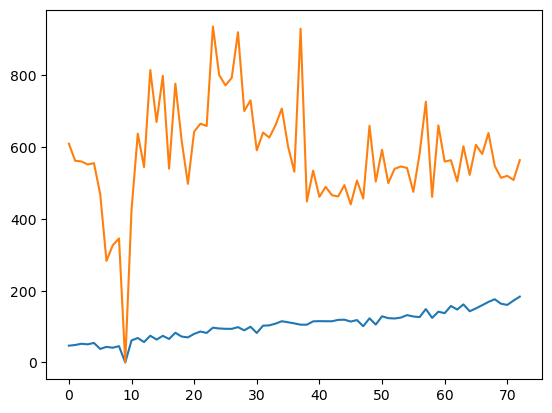

In [54]:
plt.plot(d1)
plt.plot(d2)

In [46]:
try:
    df.loc[df['Unique ID'] == unique_ID, 'Mtb area new (um2)'] = mtb_areas        
    df.to_pickle('different_area_1measure_approach.pkl')
    print("Values saved to pickle")
except Exception as e:
    print(f"An error occurred: {str(e)}")
    # Save the list of integers to a text file
    with open(f'mtb_areas_{unique_ID}.txt', 'w') as file:
        # Extract the values from the 'B' column where Unique ID matches
        file.write('\n'.join(map(str, mtb_areas)))
    print("Values saved to 'output.txt'")

        

Values saved to pickle


In [60]:
images.shape

(150, 6048, 6048)

In [62]:
rfp_images = images

In [65]:
from macrohet import tools

In [ ]:
dfs = []
for track in tqdm(filtered_tracks, total = len(filtered_tracks), desc = 'iterating over tracks'):
            # # Raw MTB values (interpolated)
            # raw_mtb_values = pd.Series(track['mean_intensity'][:, mtb_channel]).interpolate(method='linear')
            
            # # Raw GFP values (interpolated)
            # raw_gfp = pd.Series(track['mean_intensity'][:, gfp_channel]).interpolate(method='linear')
            
            # # Thresholded MTB values (interpolated)
            # mtb_values = pd.Series(track['mean_intensity'][:, manual_mtb_thresh_channel]).interpolate(method='linear')
            
            # # Smoothed MTB signal using a rolling window of 4 with median values,
            # # then backfilling missing values at the start
            # mtb_smooth = np.array(mtb_values.rolling(window=4).median().interpolate(method='backfill'))

            # mtb_area = pd.Series(track['Mtb Area']).interpolate(method='linear')
            # # Interpolate other variables using appropriate methods
            # minor_axis_length = pd.Series(track['minor_axis_length']).interpolate(method='linear')
            # major_axis_length = pd.Series(track['major_axis_length']).interpolate(method='linear')
            
            # # Interpolate infection status using a combination of approaches
            # infection_status = pd.Series(track['Infected'])
            
            # # If the first value is missing, assign it the closest infection value
            # if pd.isnull(infection_status.iloc[0]):
            #     infection_status.iloc[0] = infection_status.iloc[infection_status.first_valid_index()]
            
            # # Fill subsequent missing values with the previous value
            # infection_status = infection_status.fillna(method='ffill')
            
            # # Interpolate area based on linear method
            # area = pd.Series(track['area']).interpolate(method='linear')
        
        info = assay_layout.loc[acq_ID]
        mtb_areas = tools.measure_mtb_area(track, masks, rfp_images)
        # initial infection status 
        # init_infec_status = [True for t in track.t if any(mtb_areas[0:5])]
        ### compile single track dictionary of info
        d = {'Time (hours)':track['t'], 
             'Mtb Area µm2': mtb_areas,
             'x':track['x'],
             'y':track['y'],
             # 'Infection status':track['Infected'],
             # 'Initial infection status':track['Infected'][0], 
             # 'Final infection status':track['Infected'][-1], 
             'Mphi Area':track['area'], 
             # 'Mtb RFP':track['mean_intensity'][:, 1],
             # 'Mtb RFP threshold':track['mean_intensity'][:, 2],
             # 'Mphi GFP':track['mean_intensity'][:, 0],
             'Eccentricity':np.sqrt(1-((track['minor_axis_length']**2)/(track['major_axis_length']**2))),
             'MSD': [tools.euc_dist(track['x'][i-1], 
                                    track['y'][i-1], 
                                    track['x'][i], 
                                    track['y'][i]) 
                      if i != 0 else 0
                      for i in range(0, len(track))],
             'Strain':[info['Strain'] for i in range(len(track['t']))], 
             'Compound':[info['Compound'] for i in range(len(track['t']))], 
             'Concentration':[info['ConcentrationEC'] for i in range(len(track['t']))], 
             'Cell ID':[track.ID for i in range(len(track['t']))],
             'Acquisition ID':[acq_ID for i in range(len(track['t']))], 
             'Unique ID': [f'{track.ID}.{acq_ID[0]}.{acq_ID[1]}.' for i in range(len(track['t']))]}
    ### append df to list of dfs
        dfs.append(pd.DataFrame(d))
df_new_area = pd.concat(dfs, ignore_index=True)


iterating over tracks:   0%|          | 0/134 [00:00<?, ?it/s]

Calculating mtb area for every frame in track: 203:   0%|          | 0/149 [00:00<?, ?it/s]

Calculating mtb area for every frame in track: 199:   0%|          | 0/138 [00:00<?, ?it/s]

Calculating mtb area for every frame in track: 191:   0%|          | 0/89 [00:00<?, ?it/s]

Calculating mtb area for every frame in track: 190:   0%|          | 0/102 [00:00<?, ?it/s]

Calculating mtb area for every frame in track: 189:   0%|          | 0/101 [00:00<?, ?it/s]

Calculating mtb area for every frame in track: 224:   0%|          | 0/150 [00:00<?, ?it/s]

Calculating mtb area for every frame in track: 222:   0%|          | 0/133 [00:00<?, ?it/s]

Calculating mtb area for every frame in track: 220:   0%|          | 0/150 [00:00<?, ?it/s]

Calculating mtb area for every frame in track: 187:   0%|          | 0/148 [00:00<?, ?it/s]

Calculating mtb area for every frame in track: 210:   0%|          | 0/150 [00:00<?, ?it/s]

Calculating mtb area for every frame in track: 166:   0%|          | 0/150 [00:00<?, ?it/s]

Calculating mtb area for every frame in track: 163:   0%|          | 0/150 [00:00<?, ?it/s]

Calculating mtb area for every frame in track: 154:   0%|          | 0/134 [00:00<?, ?it/s]

Calculating mtb area for every frame in track: 179:   0%|          | 0/80 [00:00<?, ?it/s]

Calculating mtb area for every frame in track: 175:   0%|          | 0/150 [00:00<?, ?it/s]

Calculating mtb area for every frame in track: 278:   0%|          | 0/149 [00:00<?, ?it/s]

Calculating mtb area for every frame in track: 272:   0%|          | 0/150 [00:00<?, ?it/s]

Calculating mtb area for every frame in track: 270:   0%|          | 0/148 [00:00<?, ?it/s]

Calculating mtb area for every frame in track: 269:   0%|          | 0/144 [00:00<?, ?it/s]

In [55]:
import matplotlib.pyplot as plt

In [58]:
df

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Mtb Area,Eccentricity,MSD,Strain,Compound,Concentration,Technical replicate,Cell ID,Acquisition ID,Unique ID
0,0,569.062397,9.237196,2868.074482,46.555468,0.0,0.0,0.0,25402.0,0.0,0.926014,0.000000,WT,CTRL,EC0,1.0,203,"(3, 3)",203.3.3
1,1,576.212460,10.061401,2904.110799,50.709461,0.0,0.0,0.0,34522.0,0.0,0.944895,7.197410,WT,CTRL,EC0,1.0,203,"(3, 3)",203.3.3
2,2,578.096199,9.063682,2913.604843,45.680955,0.0,0.0,0.0,29115.0,0.0,0.956688,2.131646,WT,CTRL,EC0,1.0,203,"(3, 3)",203.3.3
3,3,574.468117,9.212736,2895.319308,46.432190,0.0,0.0,0.0,32370.0,0.0,0.953434,3.631143,WT,CTRL,EC0,1.0,203,"(3, 3)",203.3.3
4,4,578.519179,10.851846,2915.736664,54.693302,0.0,0.0,0.0,30949.0,0.0,0.929726,4.370102,WT,CTRL,EC0,1.0,203,"(3, 3)",203.3.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16029,145,1158.772856,304.207926,5840.215195,1533.207949,0.0,0.0,0.0,22770.0,0.0,0.844522,10.412784,WT,CTRL,EC0,1.0,3344,"(3, 3)",3344.3.3
16030,146,1163.343298,308.705675,5863.250223,1555.876603,NaN,0.0,0.0,NaN,0.0,0.840255,6.412385,WT,CTRL,EC0,1.0,3344,"(3, 3)",3344.3.3
16031,147,1147.404485,297.632574,5782.918606,1500.068172,0.0,0.0,0.0,11647.0,0.0,0.833701,19.407713,WT,CTRL,EC0,1.0,3344,"(3, 3)",3344.3.3
16032,148,1147.990465,299.364968,5785.871944,1508.799440,0.0,0.0,0.0,13213.0,0.0,0.761509,1.828815,WT,CTRL,EC0,1.0,3344,"(3, 3)",3344.3.3


(array([2620., 1145.,  470.,  150.,  108.,   94.,   29.,   10.,   13.,
           3.]),
 array([  0.        ,  71.53742714, 143.07485428, 214.61228142,
        286.14970857, 357.68713571, 429.22456285, 500.76198999,
        572.29941713, 643.83684427, 715.37427141]),
 <BarContainer object of 10 artists>)

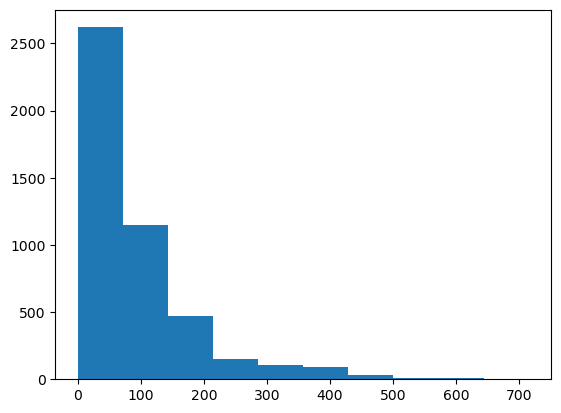

In [57]:
# actual area in pixels 
plt.hist((df['Mtb Area']*df['Area']).unique()*0.022348462087275478)

In [156]:
### combing dfs and convering area to proper mtb measure

In [20]:
essential_df = pd.read_pickle('with_area essential.pkl')
nonessential_df = pd.read_pickle('with_area.pkl')

In [38]:
(nonessential_df['Acquisition ID'].unique())

array([(3, 4), (4, 3), (4, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9),
       (3, 10), (3, 11), (3, 12), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9),
       (4, 10)], dtype=object)

In [45]:
(df['Mtb Area'] * df['Area']).unique()

array([   0.,   nan,  226., ..., 3291., 3072., 3278.])

In [46]:
df = pd.concat([nonessential_df, df])

In [23]:
len(nonessential_df)

211557

In [47]:
len(df['Acquisition ID'].unique())

18

In [29]:
len(glob.glob(f'/mnt/SYNO/macrohet_syno/{expt_ID}/labels/macrohet_seg_model/*_first_pass.h5'))

18

In [167]:
len(df), len(nonessential_df)

(211557, 211557)

In [48]:
df.to_pickle('/mnt/SYNO/macrohet_syno/ND0002/results/unchecked_74_corrected_area_df.pkl')

In [135]:
146266.0*0.002222

325.003052

In [154]:
# Check if all values in the 'Mtb Area' column are integers
are_all_integers = df['Mtb Area'].apply(lambda x: isinstance(x, int)).all()

if are_all_integers:
    print("All values in 'Mtb Area' column are integers.")
else:
    print("Not all values in 'Mtb Area' column are integers.")

Not all values in 'Mtb Area' column are integers.


In [67]:
import napari

In [68]:
napari_tracks, _, _ = btrack.utils.tracks_to_napari(tracks, ndim = 2)

In [127]:
viewer = napari.Viewer(title = 'this one!')

# viewer.add_image(images)
# viewer.add_image(mtb_area_thresh)
# viewer.add_labels(segmentation)
# viewer.add_tracks(napari_tracks)

In [128]:
napari_tracks, _, _ = btrack.utils.tracks_to_napari([t for t in tracks if len(t) > 74], ndim = 2)

In [129]:
viewer.add_tracks(napari_tracks, scale=(1/scale_factor, 1/scale_factor))

<Tracks layer 'napari_tracks' at 0x7f7c6cf443a0>

In [96]:
scale = (1, 5.04, 5.04)

In [97]:
scale[-2]

5.04

In [108]:
importlib.reload(btrack.utils)

<module 'btrack.utils' from '/home/dayn/analysis/btrack/btrack/utils.py'>

In [109]:
recoloured_seg =  btrack.utils.update_segmentation(segmentation, tracks, scale = (1, 5.04, 5.04))

[3129, 1743, 2152, 2640, 2797, 3699, 4505, 5735, 5967, 3230, 5266, 176, 458, 1023, 4228, 2711, 3664, 2368, 4873, 856, 2953, 2857, 1577, 45, 5196, 1023, 1794, 2509, 5962, 2353, 4037, 5503, 5891, 3890, 4979, 3442, 4631, 1365, 115, 262, 2923, 3054, 5407, 1743, 2373, 4430, 5589, 4304, 1723, 3361, 3638, 705, 1925, 1265, 4782, 2973, 2086, 2328, 2580, 4092, 35, 5841, 327, 75, 1985, 4893, 1063, 3573, 2943, 4455, 5498, 100, 3759, 5901, 3512, 2565, 2812, 725, 4465, 1774, 5841, 5659, 3255, 2575, 378, 5473, 4304, 3704, 1582, 151, 2278, 3003, 574, 4687, 1355, 2464, 156, 756, 1582, 1496, 866, 4525, 246, 65, 3195, 3447, 3865, 4793, 4410, 463, 4934, 5206, 5760, 4026, 5206, 1990, 3190, 2525, 942, 2303, 5397, 1461, 5654, 3845, 3507, 720, 2005, 6002, 302, 1890, 2353, 5024, 65, 1864, 2872, 4566, 1128, 4324, 3583, 5871, 2318, 1476, 5856, 6007, 4752, 4984, 5765, 1743, 5100, 5276, 3114, 1436, 2106, 619, 2646, 1592, 5236, 4813, 246, 4752, 4782, 2681, 5166, 4737, 1219, 473, 4314, 1638, 2857, 4500, 5327, 4263, 

In [113]:
import napari_animation

In [130]:
viewer.add_labels(recoloured_seg)

<Labels layer 'recoloured_seg' at 0x7f7b36bc0c70>

In [126]:
viewer.dims.current_step

(74, 3023, 3023)

In [131]:
from napari_animation import Animation

animation = Animation(viewer)

viewer.dims.current_step = (0, 3023, 3023)
animation.capture_keyframe(steps=0)
viewer.dims.current_step = (149, 3023, 3023)
animation.capture_keyframe(steps=150)
animation.animate('nd2_64_masks_first_pass_tracks_74.mp4', canvas_only=True)

Rendering frames...


  1%|█                                                                                                                                                         | 1/151 [00:01<02:59,  1.20s/it][swscaler @ 0x56293c8b3cc0] Warning: data is not aligned! This can lead to a speed loss



ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [111]:
recoloured_seg =  btrack.utils.update_segmentation(segmentation, [t for t in tracks if len(t) > 74], scale = (1, 5.04, 5.04))

[3638, 4782, 1063, 3255, 2464, 2525, 302, 2872, 3583, 4752, 3114, 2106, 246, 4752, 3966, 246, 2585, 2509, 3981, 992, 1794, 4505, 5402, 367, 2590, 1819, 4883, 524, 1204, 5090, 3946, 3044, 670, 1612, 2192, 5286, 5392, 5004, 4042, 4662] [473, 498, 766, 892, 1043, 1386, 1411, 1572, 1985, 1638, 1915, 1965, 1874, 2570, 2010, 2812, 2938, 3084, 3190, 3512, 3598, 3548, 3588, 3709, 4062, 4132, 4016, 4057, 4183, 4107, 907, 4505, 4561, 5589, 4878, 4989, 5201, 5327, 5549, 5438]
[4772, 1063, 3240, 2489, 2504, 327, 2812, 3588, 4727, 3109, 2096, 257, 4747, 4011, 231, 2595, 2499, 3966, 977, 1774, 4546, 5433, 362, 2590, 1814, 529, 1189, 5085, 3951, 3054, 640, 1643, 2172, 5236, 5372, 4994, 4037, 6027, 4097, 5992, 5538, 1965, 156] [574, 761, 856, 1083, 1411, 1396, 1592, 2010, 1627, 1920, 1960, 1859, 2615, 1995, 2817, 2958, 3024, 3220, 3528, 3613, 3487, 3502, 3694, 4052, 4142, 4067, 4188, 4112, 952, 4460, 4541, 5589, 4863, 4964, 5201, 5327, 5538, 1300, 1360, 2494, 1995, 4445, 5906]
[4772, 1043, 3195, 2464,